# Data Scientist Challenge - LATAM Airlines

### Busqueda bibliográfica

Lo primero que hice fue una búsqueda bibliográfica no demasiada extensa por cuestiones de tiempo, para intentar ver qué había hecho sobre el tema, se encontraron algunos artículos y páginas interesantes:

https://ddd.uab.cat/pub/tfg/2016/169883/MartinezDomenechNerea-TFGAa2015-16.pdf (Este documento que aparentemente es una tesis de grado, fue util para como referencia de variables y algoritmos usados. Además tiene la estimación del beneficio económico de prevenir retrasos en vuelos. Algo que no siempre es fácil de conseguir en los proyectos de DS)

https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial (este articulo en formato jupyter notebook puede ser util para obtener ideas si es necesario hacer una exploración de datos más detallada, y como referencia de variables usadas)

https://medium.com/@diegitsen/predecir-retrasos-de-vuelo-en-el-aeropuerto-de-madrid-parte-2-c%C3%B3digo-en-python-cc4c39222577 (este articulo finalmente no aportó mucho pero fue una buena referencia como para empezar a entrar en tema, ver qué había hecho y evitar repetir lo que ya es conocido.)


Por otro lado hice una exploración en PowerBI, que si bien no es parte del ejercicio, es una excelente herramienta para un primer encuentro con los datos, a mi entender superior a Jupyter/Python. En el pasado he obtenido resultados muy buenos por la velocidad con que se puede desplegar un tablero y empezar a jugar con el mismo. Creo que es bueno para un Científico de datos tener varias herramientas en la baulera. Se agregaron algunas capturas de los gráficos más interesantes para este caso.

### Versiones usadas e instalaciones adicionales
  

Python 3.9.7  
JupyterLab 3.2.1 

scikit-learn==1.1.2          
scipy==1.7.1    
numpy==1.20.3     
pandas==1.3.4     
matplotlib=3.4.3    
seaborn=0.11.2   


-Instalaciones adicionales:

pip install meteostat  
conda install -c conda-forge imbalanced-learn

In [1]:
#Importación de las ibrerías que se usaron en el notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from imblearn.over_sampling import SMOTE
#Para poder usar SMOTE hay que usar una version distinta de make_pipline, funcionó sin problemas y es compatible con sklearn
from imblearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn import tree

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn import set_config
from sklearn.model_selection import train_test_split, cross_validate


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Datos

In [2]:
#Lectura de datos

df = pd.read_csv('data/dataset_SCL.csv')

#Algunas transformaciones que fueron necesarias

df[['Fecha-I', 'Fecha-O']] = df[['Fecha-I', 'Fecha-O']].astype('datetime64[ns]') # Esto es para poder hacer operaciones como dt.hour
df['Vlo-I'] = "'" + df['Vlo-I'].map(str) + "'" #Esto es para que no haya errores porque algunos vuelos eran numéricos y otros alfanuméricos
df['Vlo-O'] = "'" + df['Vlo-O'].map(str) + "'" #idem anterior

<a id='sectionej1'></a>
## Ejercicio 1: Visualización y primer entendimiento de los datos

1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

Introducción:  
  
Se considera que la intención de esta pregunta es que se haga una exploración preliminar y visualización de los datos sin limitarse al problema de predicción que enmarca el desafío.  
Por tal motivo se procedió a escribir un script que automáticamente tome todas las variables del dataset y las muestre en [Pie charts](#Pie_charts) y en [Bar charts](#Bar_charts) (con un limite de categorías).  
Como esto ocupa mucho espacio, hay algunos gráficos que carecen de sentido (por ejemplo Pie_chart: Fecha-I) y otros aportan poca información (como por ejemplo Pie_chart: Ori-O, ya que el 100% de los vuelos tienen origen en SCEL, es decir el aeropuerto de Santiago de Chile) se dejaron todos los gráficos en un [Apéndice](#Apendice). Y se traerán los más importantes a esta sección.
Por otro lado se exploró la información disponible en las funciones describe y info de pandas, por cuestiones de claridad la misma también se deja en la sección [Apéndice](#Apendice).
Asimismo se realizó un análisis exploratorio en PowerBI, que si bien no se puede visualizar  desde este notebook, como ya veremos, es una herramienta superior para navegar/explorar datos, disparador de ideas y preguntas para hacerle a los datos. De esta se tomaron las capturas más importantes y se incluyeron como imágenes.  
  
Exploración:  

Mirando la información del [Apéndice](#Apendice) vemos que hay 68205 filas de datos que cada una corresponde a un vuelo distinto, aparentemente no se ven faltantes o nulls. Las Fechas Programadas tienen un detalle de intervalos de 5 minutos, mientras que las Fechas de Operación tienen un detalle al minuto. La mayoría de las variables en la base de datos son categóricas, salvo las variables numéricas DIA, MES, AÑO, que se pueden derivar de la fecha. Como era de esperar la totalidad de los vuelos tienen como origen el aeropuerto SCEL. 
  
Sección [Pie_charts_elegidos](#Pie_charts_elegidos): 
  
- Emp-I podemos observar que LAN es la empresa con mayor cantidad de vuelos con el 55.1 %, seguida por SKU.  
- En el gráfico OPERA se ve que el Grupo Latam tiene un porcentaje de vuelos aún mayor llegando al 60%.  
- TIPOVUELO muestra que el 54.2% de los vuelos es Nacional siendo el resto Internacional.  
- En SIGLADES podemos ver que las principales ciudades de destino, siendo la principal Buenos Aires seguida por Antofagasta.  

Sección [Bar_charts_elegidos](#Bar_charts_elegidos):  

- Se puede ver en DIANOM que Viernes es el día con más vuelos, seguido por el Jueves.    
- En VlO-O vemos que el Número de vuelo programado que más veces viajó en el año fue el '174' con 649 vuelos, seguido por el '11' con 646 (detalles numéricos obtenidos mostrados en el [Apéndice](#Apendice).  
- Finalmente en Fecha-O se puede ver que la máxima frecuencia de vuelos es de 5 por minuto.
  
Hay varios análisis adicionales en la sección [Análisis Capturas PowerBI](#sectionacpbi):  
  



### Pie_charts_elegidos

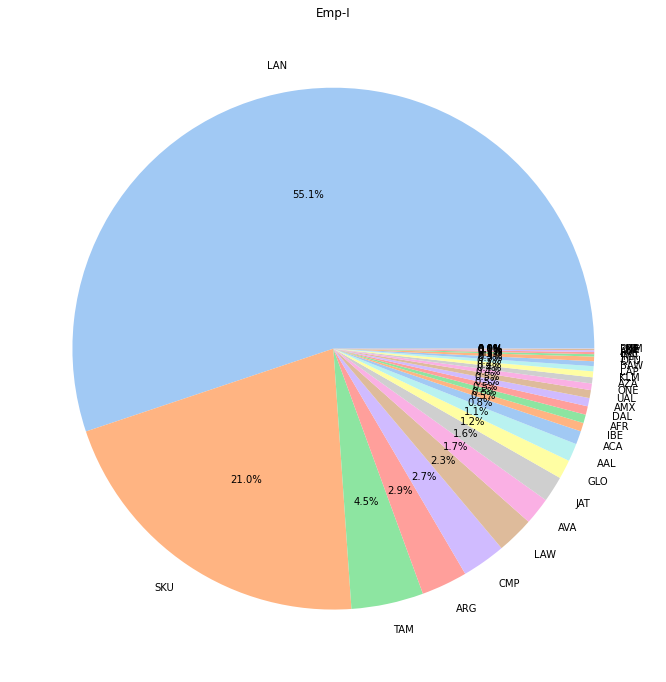

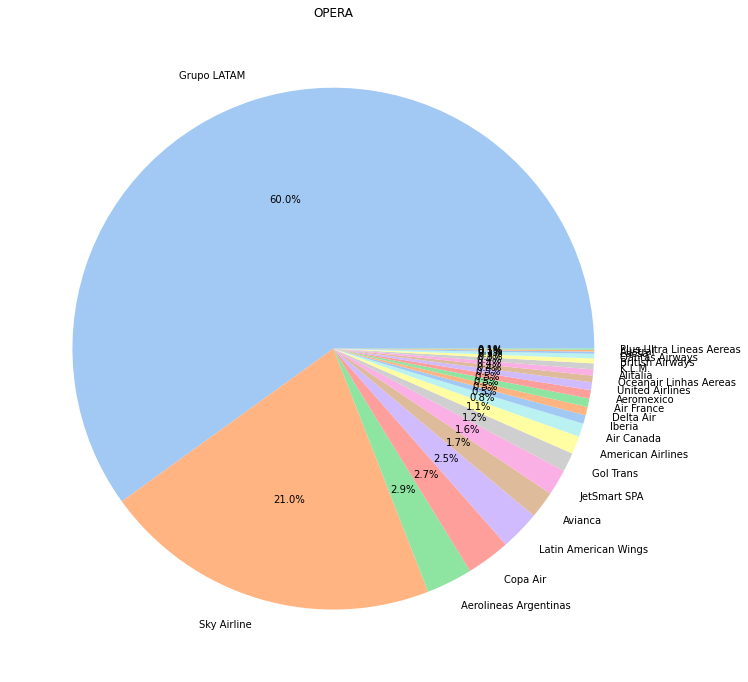

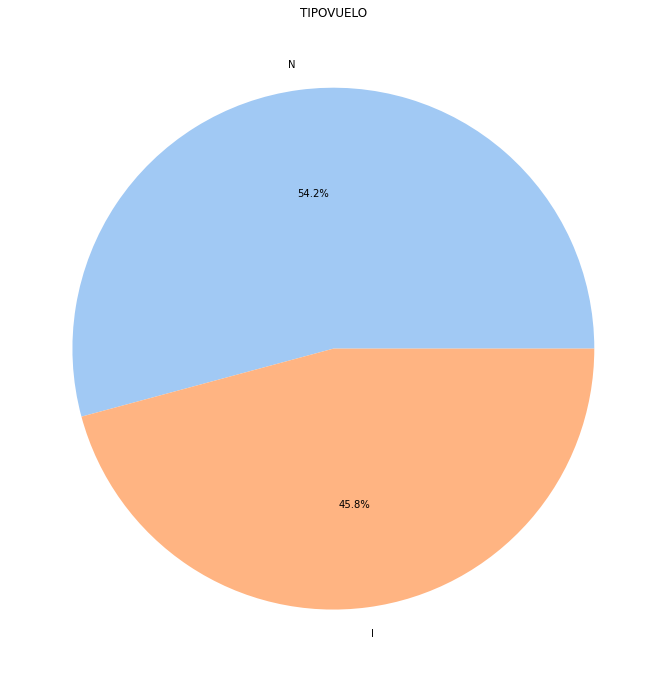

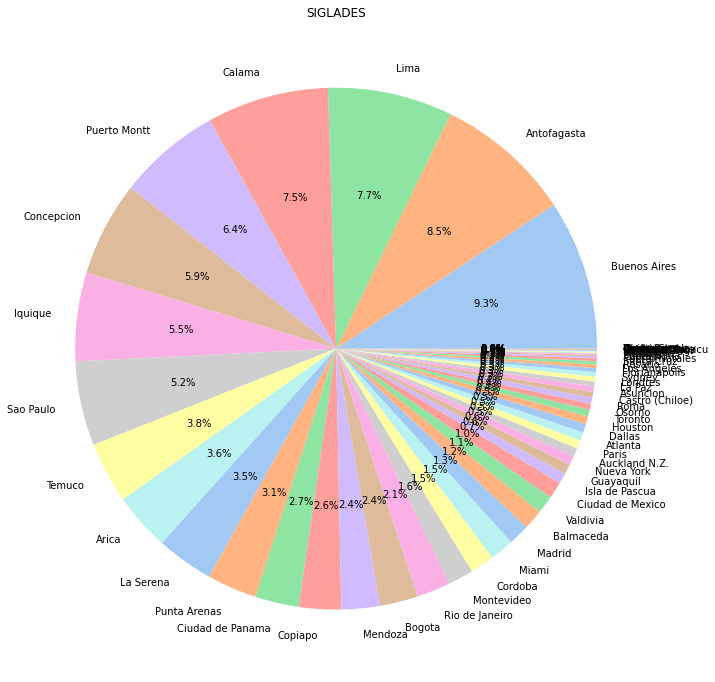

In [3]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_pie=df[['Emp-I','OPERA', 'TIPOVUELO','SIGLADES']]
for n in range(len(df_pie.columns)):
    colors = sns.color_palette('pastel')[0:len(df_pie[list(df_pie.columns.values)[n]].value_counts())]
    plt.figure(figsize=(12, 12))
    plt.title((df_pie.columns.values)[n])
    plt.pie(df_pie[list(df_pie.columns.values)[n]].value_counts().head(top),labels=df_pie[list(df_pie.columns.values)[n]].value_counts().head(top).index.tolist(), autopct='%1.1f%%', colors=colors)
plt.show()

### Bar_charts_elegidos

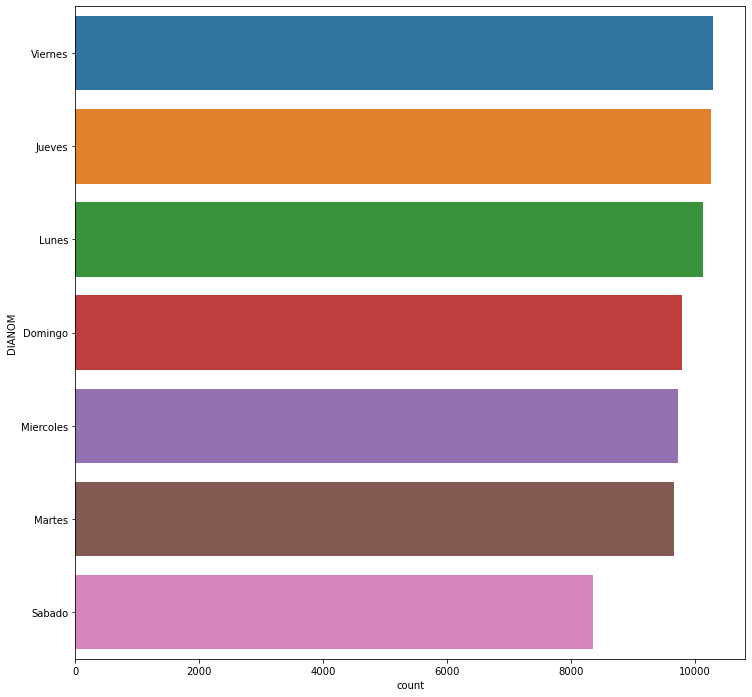

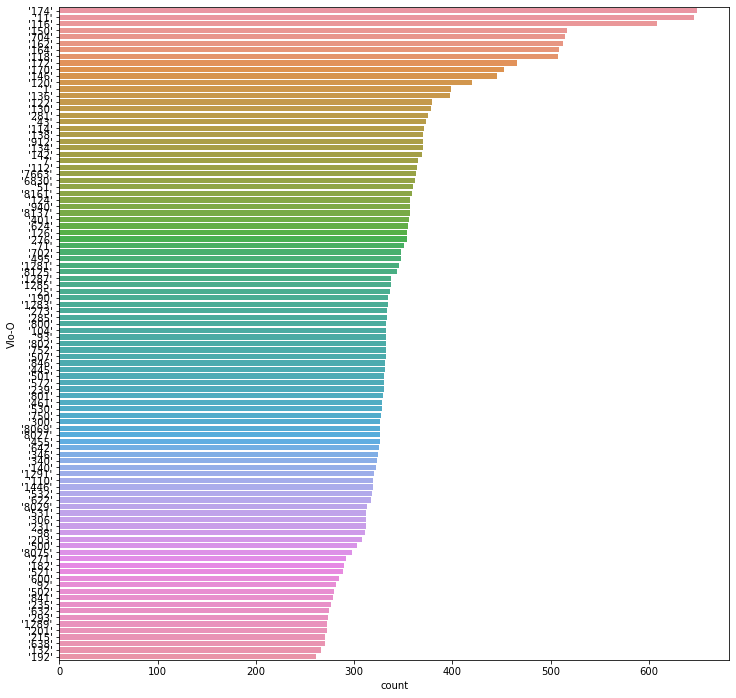

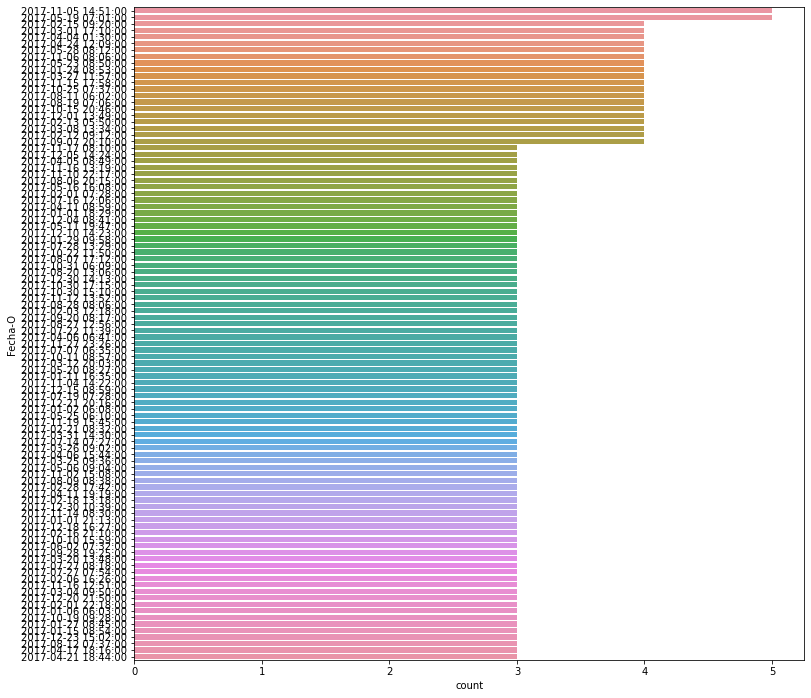

In [4]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_bar=df[['DIANOM', 'Vlo-O', 'Fecha-O']]
for n in range(len(df_bar.columns)):
    count_order = df_bar[list(df_bar.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df_bar, y=list(df_bar.columns.values)[n], order=count_order)
plt.show()


## Ejercicio 2: New features

2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv :

- temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.  DONE

- dif_min : diferencia en minutos entre Fecha-O y Fecha-I . DONE

- atraso_15 : 1 si dif_min > 15, 0 si no. DONE

- periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I . DONE

(Todo comprobado usando la exportación a csv)

In [5]:
#Código que resuelve el Ejercicio 2
df2=df
df2['temporada_alta'] = np.where( ((df2['Fecha-I'].dt.month==12) & (df2['Fecha-I'].dt.day >=15)) | (df2['Fecha-I'].dt.month==1) | (df2['Fecha-I'].dt.month==2) | ((df2['Fecha-I'].dt.month==3) & (df2['Fecha-I'].dt.day <=3)) | ((df2['Fecha-I'].dt.month==7) & (df2['Fecha-I'].dt.day >=15) &  (df2['Fecha-I'].dt.day<=31)) | ((df2['Fecha-I'].dt.month==9) & (df2['Fecha-I'].dt.day >=11) & (df2['Fecha-I'].dt.day <=30)), 1, 0)

#Supuse que las las fechas que separan las temporadas forman parte de la temporada alta, si no es así se puede cambiar muy facilmente 


df2['dif_min']= (df2['Fecha-O']-df2['Fecha-I'])/np.timedelta64(1,'m')

df2['atraso_15'] = np.where(df2['dif_min'] > 15, 1, 0) 


conditions = [(df2['Fecha-I'].dt.hour >= 5) & (df2['Fecha-I'].dt.hour < 12), (df2['Fecha-I'].dt.hour >= 12) & (df2['Fecha-I'].dt.hour < 19), (df2['Fecha-I'].dt.hour >= 19) | (df2['Fecha-I'].dt.hour < 5)]
values = ['mañana', 'tarde', 'noche']
df2['periodo_dia'] = np.select(conditions, values)

df2.tail()

Fecha-I  Vlo-I Ori-I Des-I Emp-I             Fecha-O  \
68201 2017-12-22 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-22 15:41:00   
68202 2017-12-25 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-25 15:11:00   
68203 2017-12-27 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-27 15:35:00   
68204 2017-12-29 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-29 15:08:00   
68205 2017-12-31 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-31 15:04:00   

         Vlo-O Ori-O Des-O Emp-O  ...   AÑO     DIANOM  TIPOVUELO  \
68201  '400.0'  SCEL  SPJC   JAT  ...  2017    Viernes          I   
68202  '400.0'  SCEL  SPJC   JAT  ...  2017      Lunes          I   
68203  '400.0'  SCEL  SPJC   JAT  ...  2017  Miercoles          I   
68204  '400.0'  SCEL  SPJC   JAT  ...  2017    Viernes          I   
68205  '400.0'  SCEL  SPJC   JAT  ...  2017    Domingo          I   

              OPERA  SIGLAORI SIGLADES temporada_alta dif_min  atraso_15  \
68201  JetSmart SPA  Santiago     Lima              1    46.0          1   
68202  JetSmart SPA  Santiago     Lima              1    16.0          1   
68203  JetSmart SPA  Santiago     Lima              1    40.0          1   
68204  JetSmart SPA  Santiago     Lima              1    13.0          0   
68205  JetSmart SPA  Santiago     Lima              1     9.0          0   

       periodo_dia  
68201        tarde  
68202        tarde  
68203        tarde  
68204        tarde  
68205        tarde  

[5 rows x 22 columns]

In [6]:
#Exporto nuevas variables al archivo csv solicitado
       
df2[['temporada_alta', 'dif_min','atraso_15','periodo_dia']].to_csv('synthetic_features.csv')

## Ejercicio 3: Tasas de atraso e importancia de variables

3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo? ¿Qué variables esperarías que más influyeran en predecir atrasos?

Para visualizar las tasas de atraso, nuevamente se usó un script que automáticamente toma todas las variables, ahora del dataset ampliado, y muestra la cantidad de casos con atrasos y sin atrasos por categoría, y por otro lado un gráfico donde se puede ver el porcentaje de atrasos por categoría. Estos gráficos están pensados para usarse de a pares, ya que son complementarios entre si. Quedan todos disponibles en [Histoplots](#Histoplots), en el [Apéndice](#Apendice). Luego de un primer paneo general se seleccionaron los solicitados específicamente en este ejercicio para dejarse en [Histoplots_elegidos](#Histoplots_elegidos).

Analizando únicamente las tasas, se puede ver que hay diferencias notables entre las distintas categorías (lo que indicaría que pueden ser variables influyentes en la predicción) para los casos de destino (Des-I) y  aerolínea (OPERA). Sin embargo hay que tener mucha precaución en tomar conclusiones solo con esta variable ya que puede carecer de peso estadístico. Por ejemplo los destinos SLCB, EGYP, SEQU, SEQM  muestran una tasa de atraso del 100%, mirando este número uno podría pensar que en el futuro estos tienen un atraso asegurado, sin embargo al ver el número de casos, vemos que hubo solo 1 vuelo en cada uno de estos por lo que puede ser un resultado fortuito (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas). Por este motivo, se deben usar los gráficos complementarios con la cantidad de casos en conjunto con los que muestran las tasas. Además, el análisis visual debe ser considerado meramente como una orientación, fuente de ideas e interrogantes para luego deben ser comprobados con análisis adicionales, como algún método de Feature Selection. En este notebook, se usó par esto el orden de variables que se obtiene de Random Forest, función muy útil de este algoritmo. 

Analizando las tasas de atraso por MES en [Histoplots_elegidos](#Histoplots_elegidos) podemos ver que aparentemente hay un mayor porcentaje para los meses 7 y 12.  
Y mirando los tasas según tipo de vuelo, vemos que hay un 22.56 % de atrasos para vuelos internacionales frente a un 15.06% para los nacionales (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas)), lo que representa un número 50 % mayor. Lo que coincide con la diferencia de comportamiento mencionada en el [Ejercicio 1](#sectionej1)  
DIANOM no aparenta visualmente diferencias de tasas notables, sin embargo en (ver [Detalles_numericos_tasas](#Detalles_numericos_tasas)) podemos ver que el día con mayor tasa es 38% más grande que la tasa del menor. Con lo cual puede ser una variable con cierto peso en las predicciones. 
En la [Fig. 1](#sectionf1) se puede ver que efectivamente DIANOM tiene un peso muy alto, es la segunda en importancia, y MES  es la tercera, corroborando lo antes mencionado. Sin embargo, la primera es el número del día del mes (DIA), algo que no era aparente de antemano, bueno justamente para esto usamos DS.
(mirando el análisis [Análisis Capturas PowerBI](#sectionacpbi) se puede sospechar la importancia de DIA)

Por otro lado en varios de los gráficos se puede evidenciar que la base de datos está desbalanceada, habiendo un 18.5 % de atrasos y un 82.5 % de vuelos que no superaron los 15 minutos de diferencia entre el horario programado y el de operación (esto puede traer problemas y fue discutido más adelante). Estos números se pueden observar en la sección [Detalles_numerico_desbalance](#Detalles_numerico_desbalance).




### Histoplots_elegidos

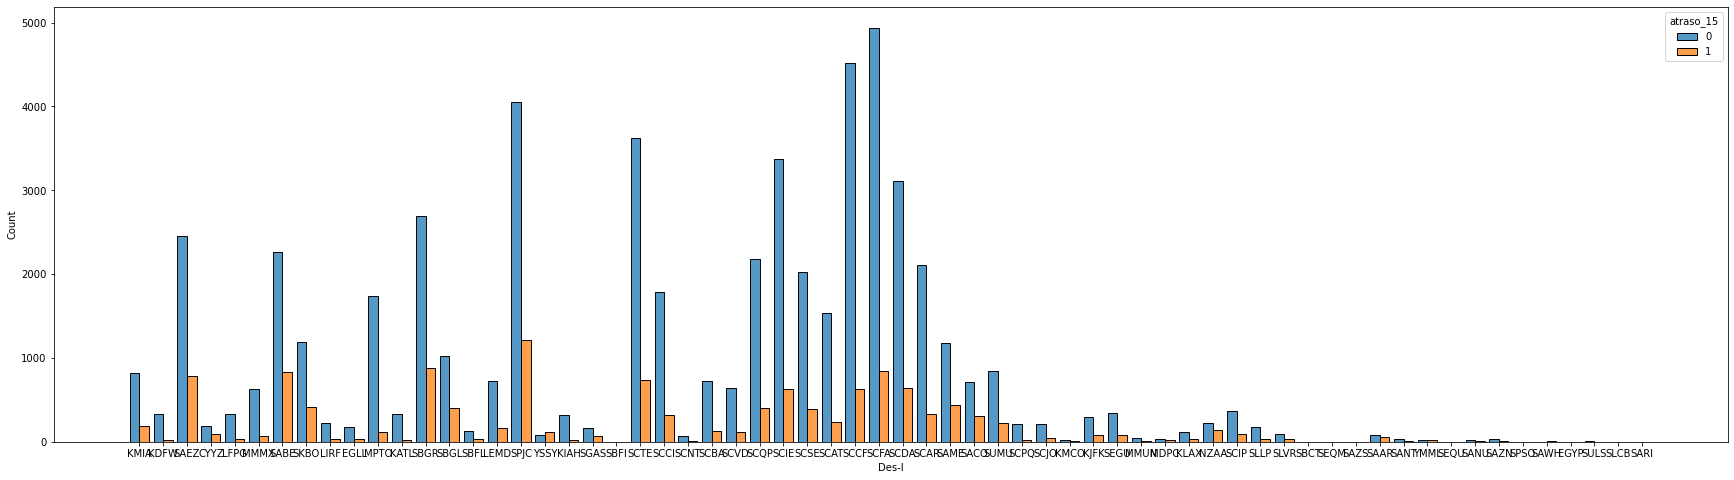

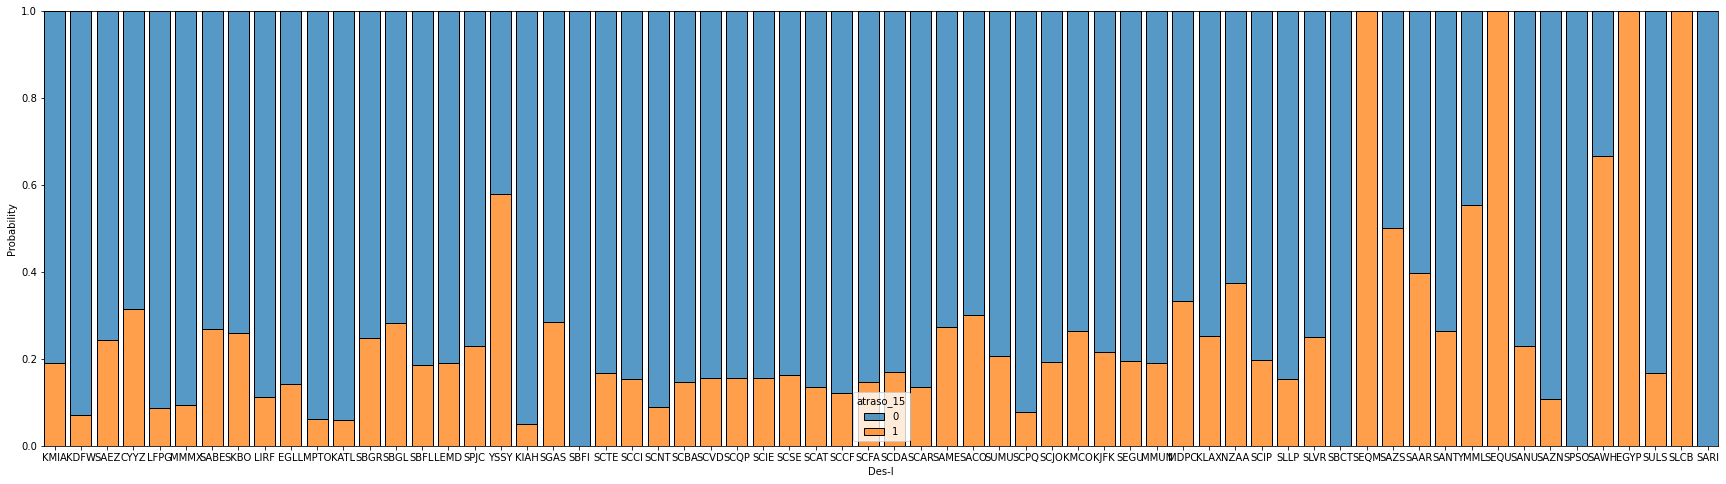

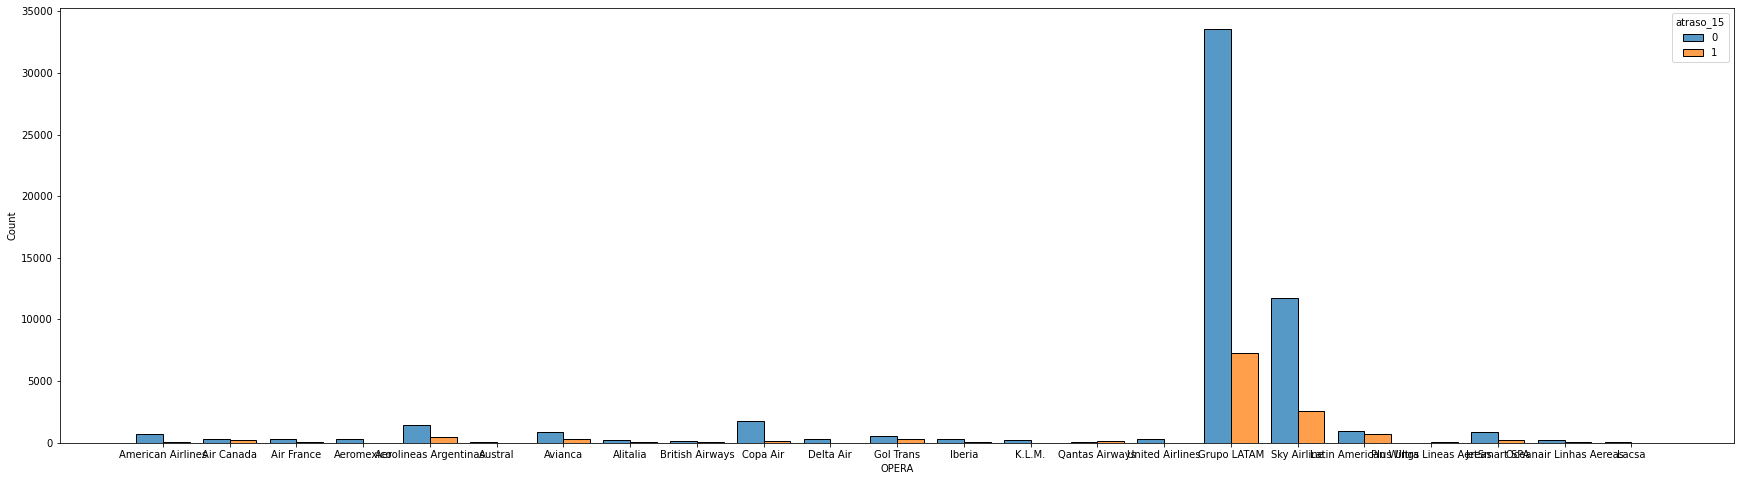

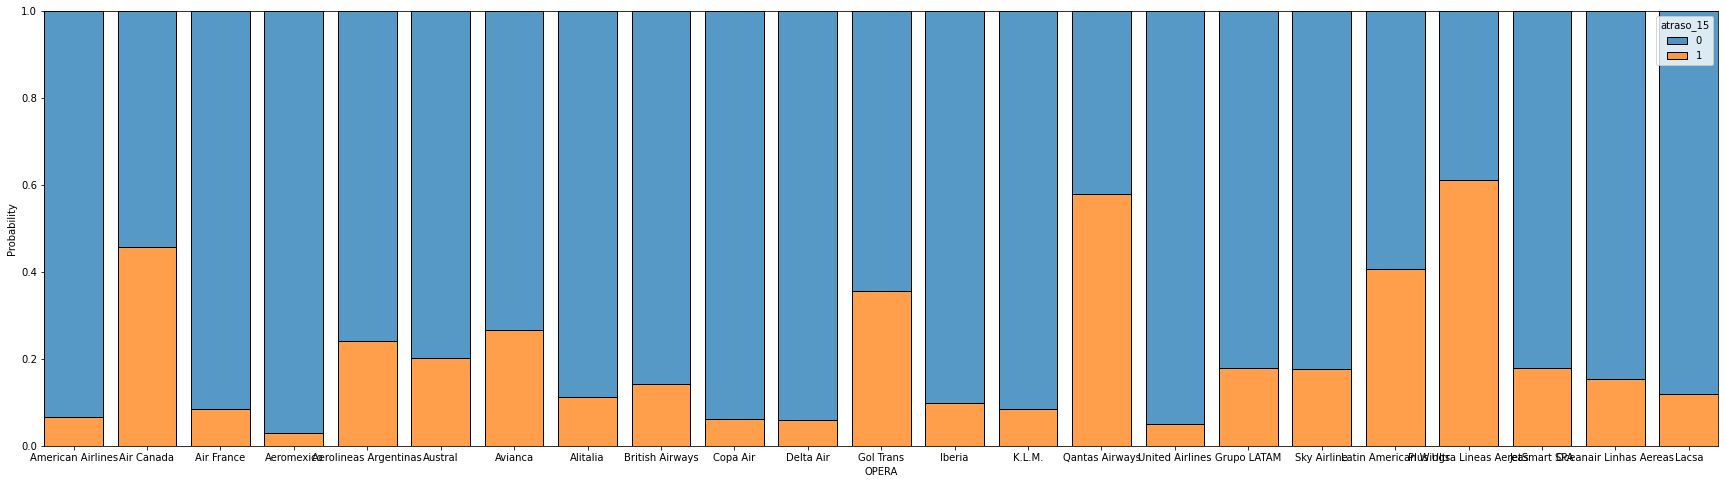

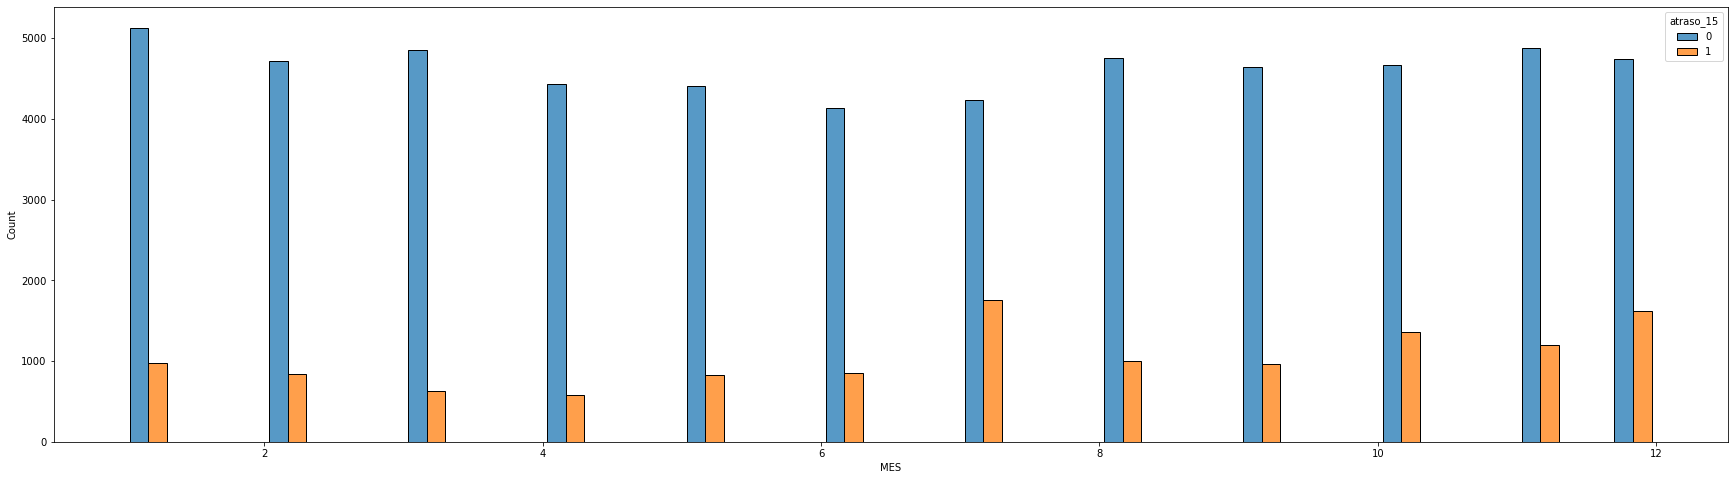

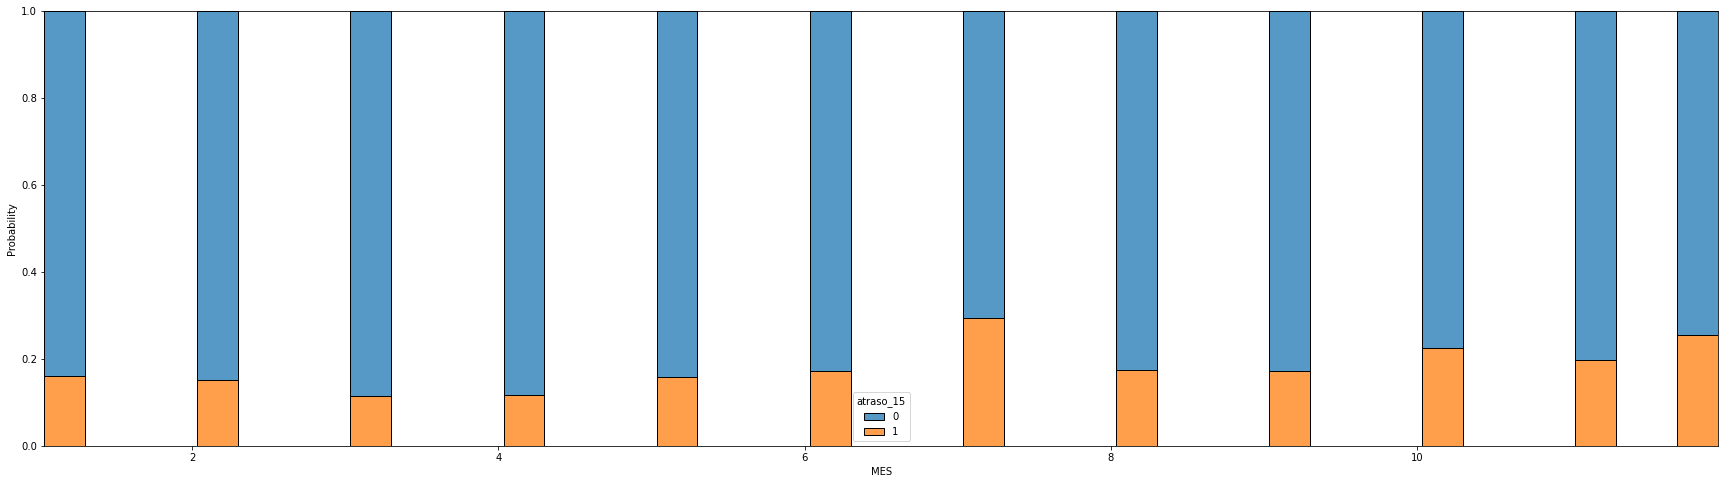

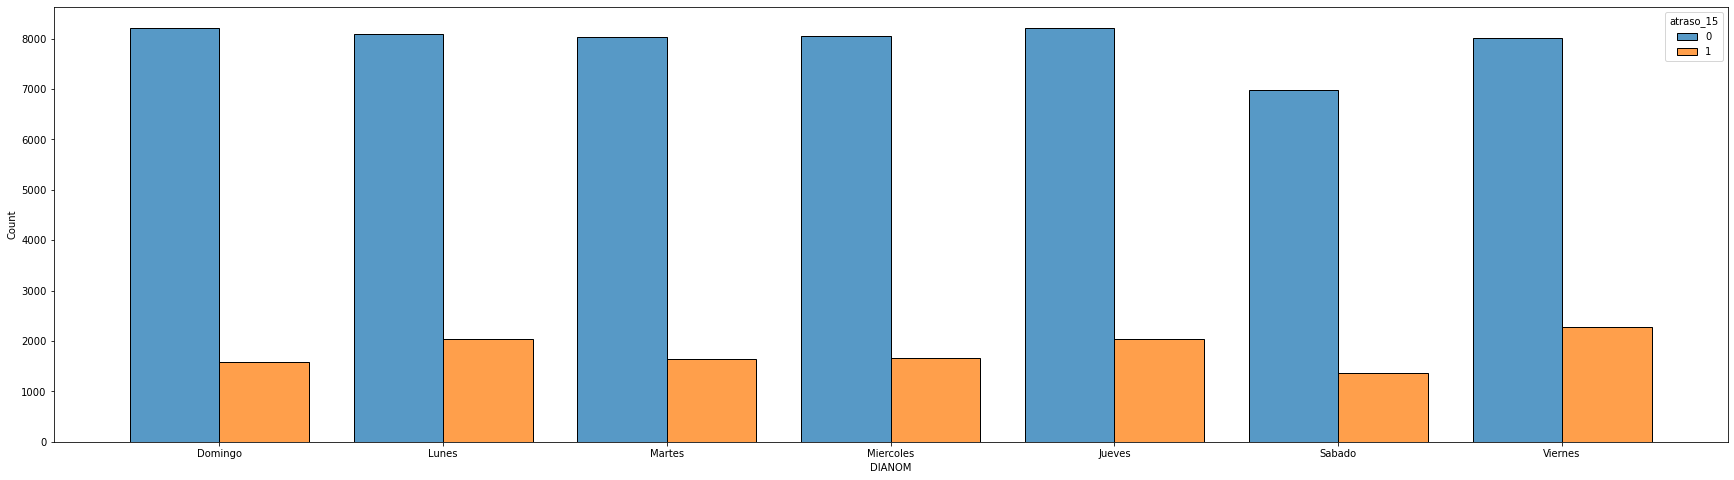

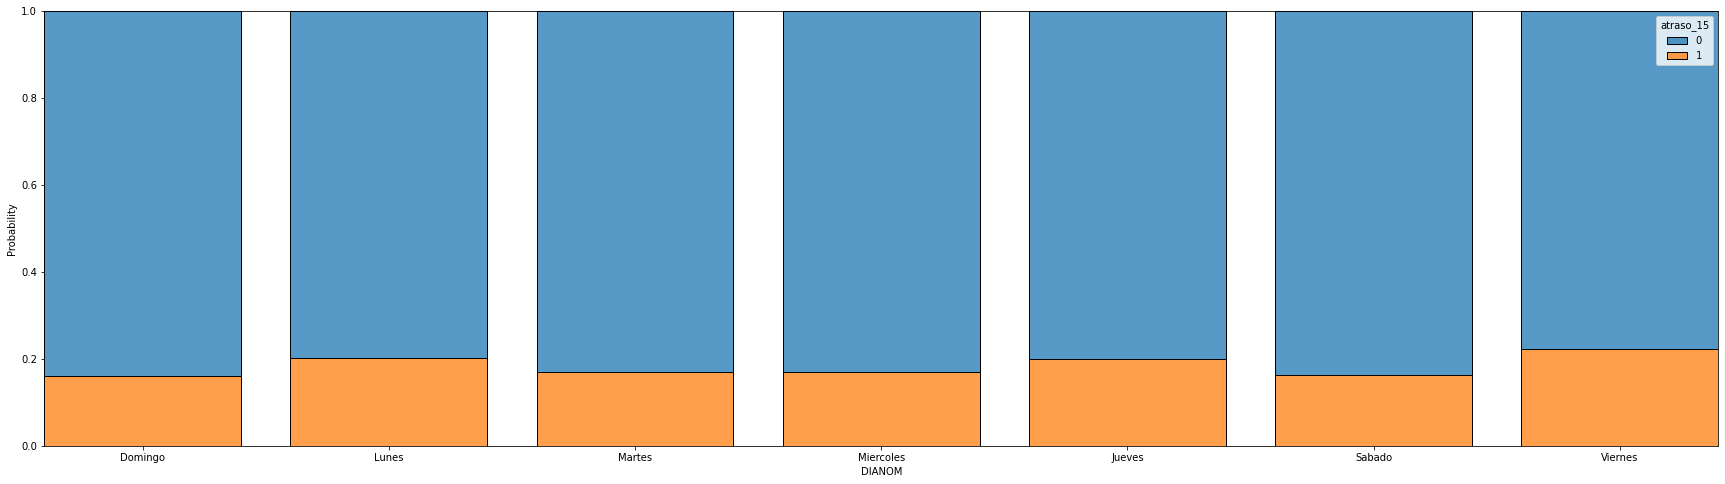

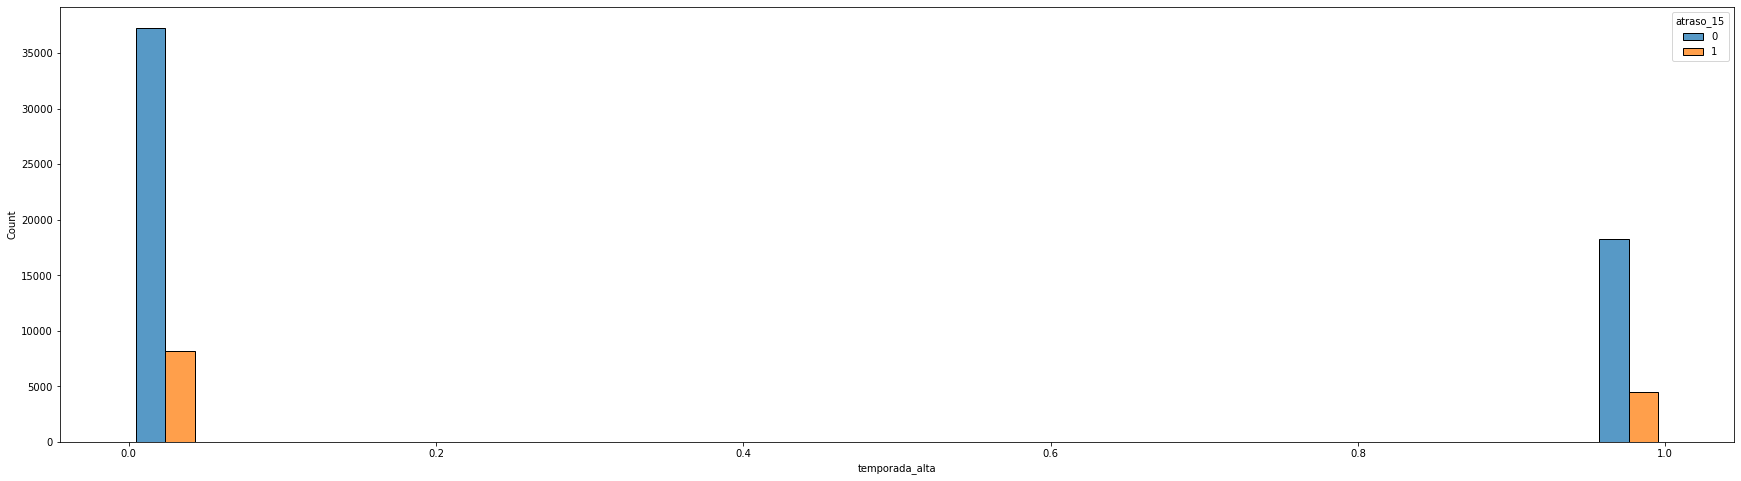

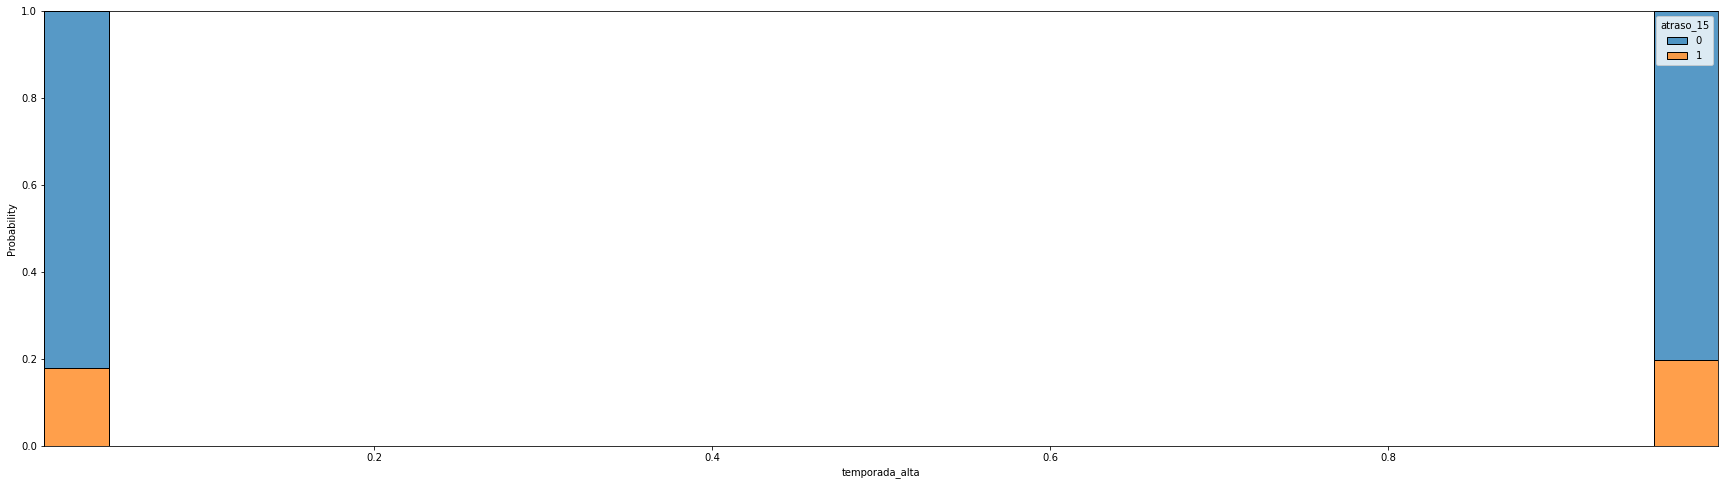

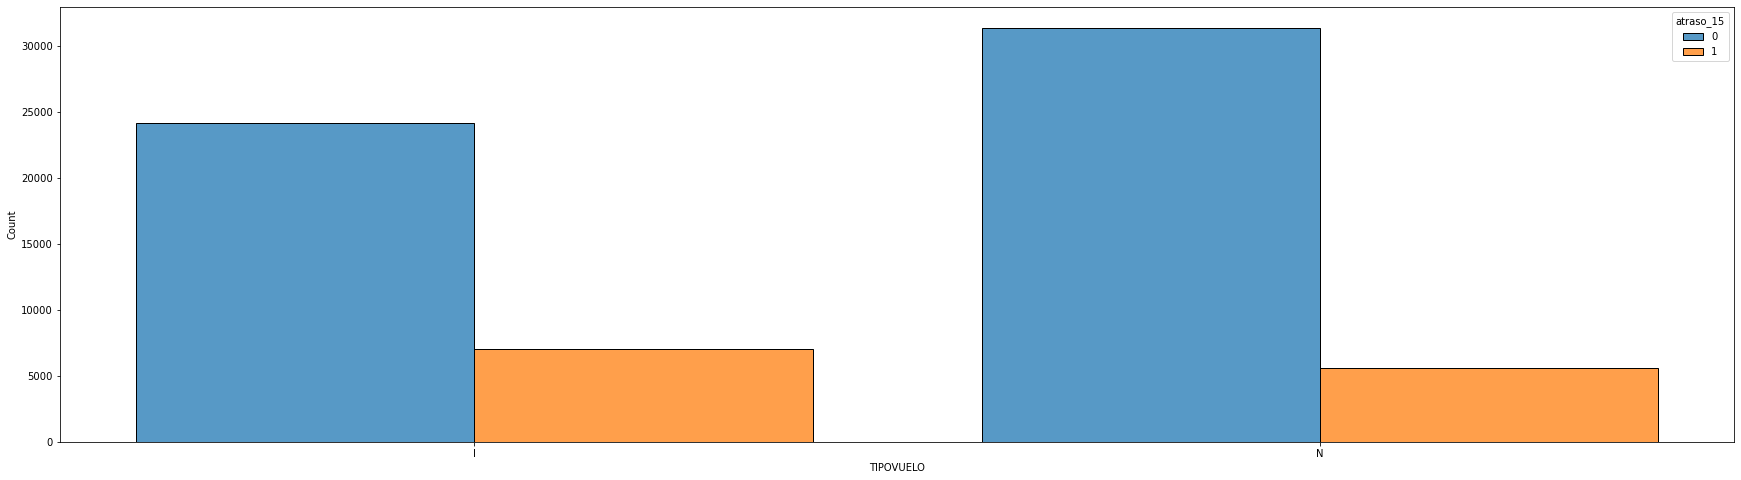

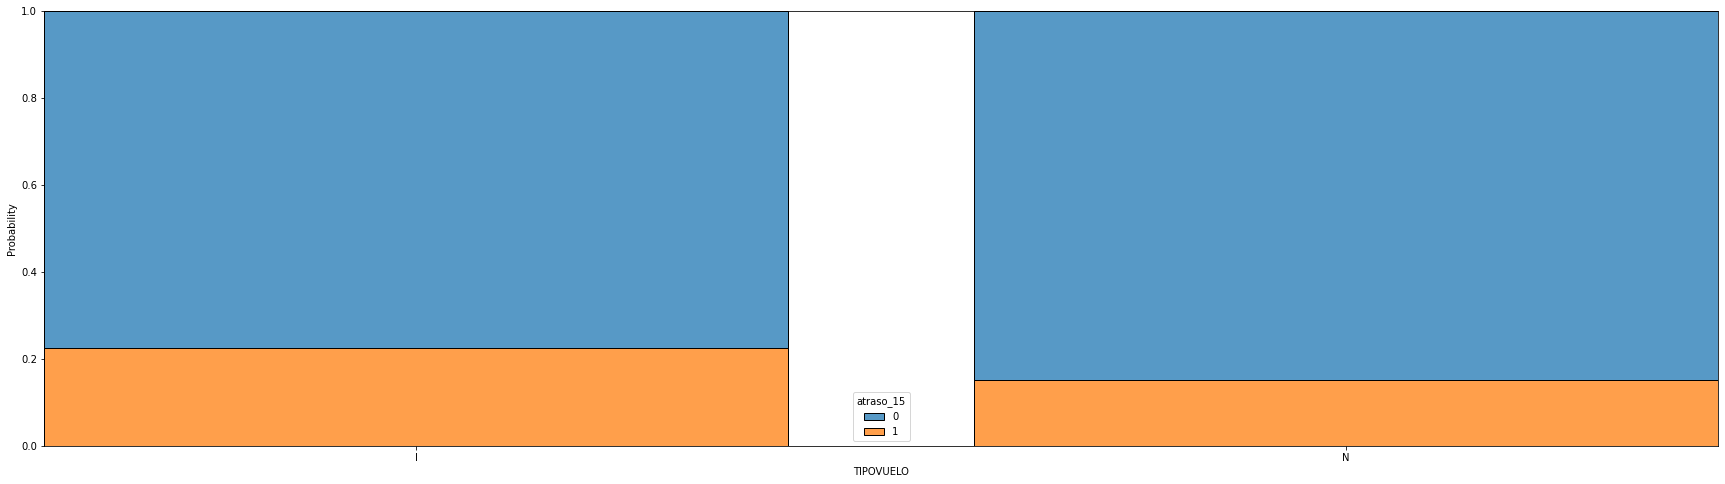

In [7]:
df_hist=df2[['Des-I','OPERA', 'MES','DIANOM', 'temporada_alta', 'TIPOVUELO']]
for n in range(len(df_hist.columns)):
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()

<a id='sectionf1'></a>
### Fig. 1: Feature importance del set original de datos usando Random Forest
![title](img/FeatureImportanceOriginalDataset.png)  
  
### Fig. 2: Feature importance del set ampliado de datos usando Random Forest con SMOTE
![title](img/FeatureImportanceCompleteDataset.png)

## Ejercicio 4: Modelado y variables nuevas

4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo. Siéntete libre de generar variables adicionales y/o complementar con variables externas.


Se hicieron corridas y quedó el código funcionando de los siguientes algoritmos para clasificación (para más detalles ver [Pipeline de Datos y Modelado](#sectionpdm)):   
  
- Por un lado, Multi-layer Perceptron, SVM, Logistic Regressions. Para los que hubo que transformar los datos categóricos usando One Hot Encoding y estandarizando las variables numéricas)   
  
- Por otro lado, Árboles de decisión, Random Forest y Gradient-boosting Trees, para los que la transformación fue mucho más simple, necesitando Ordinal Encoder solo para los datos categóricos.  
  
Para esto se usaron funciones de la librería sklearn y imblearn para generar los respectivos Pipelines.   
  
Además, como se puede ver en las sección Nuevas Variables, se agregaron y probaron las siguientes variables:

- 'Cambio_destino': cambios en la ciudad de destino  
- 'Fecha': Fecha sin hora, que es necesaria además para cruzar con datos clima  
- 'Hora': Hora del día  
- 10 variables climáticas (algunas resultaron importantes, pero varias trajeron solo NaNs) obtenidas con las coordenadas del aeropuerto SCL y las fechas de los datos originales usando la librería de python meteostat

### Nuevas variables

Luego de las primeras pruebas se intentó mejorar los resultados agregando nuevas variables

In [8]:
#Nueva Variable, cambios en la ciudad de destino
#New dataframe: df_n
df_n=df2
df_n['Cambio_destino'] = np.where(df_n['Des-O']==df_n['Des-I'], 0, 1)
df_n['Cambio_destino'].sum()
#Hay demasiado pocos (28) cambios como para usar la variable se deja de todos modos para luego descartala

28

In [9]:
#Nueva Vaiable Fecha sin hora (sirve para cruzar con datos clima)
df_n['Fecha']= df_n['Fecha-I'].dt.date

#Nueva variable hora del día Puede ser importante a comprobar con Random Forest
df_n['Hora']=df_n['Fecha-I'].dt.hour

df_n.tail()

Fecha-I  Vlo-I Ori-I Des-I Emp-I             Fecha-O  \
68201 2017-12-22 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-22 15:41:00   
68202 2017-12-25 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-25 15:11:00   
68203 2017-12-27 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-27 15:35:00   
68204 2017-12-29 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-29 15:08:00   
68205 2017-12-31 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-31 15:04:00   

         Vlo-O Ori-O Des-O Emp-O  ...         OPERA  SIGLAORI  SIGLADES  \
68201  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68202  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68203  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68204  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68205  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   

      temporada_alta dif_min atraso_15 periodo_dia Cambio_destino       Fecha  \
68201              1    46.0         1       tarde              0  2017-12-22   
68202              1    16.0         1       tarde              0  2017-12-25   
68203              1    40.0         1       tarde              0  2017-12-27   
68204              1    13.0         0       tarde              0  2017-12-29   
68205              1     9.0         0       tarde              0  2017-12-31   

       Hora  
68201    14  
68202    14  
68203    14  
68204    14  
68205    14  

[5 rows x 25 columns]

### Variables climáticas

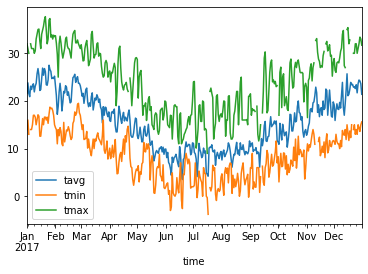

tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2017-12-27  23.6  15.0  31.0   NaN   NaN   NaN  15.0   NaN  1015.8   NaN
2017-12-28  24.4  14.4  32.0   0.0   NaN   NaN  14.0   NaN  1014.4   NaN
2017-12-29  24.2  13.6  33.4   0.0   NaN   NaN  14.0   NaN  1013.5   NaN
2017-12-30  23.6  15.0  33.0   0.0   NaN   NaN  16.0   NaN  1014.3   NaN
2017-12-31  21.4  15.6  31.7   0.0   NaN   NaN  14.8   NaN  1014.1   NaN

In [10]:
#Se logró traer datos climáticos usando meteostat
from datetime import datetime
from meteostat import Point, Daily

# Mismo período de datos de 
start = datetime(2017, 1, 1)
end = datetime(2017, 12, 31)

# Create Point for SCL aeropuerto
SCL = Point(-33.3881063460988, -70.79442620963134) #from Gmaps: Airport Comodoro Arturo Merino Benitez


# Get daily data for 2017
metdata = Daily(SCL, start, end)
metdata = metdata.fetch()

# Plot line chart including average, minimum and maximum temperature
metdata.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()
metdata.tail()

In [11]:
# Transformación necesaria para poder unir los dataframes

metdata['Fecha']=metdata.index.to_series()
metdata['Fecha']= metdata['Fecha'].dt.date

In [12]:
#Merge del dataframe original con los datos de clima buscando coincidencias en el campo 'Fecha'

df_n=pd.merge(df_n, metdata, on='Fecha')
df_n=df_n.fillna(0)
df_n.tail()

Fecha-I  Vlo-I Ori-I Des-I Emp-I             Fecha-O  \
68201 2017-12-26 07:00:00  '203'  SCEL  SCIE   JAT 2017-12-26 07:01:00   
68202 2017-12-26 10:37:00  '251'  SCEL  SCTE   JAT 2017-12-26 10:39:00   
68203 2017-12-26 18:51:00  '255'  SCEL  SCTE   JAT 2017-12-26 19:11:00   
68204 2017-12-26 14:23:00  '281'  SCEL  SCQP   JAT 2017-12-26 14:29:00   
68205 2017-12-26 04:05:00  '301'  SCEL  SCCI   JAT 2017-12-26 04:05:00   

         Vlo-O Ori-O Des-O Emp-O  ...  tavg  tmin  tmax prcp snow wdir  wspd  \
68201  '203.0'  SCEL  SCIE   JAT  ...  21.7  13.0  30.0  0.0  0.0  0.0  16.5   
68202  '251.0'  SCEL  SCTE   JAT  ...  21.7  13.0  30.0  0.0  0.0  0.0  16.5   
68203  '255.0'  SCEL  SCTE   JAT  ...  21.7  13.0  30.0  0.0  0.0  0.0  16.5   
68204  '281.0'  SCEL  SCQP   JAT  ...  21.7  13.0  30.0  0.0  0.0  0.0  16.5   
68205  '301.0'  SCEL  SCCI   JAT  ...  21.7  13.0  30.0  0.0  0.0  0.0  16.5   

      wpgt    pres  tsun  
68201  0.0  1015.3   0.0  
68202  0.0  1015.3   0.0  
68203  0.0  1015.3   0.0  
68204  0.0  1015.3   0.0  
68205  0.0  1015.3   0.0  

[5 rows x 35 columns]

### Elección de Dataset

In [13]:
# #Defino variable a clasificar y remuevo algunas problemáticas
# target_name = "atraso_15"
# target = df2[target_name]

# #Remuevo algunas problematicas: Formato de Fecha-I no es compatible, "dif_min" y "Fecha-O" no se pueden usar poruqe no estarán disponibles para las predicciones

# data = df2.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min"]) 

In [14]:
#Definición de target y resto de data para el dataset completo 
#(los campos que se bajaron fueron haciendo pruebas de performance de los algoritmos, importancia den RF y posibles redundancia de información

target_name = "atraso_15"
target = df_n[target_name]

#Primero removimos las variables que no era posible usar, Luego las que eran menos importantes usando Random Forest, y luego aquellas redundantes entre si
# data = df_n.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min"])
data = df_n.drop(columns=[target_name, "Fecha-I", "Fecha-O", "dif_min", "TIPOVUELO", "wdir", "Cambio_destino", 
                          "AÑO", "Ori-O","snow", "Ori-I", "wpgt", "SIGLAORI","tsun", 'Vlo-O', 'tmin', 'tmax', 'Emp-O',
                          'DIA', 'MES', 'SIGLADES', 'OPERA', 'temporada_alta', 'prcp', 'tavg', 'Des-O'])

In [15]:
# Separo test y training set (default value es 25% - 75%)

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)


<a id='sectionpdm'></a>
### Pipeline de Datos y Modelado

#### Pipeline para Multi-layer Perceptron, SVM y Logistic Regressions (OneHotEncoder y estandarización)

In [16]:
# Segregación de variables númericas y categóricas según el dataframe que ingreso

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [17]:
# Defino tipo de procesamiento de datos

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [18]:
# Defino el preprocesador

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [19]:
#Creo Pipline elijiendo el algoritmo (se puede habilitar o no SMOTE)

#Para usar smote simplemnte agredo sm en make_pipeline luedo de prepocessor

sm = SMOTE(random_state=42) 

#Multi-layer Perceptron

clf_nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
model_nn = make_pipeline(preprocessor, sm, clf_nn)

#Logisitic Regression

model_lr = make_pipeline(preprocessor, sm, LogisticRegression(max_iter=500))

#Support Vector Classification

model_svm = make_pipeline(preprocessor, sm, svm.SVC(kernel='linear'))



In [20]:
%%time

#Entrenamiento Multi-layer Perceptron

_ = model_nn.fit(data_train, target_train)


#Vizualización del Pipeline

set_config(display='diagram')
model_nn



Wall time: 9.55 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vlo-I', 'Des-I', 'Emp-I',
                                                   'DIANOM', 'periodo_dia',
                                                   'Fecha']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Hora', 'wspd', 'pres'])])),
                ('smote', SMOTE(random_state=42)),
                ('mlpclassifier',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2),
                               random_state=1, solver='lbfgs'))])

Mean Absolute Error: 0.31538822425521934
Mean Squared Error: 0.31538822425521934
Root Mean Squared Error: 0.5615943591732554
              precision    recall  f1-score   support

           0       0.89      0.70      0.78     13862
           1       0.32      0.63      0.43      3190

    accuracy                           0.68     17052
   macro avg       0.61      0.66      0.60     17052
weighted avg       0.78      0.68      0.72     17052



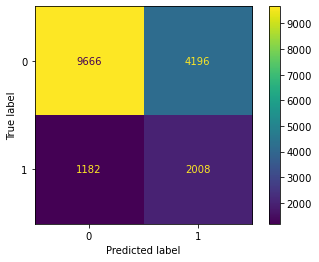

In [21]:
#Calculo las predicciones

predictions_nn = model_nn.predict(data_test)

#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_nn))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_nn))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_nn)))

print(classification_report(target_test, predictions_nn))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_nn, data_test, target_test) 
plt.show()

In [22]:
%%time

#Entrenamiento Logisitic Regression

_ = model_lr.fit(data_train, target_train)

#Vizualización del Pipeline

set_config(display='diagram')
model_lr


Wall time: 6.47 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Vlo-I', 'Des-I', 'Emp-I',
                                                   'DIANOM', 'periodo_dia',
                                                   'Fecha']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Hora', 'wspd', 'pres'])])),
                ('smote', SMOTE(random_state=42)),
                ('logisticregression', LogisticRegression(max_iter=500))])

Mean Absolute Error: 0.3076471968097584
Mean Squared Error: 0.3076471968097584
Root Mean Squared Error: 0.5546595323347092
              precision    recall  f1-score   support

           0       0.89      0.71      0.79     13862
           1       0.33      0.63      0.44      3190

    accuracy                           0.69     17052
   macro avg       0.61      0.67      0.61     17052
weighted avg       0.79      0.69      0.72     17052



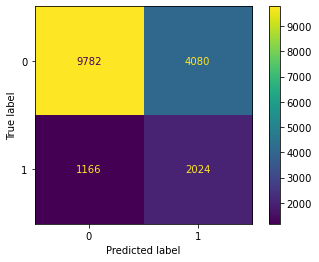

In [23]:
#Calculo las predicciones

predictions_lr = model_lr.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_lr))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_lr))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_lr)))

print(classification_report(target_test, predictions_lr))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_lr, data_test, target_test) 
plt.show()

In [24]:
# %%time
# #Entrenamiento Support Vector Classification (se deja comentado por el tiempo de corrida)
# _ = model_svm.fit(data_train, target_train)

# #Vizualización del Pipeline

# set_config(display='diagram')
# model_svm

# #Resultados corrida
# #Wall time: 4min 37s
# #0.817558057705841

In [25]:
# #Calculo las predicciones

# predictions_svm = model_svm.predict(data_test)


# #Métricas para evaluar el modelo

# print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_svm))
# print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_svm))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_svm)))

# print(classification_report(target_test, predictions_svm))
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(model_svm, data_test, target_test) 
# plt.show()

#### Pipeline para Árboles, RF y Gradient-boosting Trees (más simple: puedo usar Ordinal encoder y no necesito normalizar las variables numéricas) 

In [26]:
# Segregación de variables númericas y categóricas según el dataframe que ingreso

categorical_columns_selector = selector(dtype_include=object)


categorical_columns_2 = categorical_columns_selector(data)

In [27]:
# Defino tipo de procesamiento de datos

categorical_preprocessor_2 = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)


In [28]:
# Defino el preprocesador

preprocessor_2 = ColumnTransformer([
    ('categorical', categorical_preprocessor_2, categorical_columns_2)],
    remainder="passthrough")


In [29]:
#Creo Pipline elijiendo el algoritmo (se puede habilitar o no SMOTE)

#Para usar SMOTE simplemnte agredo sm en make_pipiline luedo de prepocessor

sm = SMOTE(random_state=42)

# Gradient-boosting Trees

clf_gb=HistGradientBoostingClassifier()
model_gb = make_pipeline(preprocessor_2, clf_gb)

# Decision Tree simple

clf_dt=DecisionTreeClassifier(random_state=25)
model_dt = make_pipeline(preprocessor_2,sm, clf_dt)

# Random Forest

clf_rf=RandomForestClassifier(n_estimators=100)
model_rf = make_pipeline(preprocessor_2, clf_rf)


In [30]:
%%time

#Entrenamiento Gradient-boosting Trees

_ = model_gb.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_gb.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_gb

Wall time: 816 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Vlo-I', 'Des-I', 'Emp-I',
                                                   'DIANOM', 'periodo_dia',
                                                   'Fecha'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

Mean Absolute Error: 0.1743490499648135
Mean Squared Error: 0.1743490499648135
Root Mean Squared Error: 0.41755125429677914
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     13862
           1       0.66      0.14      0.23      3190

    accuracy                           0.83     17052
   macro avg       0.75      0.56      0.57     17052
weighted avg       0.80      0.83      0.78     17052



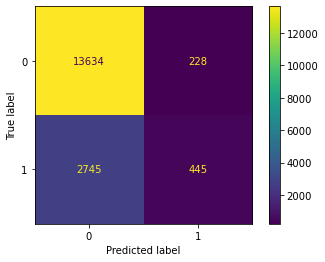

In [31]:
#Calculo las predicciones

predictions_gb = model_gb.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_gb))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_gb))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_gb)))

print(classification_report(target_test, predictions_gb))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_gb, data_test, target_test) 

plt.show()

In [32]:
%%time

#Entrenamiento Decision Tree simple

_ = model_dt.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_dt.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_dt

Wall time: 764 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Vlo-I', 'Des-I', 'Emp-I',
                                                   'DIANOM', 'periodo_dia',
                                                   'Fecha'])])),
                ('smote', SMOTE(random_state=42)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=25))])

Mean Absolute Error: 0.26425052779732583
Mean Squared Error: 0.26425052779732583
Root Mean Squared Error: 0.5140530398677998
              precision    recall  f1-score   support

           0       0.85      0.82      0.83     13862
           1       0.32      0.37      0.34      3190

    accuracy                           0.74     17052
   macro avg       0.58      0.59      0.59     17052
weighted avg       0.75      0.74      0.74     17052



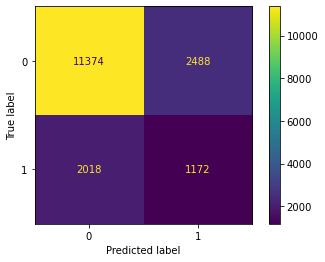

In [33]:
#Calculo las predicciones

predictions_dt = model_dt.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_dt))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_dt))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_dt)))

print(classification_report(target_test, predictions_dt))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_dt, data_test, target_test) 
plt.show()

In [34]:
%%time

#Entrenamiento Random Forest

_ = model_rf.fit(data_train, target_train)

# Accuracy, uso cómo métrica por default para comparaciones rápidas

model_rf.score(data_test, target_test)

#Vizualización del Pipeline

set_config(display='diagram')
model_rf

Wall time: 7.22 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Vlo-I', 'Des-I', 'Emp-I',
                                                   'DIANOM', 'periodo_dia',
                                                   'Fecha'])])),
                ('randomforestclassifier', RandomForestClassifier())])

### Evaluacion_RF

Mean Absolute Error: 0.18191414496833216
Mean Squared Error: 0.18191414496833216
Root Mean Squared Error: 0.426513944635263
              precision    recall  f1-score   support

           0       0.84      0.96      0.90     13862
           1       0.54      0.21      0.30      3190

    accuracy                           0.82     17052
   macro avg       0.69      0.58      0.60     17052
weighted avg       0.78      0.82      0.78     17052



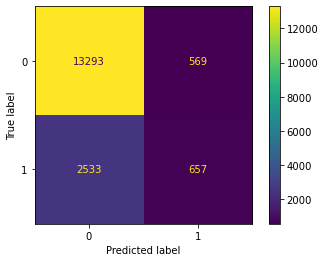

In [35]:
#Calculo las predicciones

predictions_rf = model_rf.predict(data_test)


#Métricas para evaluar el modelo

print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_rf))
print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_rf)))

print(classification_report(target_test, predictions_rf))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model_rf, data_test, target_test) 
plt.show()

### Feature Selection

In [36]:
#Orden de importancia de variables según RF, y agregado de nombres traídos del pipeline

feature_imp = pd.Series(clf_rf.feature_importances_, index=model_rf[:-1].get_feature_names_out()).sort_values(ascending=False)
feature_imp


categorical__Fecha          0.185848
categorical__Vlo-I          0.172107
remainder__wspd             0.134540
remainder__pres             0.127450
categorical__Des-I          0.114919
remainder__Hora             0.113640
categorical__DIANOM         0.076461
categorical__Emp-I          0.051621
categorical__periodo_dia    0.023414
dtype: float64

No handles with labels found to put in legend.


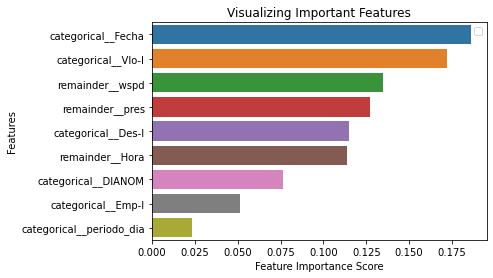

In [37]:
# Gráfico de importancia de variables según RF

sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Hyper Parameter tunning para RF

In [38]:
%%time
# Random Forest hyperparameter tuning (se deja comentado por el tiempo de cálculo que toma)

clf_rfh=RandomForestClassifier()
model_rfh = make_pipeline(preprocessor_2, sm, clf_rfh)
pipe_params = {
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__n_estimators": [100, 500, 1000],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "randomforestclassifier__max_features": ['auto', 'sqrt'],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
    "randomforestclassifier__min_samples_leaf": [1, 2, 4],
}

# gridsearch = GridSearchCV(
#     model_rfh, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1000
# )
rf_random = RandomizedSearchCV(model_rfh, param_distributions = pipe_params, n_iter = 25, scoring='f1_macro', cv = 3, verbose=2, random_state=42, n_jobs = -1)

#rf_random.fit(data_train, target_train)

Wall time: 0 ns


In [39]:
# rf_random.best_params_

In [40]:
# #Métricas para evaluar el modelo 

# optimised_random_forest = rf_random.best_estimator_
# predictions_rfh = optimised_random_forest.predict(data_test)
# f1_score(target_test,predictions_rfh, average='macro')

# print('Mean Absolute Error:', metrics.mean_absolute_error(target_test, predictions_rfh))
# print('Mean Squared Error:', metrics.mean_squared_error(target_test, predictions_rfh))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(target_test, predictions_rfh)))

# print(classification_report(target_test, predictions_rfh))
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(optimised_random_forest, data_test, target_test) 
# plt.show()

## Ejercicio 5: Resumen y pasos a seguir
5.Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la performance?
  
  
Las pruebas preliminares mostraron que el desbalance en el dataset hace que se obtenga una Accuracy razonable, pero que esconde un f1 score muy bajo para la predicción de casos positivos (atraso_15). Mirando la salida de la evaluación de modelos (por ejemplo ver [Evaluacion_RF](#Evaluacion_RF)), se llegó a la conclusión que la mejor metrica para este estudios es 'f1-score macro avg', ya que el mismo no esconde el problema de desbalance y le da un peso similar a las predicciones positivas y negativas, sin embargo no siempre es bueno tener la Accuaracy total como referencia.
Por esto en el resumen de [Tabla_1](#Tabla_1) se pueden ver las columnas, Accuracy, f1-0 (f1-score para no atrasos), f1-1 (f1-score para atrasos), f1-macro (promedio entre estos valores).
En esta tabla podemos observar:
- Que el modelo con mayor f1-macro es obtenido usando el dataset que incluye todas las variables para el algoritmo RF.
- Que las variables adicionales mejoraron marginalmente los resultados (celdas marcadas con celeste)
- El uso de SMOTE (Synthetic Minority Over-sampling Technique, disponible en la librería imbalanced-learn) mejora f1-1 (ver celdas marcadas con verde), y si bien deteriora levemente f1-0, el resultado final es una mejora en f1-macro.(SMOTE fue añadido en el Pipelline de datos, lo que hace muy simple su uso activación o desactivación)
- Cuando se hizo la selección de variables, al pasar de 22 a 9 variables no hubo cambios significativos en los resultados
- La prueba de Hyper Parameter Tunning no mejoró en absoluto el algoritmo encontrado. Esto de alguna forma era previsible al ver que usando algoritmos de distinta naturaleza los resultados eran similares, ya que indica que el problema de ajuste estaría en la base de datos y no en el método de ajuste elegido.

En resumidas cuantas, ninguna de las pruebas que se hicieron en el tiempo acotado de este Challenge dieron resultados que se puedan considerar aceptables, habiendo aún muchos falsos negativos, lo que llevan a un recall de positivos bajo (aún para el mejor modelo encontrado) que resulta en un f1-1 bajo.

Random Forest no solo fue elegido por los resultados, sino por su habilidad de evaluar la magnitud de la influencia de las variables en el modelo como se puede ver en Fig. 1 y Fig. 2.
Además, para modelos basados en árboles, el manejo de variables numéricas y categóricas es más simple, no siendo necesario escalar las características numéricas, y permitiendo el uso de codificación ordinal para las variables categóricas, incluso cuando esta codificación da como resultado un orden arbitrario.

Las variables originales, más las calculadas y obtenidas, cómo se explicó en el Ejercicio 4, con mayor influencia se pueden ver en la Fig 2. donde las más importantes son las de la parte superior del gráfico y disminuyen en importancia a medida hacia abajo.

Posibles pasos a seguir para mejorar la performance (si bien hay muchas cosas para hacer, es aconsejable empezar por aquellas que mejoren el dataset):  
  
-Evaluar los datos con una Learning Curve, esto es algo simple y puede ser muy útil para entender el si el origen de nuestra falta de performance se encuentra en los datos y orientarnos hacia donde estaría el problema. Se podría usar está página para empezar: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

-Si bien se probó SMOTE, se podrías probar otros métodos de balanceo disponibles en imbalanced-learn, o quizás probar algo más simple como random under-sampling (esto tiene la desventaja de tener que descartar datos)
  
-Probar cambiando el criterio de atraso, ya que el gráfico en [Histograma_de_dif_min](#Histograma_de_dif_min), muestra que si se baja el corte de 15 minutos, tendremos muchos más casos de atrasos, lo que ayudará a balancear la base de datos, lo que podría cambiar significativamente los resultados (claro que esto debe ser consultado con el usuario final de la solución para ver si encuentra aceptable este cambio)

-Tratar de identificar si existen algunas sub-categorías en el dataset que sean particularmente difíciles de predecir por contener demasiado ruido  

-Buscar/calcular aún más variables: distancias a las ciudades de destino, parámetros de dimensión/congestión/número de vuelos o tamaño de los aeropuertos de destino. Además, quizás tratar clasificar los vuelos según los fabricantes de las aeronaves, quizás haya alguna relación con la cantidad de atrasos por mantenimiento o algo similar.
  
-Intentar con un ensamble de algoritmos, para esto se aconseja usar AutoML como por ejemplo H2O usando este código: https://h2oai.github.io/tutorials/introduction-to-machine-learning-with-h2o-3-automl/#5   
  
-Continuar con las pruebas de tuneo/optimización  de hiperparámetros, si bien las pruebas preliminares fueron desalentadoras, estas fueron acotadas por cuestiones de tiempo. 
   
-Por último, se puede intentar probar otros métodos de feature selection  (aunque no parece este ser el origen del problema)


### Tabla_1
![title](img/tabla1.png)


<a id='sectionacpbi'></a>
## Análisis Capturas PowerBI


- Primero podemos ver como los datos desplegados en un mapa, muestran claramente las rutas de las distintas aerolíneas. El caso de la primer captura es para los vuelos internacionales del Grupo LATAM.  
- También seleccionando los filtros se puede elegir ver solo las rutas nacionales para todos los operadores como el ejemplo de la segunda captura.  
  
- La siguiente captura muestra un Diagrama de Sankey donde por ejemplo podemos ver para los vuelos internacionales el Destino programado respecto al de operación. Se puede ver a simple vista que en ciertos casos, como el marcado con el cursor, hay cambios de destino. Esta información pude llegar a ser relevante para las predicciones y llevó a calcular una variable adicional que finalmente no resulto importante.  
  
- Treemap complementa lo que ya vimos en [Pie_charts_elegidos](#Pie_charts_elegidos) mostrando la cantidad de Números de vuelo por Operador y Empresa. Si cada número de vuelo coincidiera con una aeronave distinta, estos números nos darían un buen indicio del tamaño de las distintas flotas que operan en SCEL.  
  
- Por último en el gráfico más interesante, vemos las Series Temporales de la cantidad de vuelos en función del tiempo para el caso de vuelos Nacionales (arriba) e Internacionales (abajo). Se puede apreciar que en los dos casos hay una cierta estacionalidad que aparentemente es semanal. Pero lo más interesante es que son marcadamente distintas. 
Para poder hacer esto más visible se usó el algoritmo Holt-Winters exponential smoothing disponible en PowerBI. Con el cual podemos apreciar en las predicciones marcadas en negro, que efectivamente hay estacionalidad y que es marcadamente distinta en las dos categorías. Para hacerlo aún más evidente se graficó la cantidad de vuelos totales por DIANOM, donde se ve que los días con mayor cantidad de vuelos difiere entre las categorías.  
En resumen se evidencia un comportamiento temporal claramente distinto entre vuelos I y N. Considerando además, que al final de cuentas, lo que estamos tratando de hacer es predecir comportamientos futuros analizando comportamientos pasados en los datos. Surge algunos importantes interrogantes:  Mejorarían estas predicciones si separamos los datos en I y N, y usamos un algoritmo para cada grupo de datos? De ser así habría que probar haciendo otras segregaciones adicionales? Habría que pensar en algoritmos específicos para ciertas categorías?

Comentario:  
Al jugar con los datos cambiando distintos filtros/categorías muy rápidamente, y haciendo una gran cantidad de pruebas en un corto tiempo en PowerBI. Se dispararon interrogantes para tratar de responder usando Python, ya que es una herramienta más apropiada para análisis más profundos.



### Capturas_PowerBI
  
  
Mapa vuelos Internacionales:  

![title](img/PBI1.png)  

Mapa vuelos Nacionales:  

![title](img/PBI2.png)

Sankey:

![title](img/PBI3.png)

Treemap:  

![title](img/PBI4.png)

Series Temporales Nacionales e Internacionales:    

![title](img/PBI5_N.png)
![title](img/PBI5_I.png)



<a id='sectionacpbi2'></a>
## Análisis Capturas PowerBI 2

Haciendo pruebas en PowerBI encontramos una relación muy interesante entre la suma de dif_min y la cantidad de vuelos por hora, ya que parece que hay una marcada relación entre estas (ver primer gráfico en [Capturas_PowerBI_2](#Capturas_PowerBI_2) . Por lo que se hizo el segundo gráfico donde se observa que efectivamente hay una marcada correlación con un coeficiente de 0.92. Luego se revisaron las correlaciones de dif_min con DIANOM, Día, y Mes, encontrando correlaciones altas en todos los casos. Y esto es aún más marcado usando ciertos filtros, como el ejemplo del ultimo gráfico con solo con vuelos internacionales del Grupo LATAM.  
  
Estos resultados deben ser tomados con precaución, ya que existe la posibilidad de que las correlaciones sean provocadas por el muestreo de datos usado. Es decir, si la suma de dif_min aumenta con el numero de muestras tomadas y la cantidad de vuelos también, puede que solo estemos observando esto y no una correlación entre estas. Por lo tanto esto debe ser tomado meramente como un indicio. Pero estaría mostrando que tiene sentido probar la nueva variable Hora, para ver si tiene influencia en las predicciones. Por esto, se agregó al dataset esta variable y resultó de alta importancia como se evidencia en la [Fig. 2](#sectionf1), siendo la tercera en importancia según los resultados de RF.
  
Comentario: Si bien, este análisis no se puede hacer usando la variable a predecir atraso_15, esta está directamente relacionada con dif_min. Dicho de otra forma, si ajustamos un árbol de decisión usando dif_min tendríamos una Accuracy del 1, por lo que si podemos predecir dif_min indirectamente estaríamos prediciendo atraso_15.
Por este motivo  DIANOM, Día, y MES sean variables importante en la predicción de atraso_15, y seguramente haya un cierto solapamiento entre algunas de estas por codificar información relacionada. 

### Capturas_PowerBI_2
  
Suma dif_min y cantidad de vuelos vs hora para todo el dataset

![title](img/PBI6.png)  

Suma dif_min vs cantidad de vuelos por hora para todo el dataset  

![title](img/PBI7.png)

Correlaciones de suma de dif_min vs vs cantidad de vuelos por hora, DANOM, Día, y Mes para todo el dataset

![title](img/PBI8.png)

Ídem anterior solo para vuelos internacionales del Grupo LATAM 

![title](img/PBI9.png)

## Comentarios Adicionales

Primero que nada agradezco la oportunidad de resolver el ejercicio, ya que el proceso ha sido muy entretenido.

Con la intención de estos comentarios les sean útiles, hago algunas observaciones.
Teniendo en cuenta que un proyecto de Data Science, abre un abanico inmenso de posibilidades que si bien luego se acotan al ver el caso en particular, la cantidad de pruebas y formas de analizar los datos es enorme. No habiendo una única receta para resolver un problema, de lo contrario estaríamos frente a un problema de ingeniería y no ciencia, les puedo hacer las siguientes recomendaciones/oportunidades de mejora:
- Me parece que el tiempo necesario para hacer una buena evaluación del caso es excesiva, por lo que dejaría más claro hasta donde se pretende que el evaluado llegue con sus análisis, quizás se puede hacer algunas preguntas más específicas para orientar en este sentido y/o evaluar el entendimiento en algún tema en particular.
- Siendo que el marco global del ejercicio es la predicción de una variable. El enunciado del punto 1 lleva a pensar que se pretende un análisis de cómo la distribución de los datos termina impactando en dicha predicción. Como mencioné en la resolución de este ejercicio, supuse que la intención es que se haga una exploración preliminar y visualización de los datos sin limitarse al problema de predicción. Si esto efectivamente es así, es aconsejable dejarlo claro en el enunciado. 
- El punto 3 parece llevar a tomar conclusiones respecto a qué variables son influyentes mirando únicamente la tase de atraso, lo que puede llevar a errores, tal como se mencionó en la resolución de dicho ejercicio.


## Apendice

In [41]:
#revisemos las información que nos brinda pandas sobre el tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha-I         68206 non-null  datetime64[ns]
 1   Vlo-I           68206 non-null  object        
 2   Ori-I           68206 non-null  object        
 3   Des-I           68206 non-null  object        
 4   Emp-I           68206 non-null  object        
 5   Fecha-O         68206 non-null  datetime64[ns]
 6   Vlo-O           68206 non-null  object        
 7   Ori-O           68206 non-null  object        
 8   Des-O           68206 non-null  object        
 9   Emp-O           68206 non-null  object        
 10  DIA             68206 non-null  int64         
 11  MES             68206 non-null  int64         
 12  AÑO             68206 non-null  int64         
 13  DIANOM          68206 non-null  object        
 14  TIPOVUELO       68206 non-null  object        
 15  OP

In [42]:
#descriptive statistics summary variables numérricas
df.describe()

DIA           MES           AÑO  temporada_alta       dif_min  \
count  68206.000000  68206.000000  68206.000000    68206.000000  68206.000000   
mean      15.714790      6.622585   2017.000029        0.333724      9.110855   
std        8.782886      3.523321      0.005415        0.471546     19.313387   
min        1.000000      1.000000   2017.000000        0.000000    -14.000000   
25%        8.000000      3.000000   2017.000000        0.000000     -1.000000   
50%       16.000000      7.000000   2017.000000        0.000000      4.000000   
75%       23.000000     10.000000   2017.000000        1.000000     12.000000   
max       31.000000     12.000000   2018.000000        1.000000    161.000000   

          atraso_15  Cambio_destino         Hora  
count  68206.000000    68206.000000  68206.00000  
mean       0.184940        0.000411     12.46125  
std        0.388252        0.020257      5.80101  
min        0.000000        0.000000      0.00000  
25%        0.000000        0.000000      8.00000  
50%        0.000000        0.000000     13.00000  
75%        0.000000        0.000000     17.00000  
max        1.000000        1.000000     23.00000

In [43]:
#descriptive statistics summary para variables categóricas
df[['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES']].describe()

Fecha-I  Vlo-I  Ori-I  Des-I  Emp-I              Fecha-O  \
count                 68206  68206  68206  68206  68206                68206   
unique                53252    584      1     64     30                62774   
top     2017-07-28 13:30:00  '174'   SCEL   SCFA    LAN  2017-11-05 14:51:00   
freq                      6    686  68206   5787  37611                    5   
first   2017-01-01 00:15:00    NaN    NaN    NaN    NaN  2017-01-01 00:04:00   
last    2017-12-31 23:55:00    NaN    NaN    NaN    NaN  2018-01-01 00:12:00   

        Vlo-O  Ori-O  Des-O  Emp-O   DIANOM TIPOVUELO        OPERA  SIGLAORI  \
count   68206  68206  68206  68206    68206     68206        68206     68206   
unique    862      1     63     32        7         2           23         1   
top     '174'   SCEL   SCFA    LAN  Viernes         N  Grupo LATAM  Santiago   
freq      649  68206   5786  20988    10292     36966        40892     68206   
first     NaN    NaN    NaN    NaN      NaN       NaN          NaN       NaN   
last      NaN    NaN    NaN    NaN      NaN       NaN          NaN       NaN   

            SIGLADES  
count          68206  
unique            62  
top     Buenos Aires  
freq            6335  
first            NaN  
last             NaN

In [44]:
#Una primera mirada de los datos
df.head()

Fecha-I  Vlo-I Ori-I Des-I Emp-I             Fecha-O  Vlo-O  \
0 2017-01-01 23:30:00  '226'  SCEL  KMIA   AAL 2017-01-01 23:33:00  '226'   
1 2017-01-02 23:30:00  '226'  SCEL  KMIA   AAL 2017-01-02 23:39:00  '226'   
2 2017-01-03 23:30:00  '226'  SCEL  KMIA   AAL 2017-01-03 23:39:00  '226'   
3 2017-01-04 23:30:00  '226'  SCEL  KMIA   AAL 2017-01-04 23:33:00  '226'   
4 2017-01-05 23:30:00  '226'  SCEL  KMIA   AAL 2017-01-05 23:28:00  '226'   

  Ori-O Des-O Emp-O  ...              OPERA  SIGLAORI  SIGLADES  \
0  SCEL  KMIA   AAL  ...  American Airlines  Santiago     Miami   
1  SCEL  KMIA   AAL  ...  American Airlines  Santiago     Miami   
2  SCEL  KMIA   AAL  ...  American Airlines  Santiago     Miami   
3  SCEL  KMIA   AAL  ...  American Airlines  Santiago     Miami   
4  SCEL  KMIA   AAL  ...  American Airlines  Santiago     Miami   

  temporada_alta dif_min atraso_15 periodo_dia Cambio_destino       Fecha  \
0              1     3.0         0       noche              0  2017-01-01   
1              1     9.0         0       noche              0  2017-01-02   
2              1     9.0         0       noche              0  2017-01-03   
3              1     3.0         0       noche              0  2017-01-04   
4              1    -2.0         0       noche              0  2017-01-05   

   Hora  
0    23  
1    23  
2    23  
3    23  
4    23  

[5 rows x 25 columns]

In [45]:
df.tail()

Fecha-I  Vlo-I Ori-I Des-I Emp-I             Fecha-O  \
68201 2017-12-22 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-22 15:41:00   
68202 2017-12-25 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-25 15:11:00   
68203 2017-12-27 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-27 15:35:00   
68204 2017-12-29 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-29 15:08:00   
68205 2017-12-31 14:55:00  '400'  SCEL  SPJC   JAT 2017-12-31 15:04:00   

         Vlo-O Ori-O Des-O Emp-O  ...         OPERA  SIGLAORI  SIGLADES  \
68201  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68202  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68203  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68204  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   
68205  '400.0'  SCEL  SPJC   JAT  ...  JetSmart SPA  Santiago      Lima   

      temporada_alta dif_min atraso_15 periodo_dia Cambio_destino       Fecha  \
68201              1    46.0         1       tarde              0  2017-12-22   
68202              1    16.0         1       tarde              0  2017-12-25   
68203              1    40.0         1       tarde              0  2017-12-27   
68204              1    13.0         0       tarde              0  2017-12-29   
68205              1     9.0         0       tarde              0  2017-12-31   

       Hora  
68201    14  
68202    14  
68203    14  
68204    14  
68205    14  

[5 rows x 25 columns]

In [46]:
#Porcentaje de vuelos según aerolínea
df['Emp-O'].value_counts(normalize = True)*100

LAN    30.771486
LXP    21.344163
SKU    20.962965
TAM     4.465883
ARG     2.853121
CMP     2.712371
JMR     2.414744
LPE     1.779902
JAT     1.605431
AVA     1.297540
GLO     1.181714
AAL     1.109873
ACA     0.828373
DSM     0.722810
LNE     0.548339
IBE     0.530745
AFR     0.524881
DAL     0.524881
LRC     0.523414
AMX     0.514617
UAL     0.491159
ONE     0.409055
AZA     0.379732
KLM     0.368003
LAP     0.321086
BAW     0.300560
QFA     0.285899
AUT     0.112893
PUE     0.071841
56R     0.024924
48O     0.014661
TPU     0.002932
Name: Emp-O, dtype: float64

In [47]:
#Número de vuelos por código de vuelo
df['Vlo-O'].value_counts()

'174'      649
'11'       646
'116'      608
'150'      517
'704'      514
          ... 
'1052'       1
'1051'       1
'1050'       1
'356'        1
'180.0'      1
Name: Vlo-O, Length: 862, dtype: int64

### Pie_charts

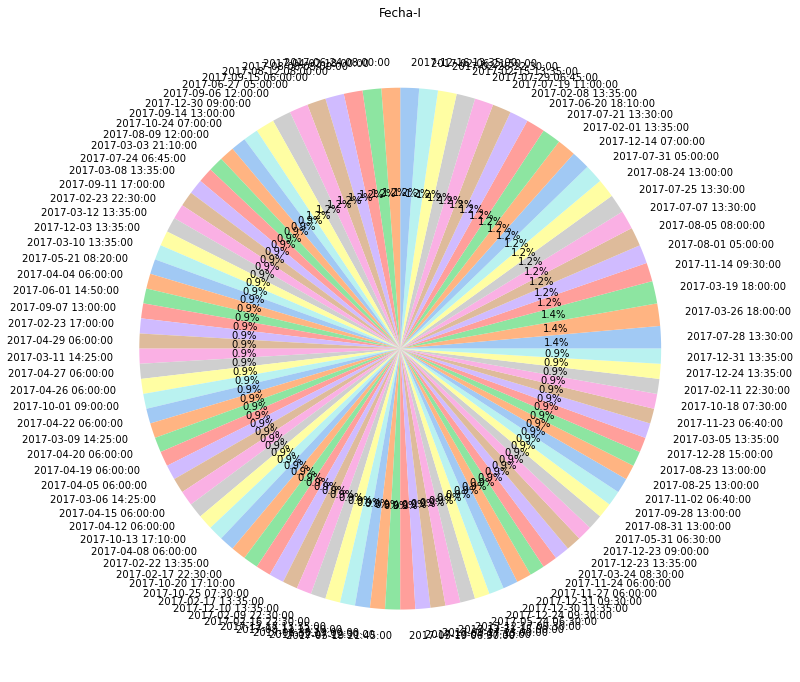

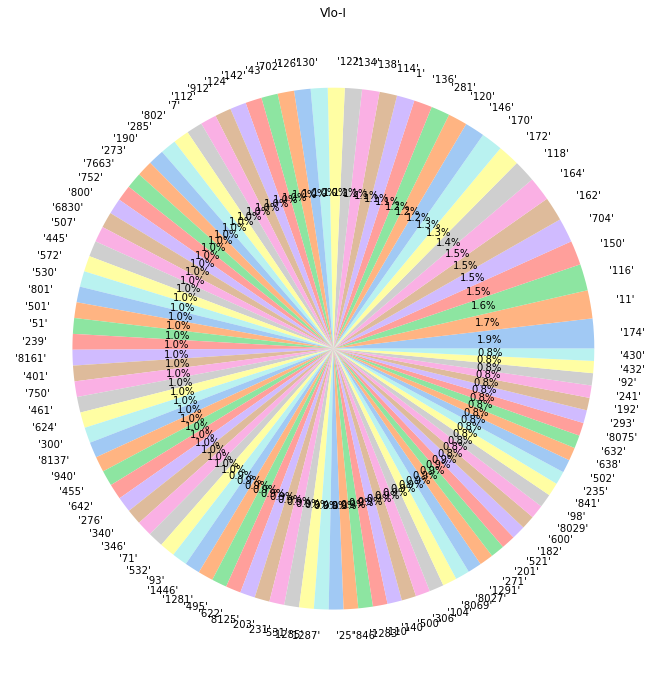

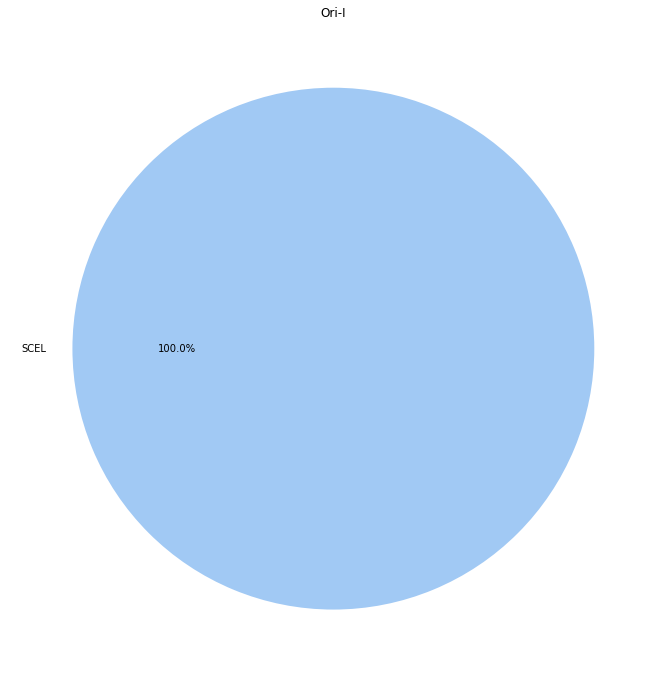

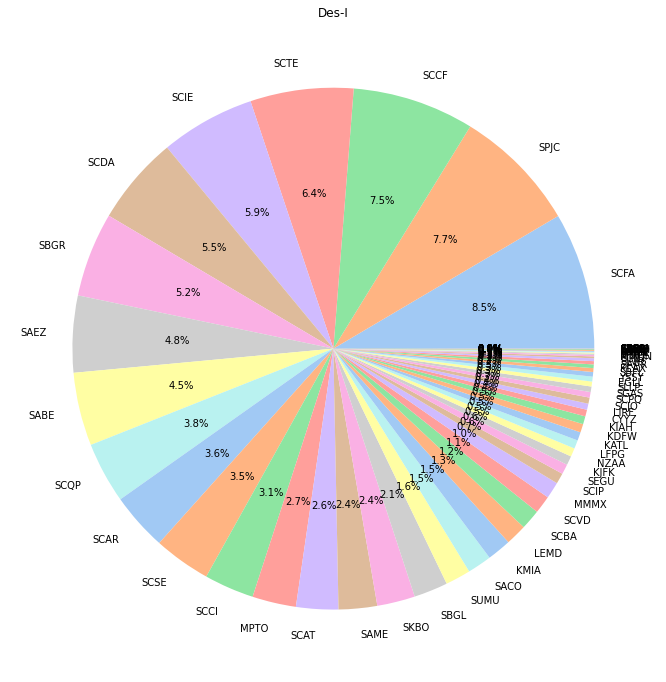

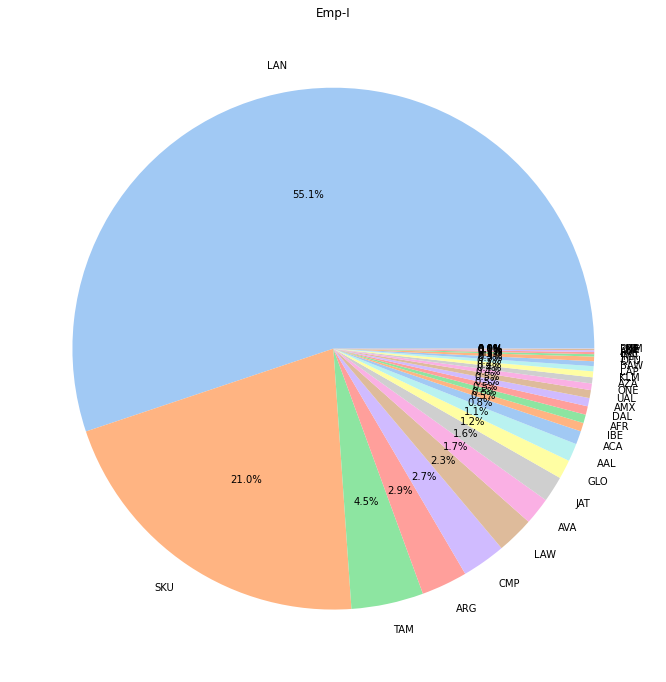

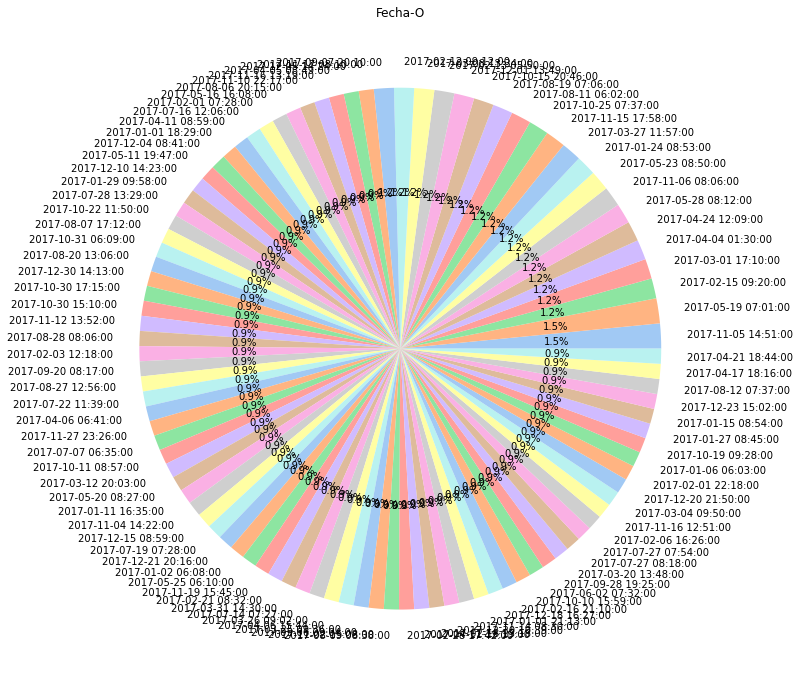

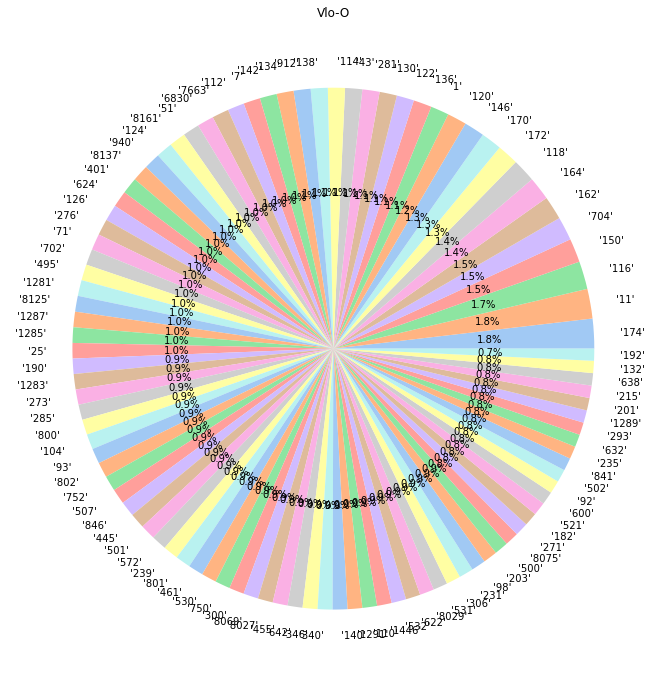

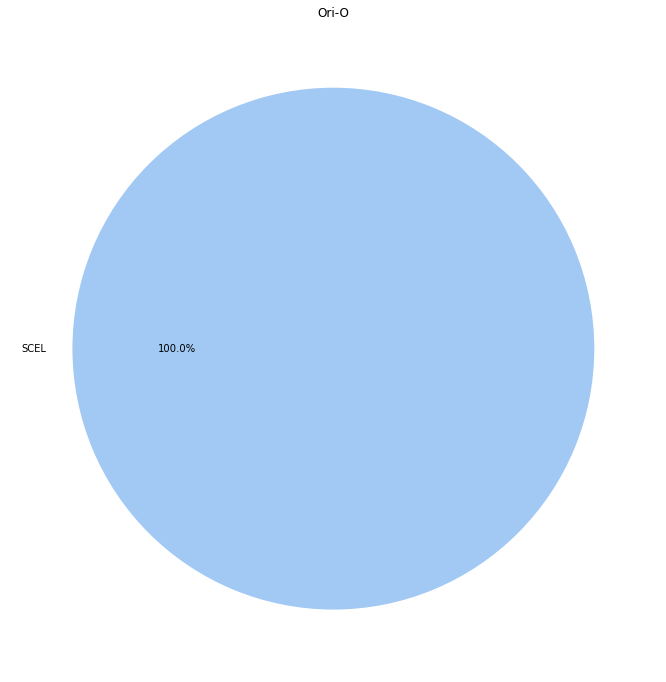

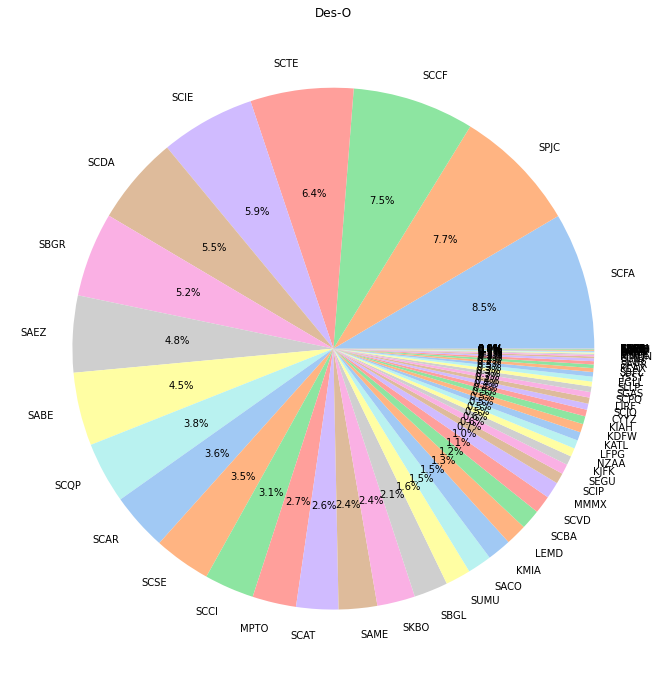

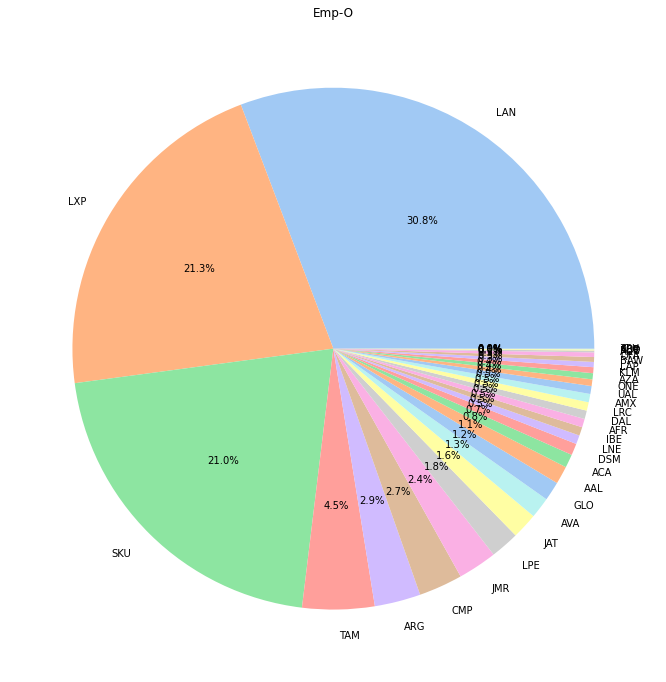

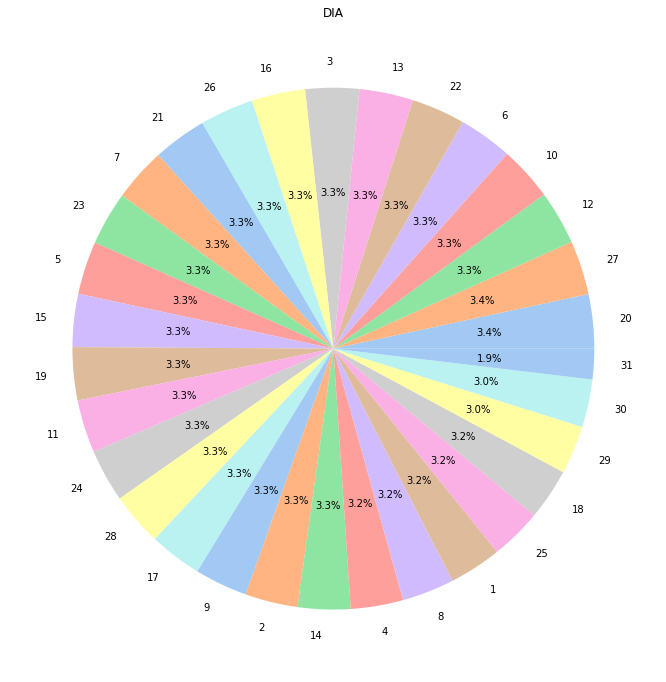

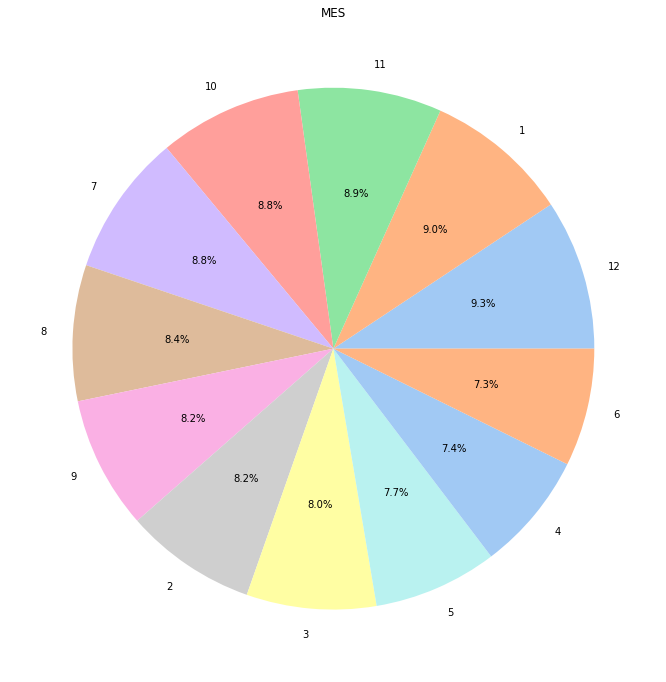

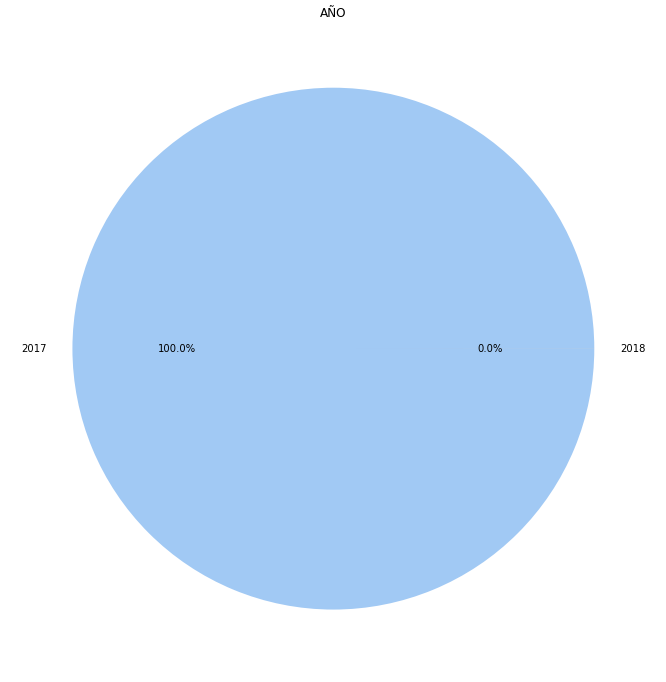

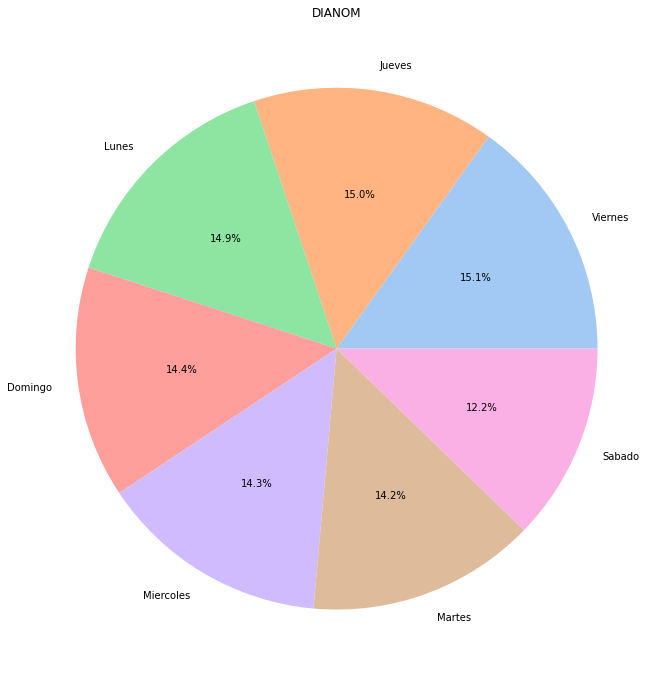

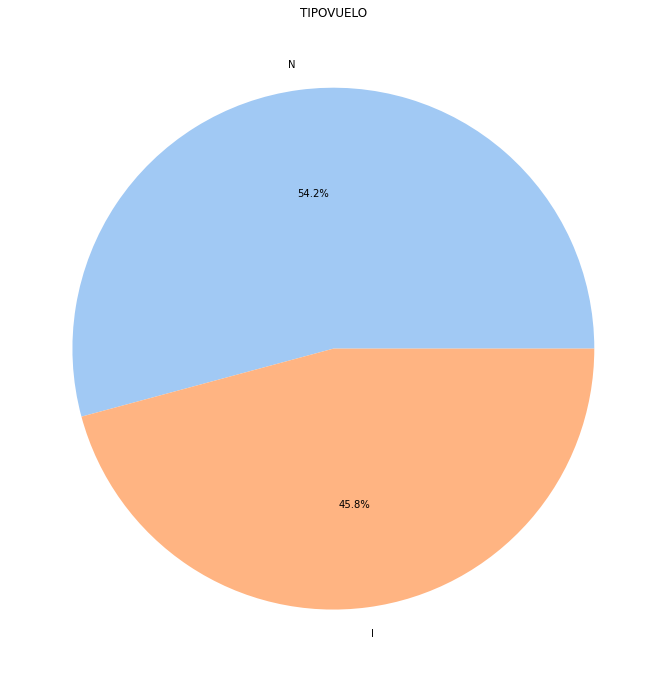

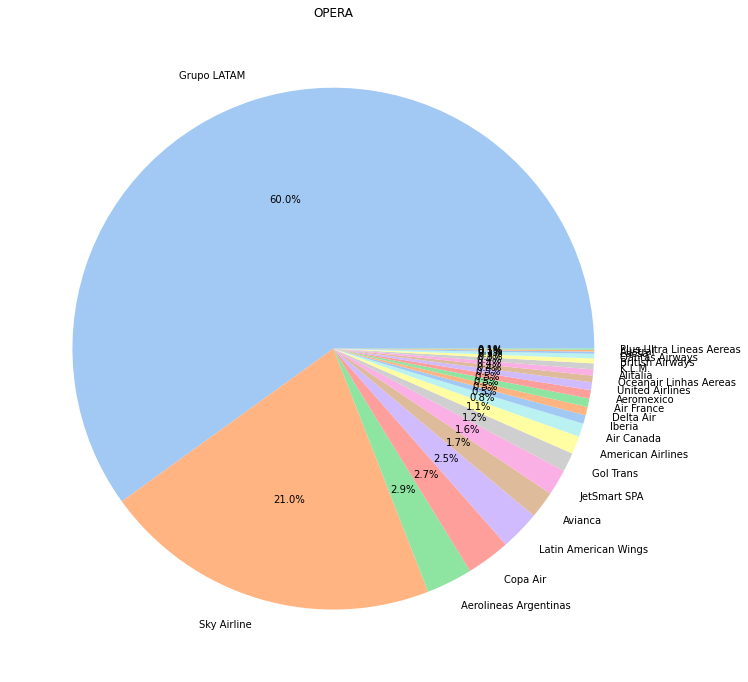

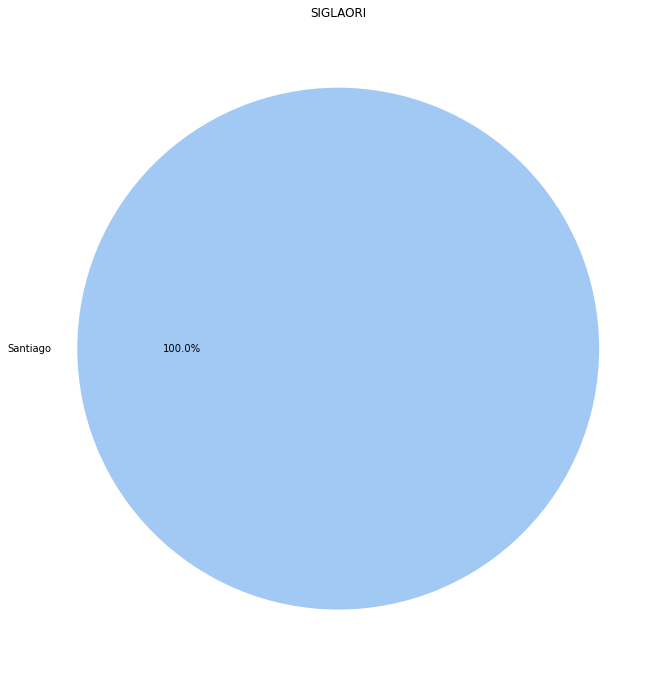

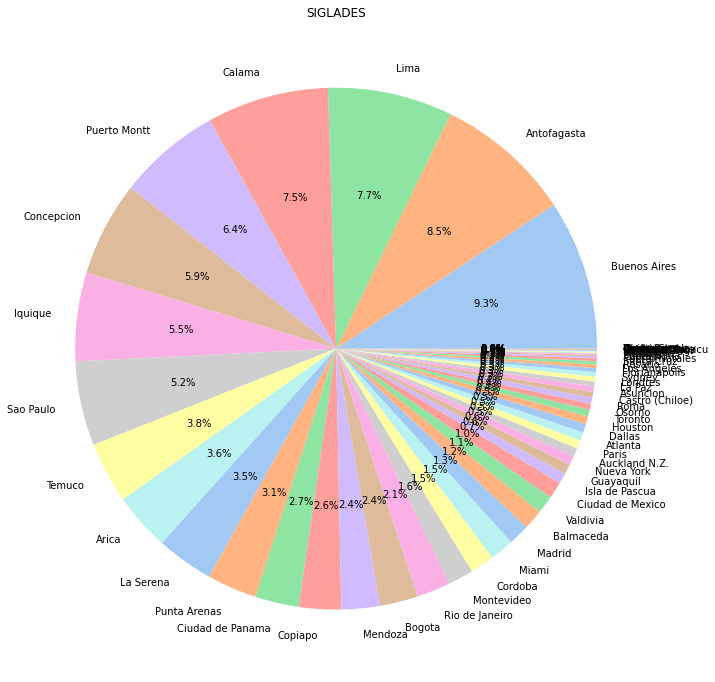

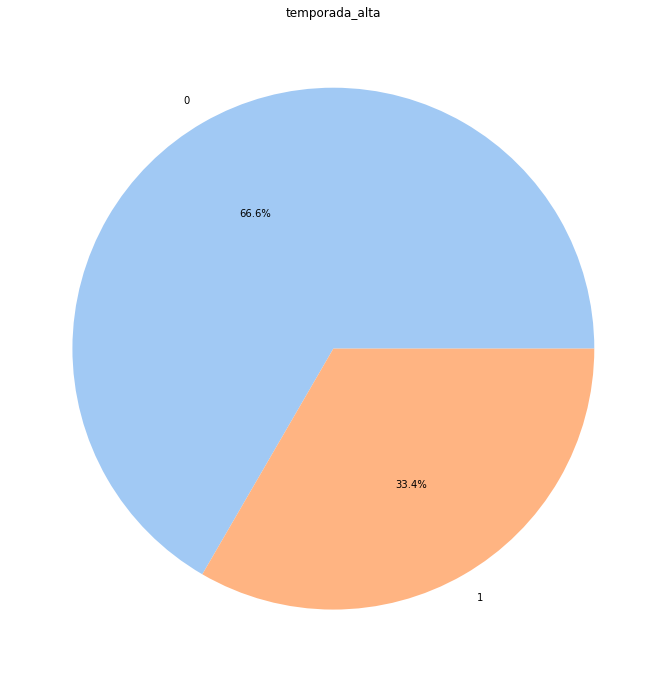

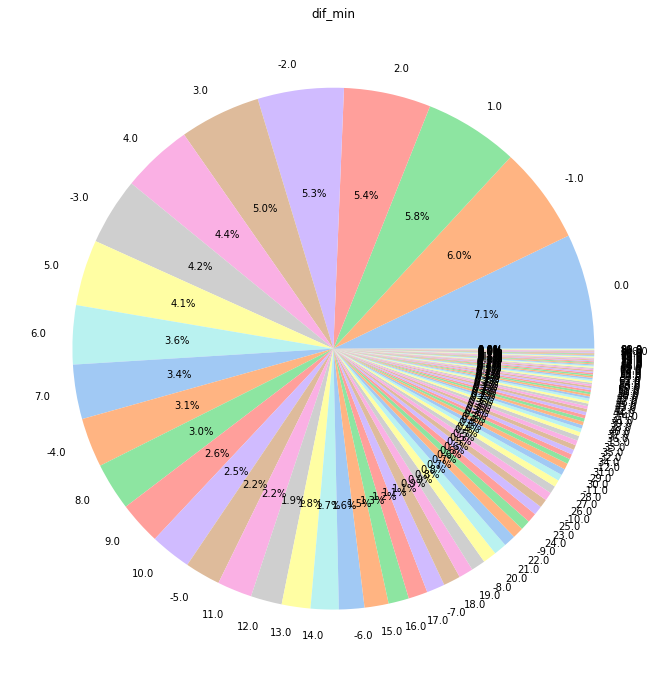

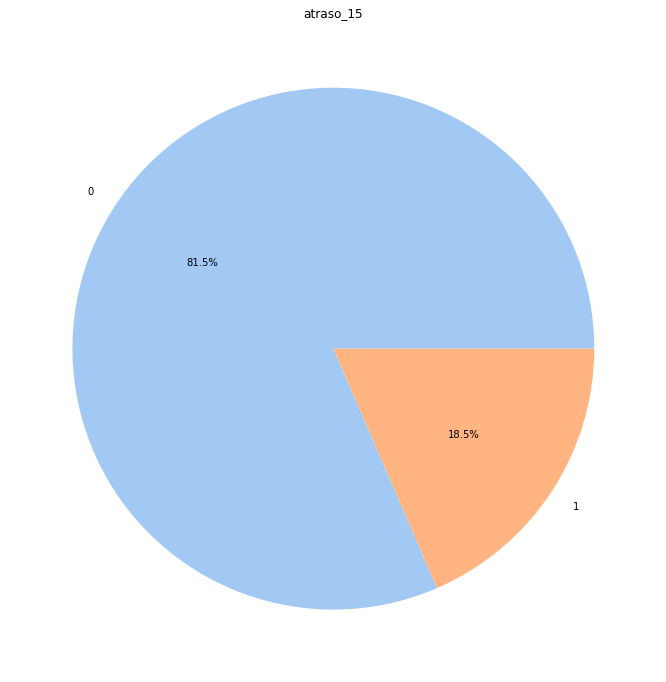

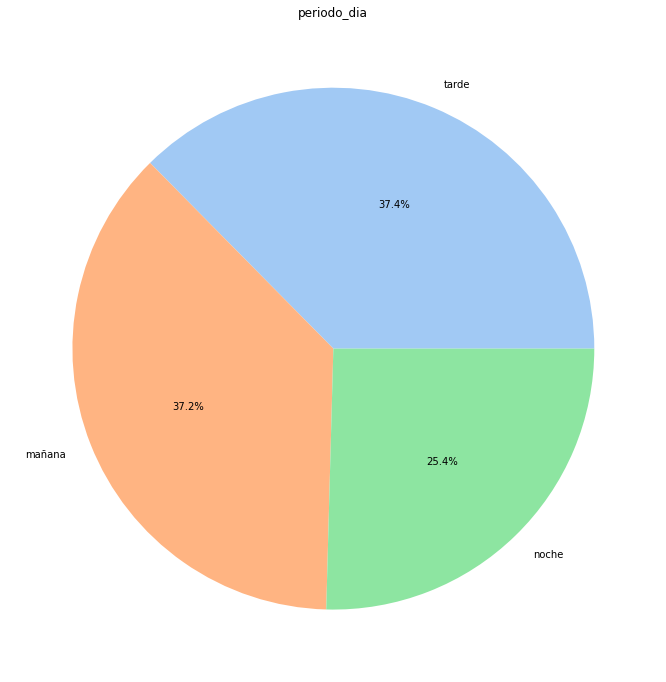

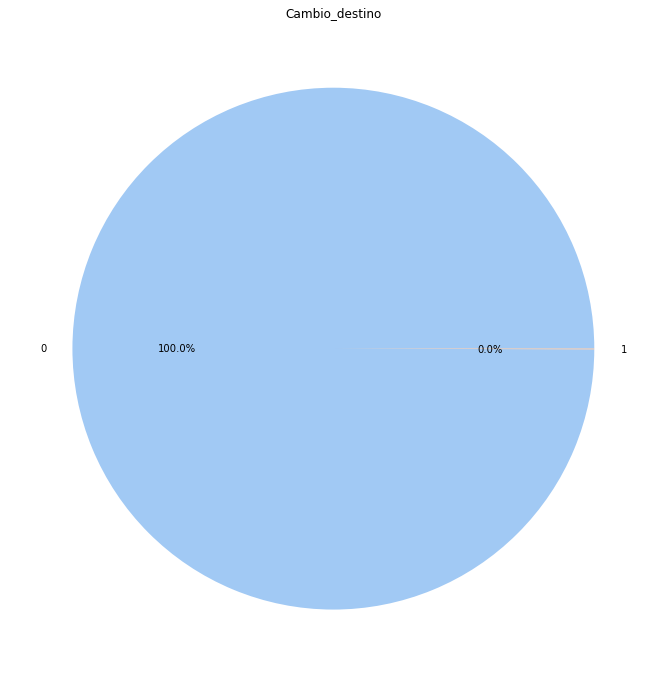

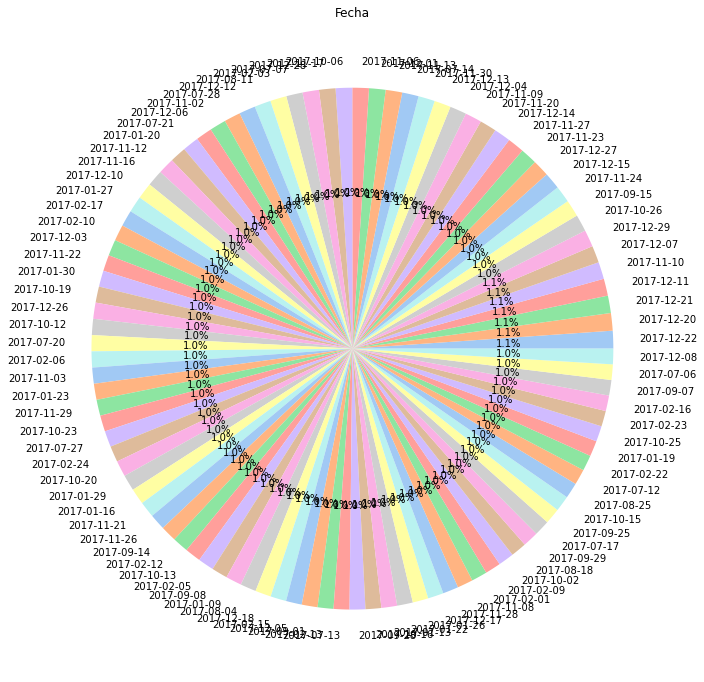

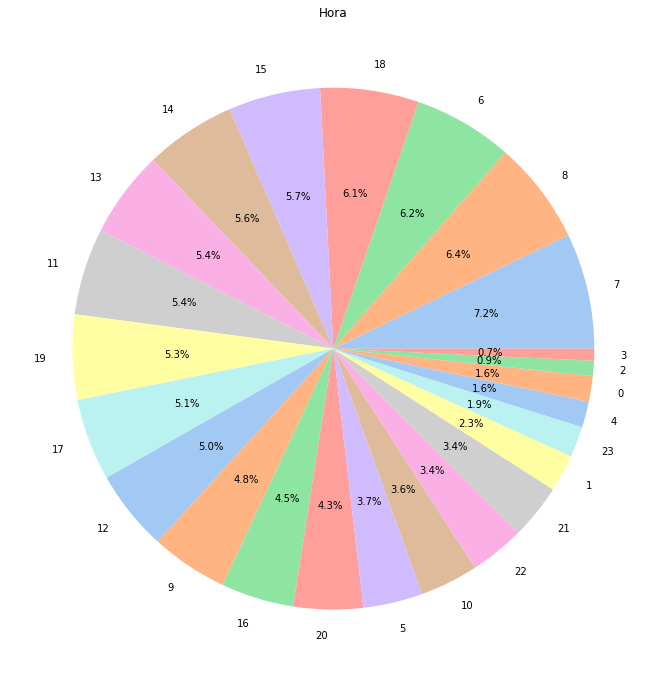

In [48]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100

for n in range(len(df.columns)):
    colors = sns.color_palette('pastel')[0:len(df[list(df.columns.values)[n]].value_counts())]
    plt.figure(figsize=(12, 12))
    plt.title((df.columns.values)[n])
    plt.pie(df[list(df.columns.values)[n]].value_counts().head(top),labels=df[list(df.columns.values)[n]].value_counts().head(top).index.tolist(), autopct='%1.1f%%', colors=colors)
plt.show()

### Bar_charts

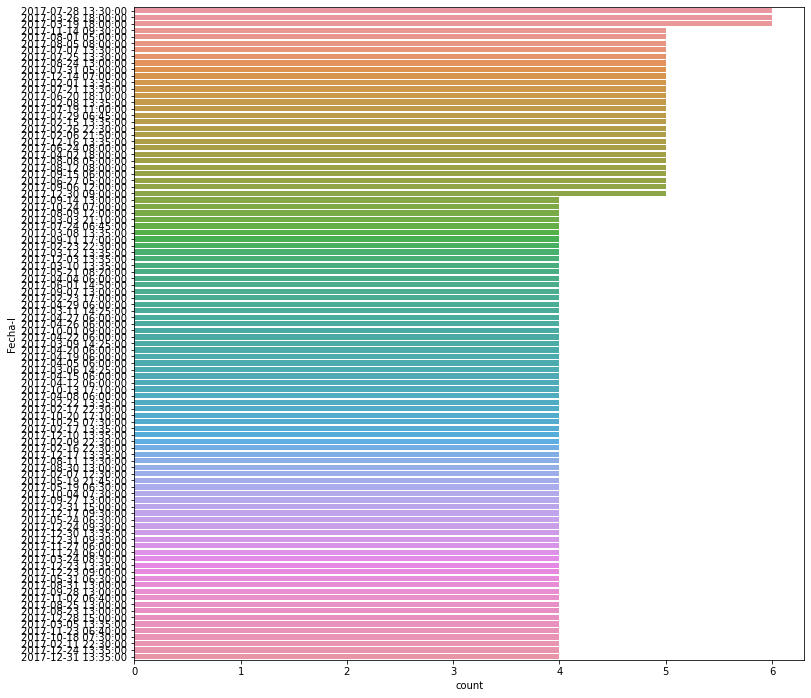

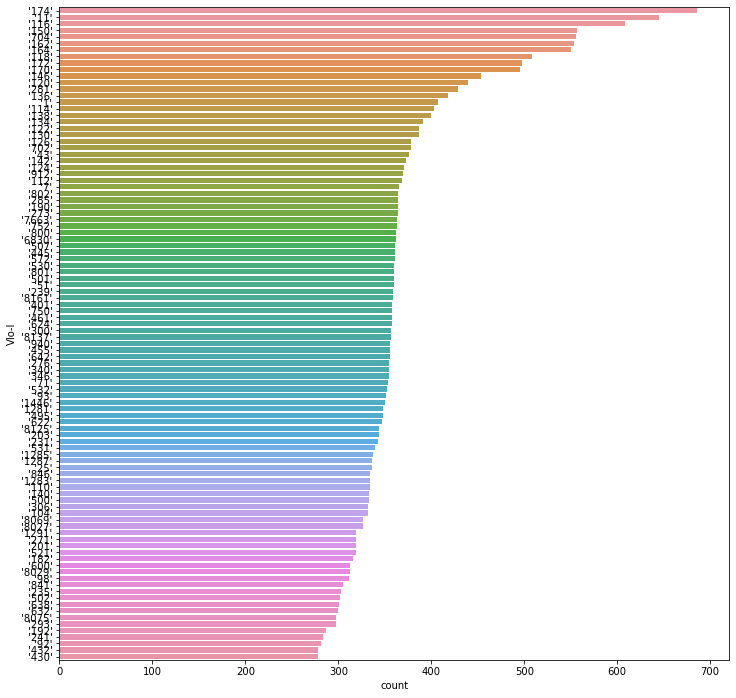

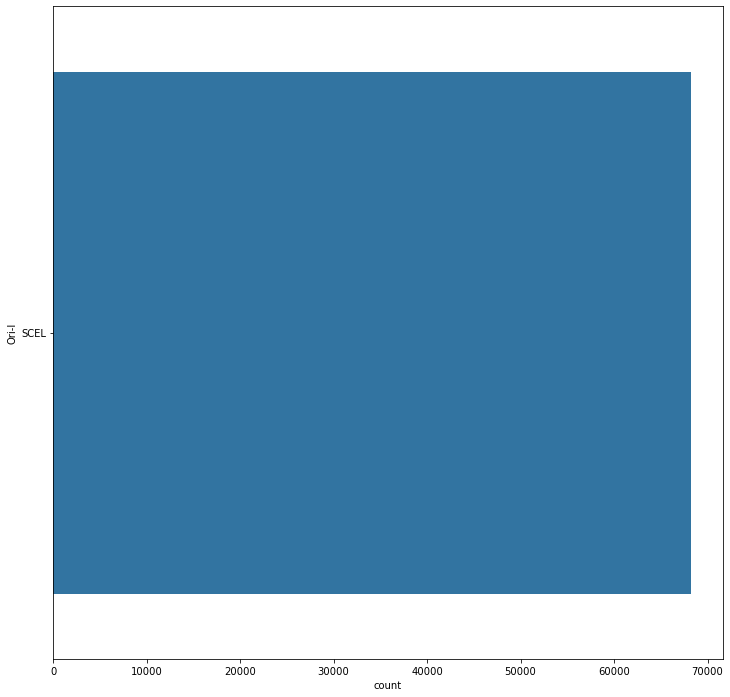

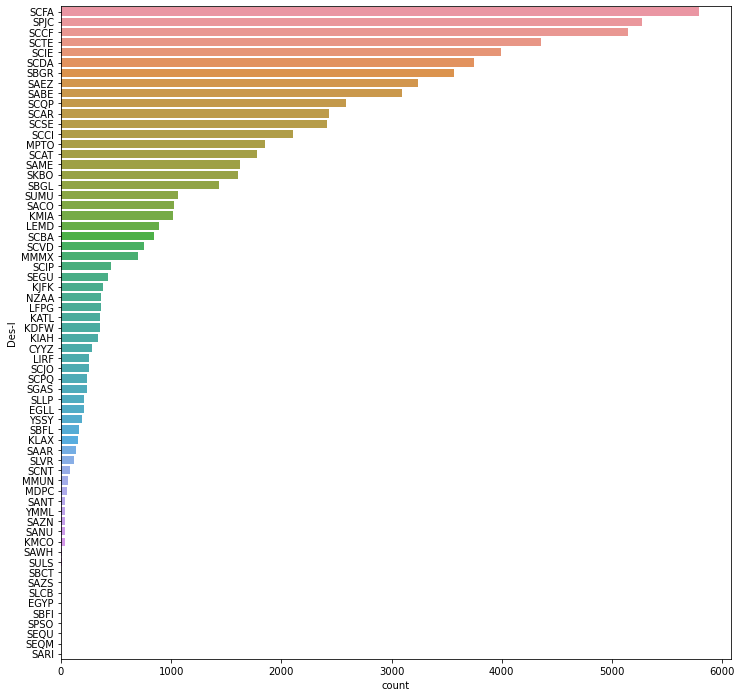

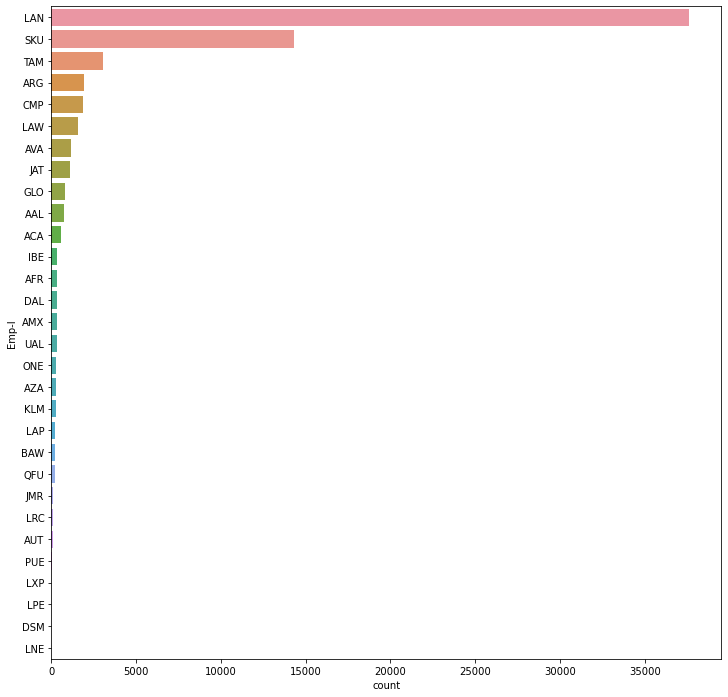

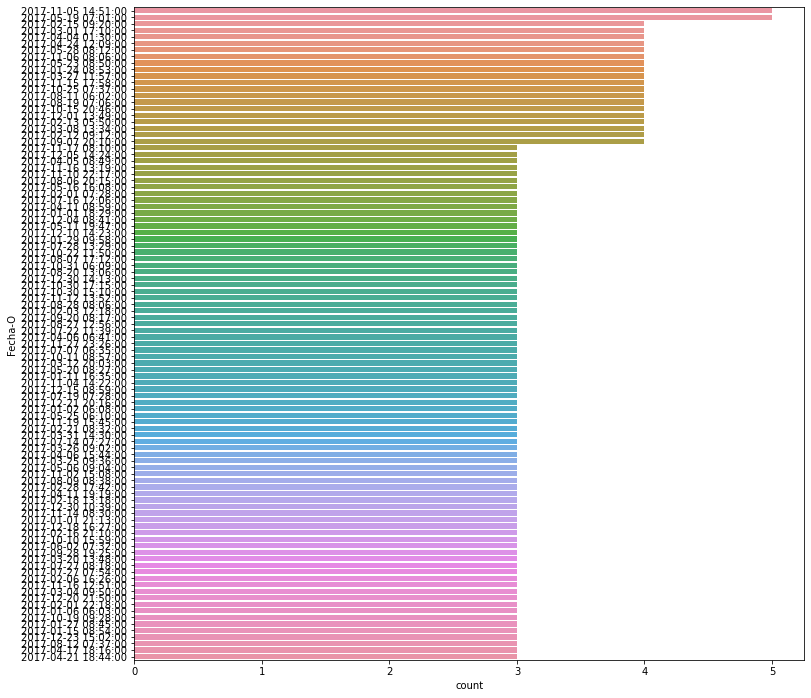

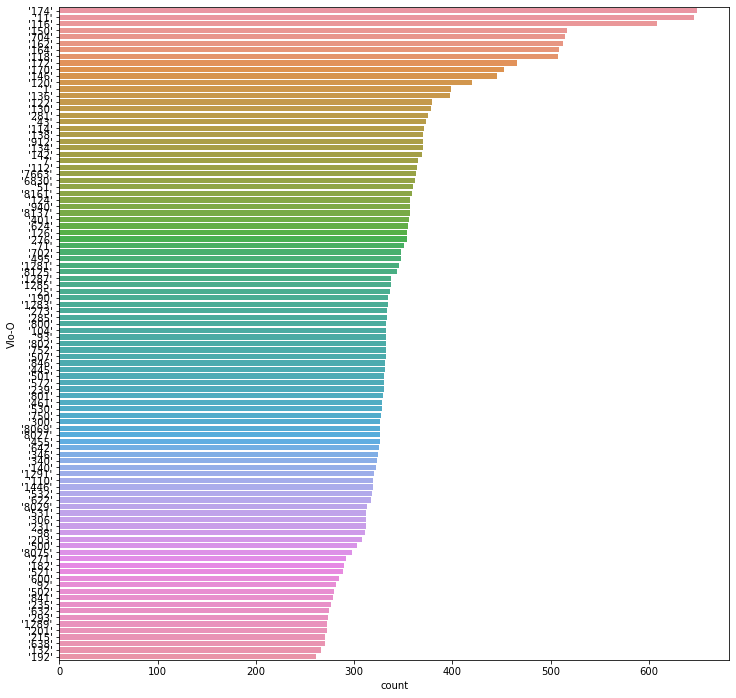

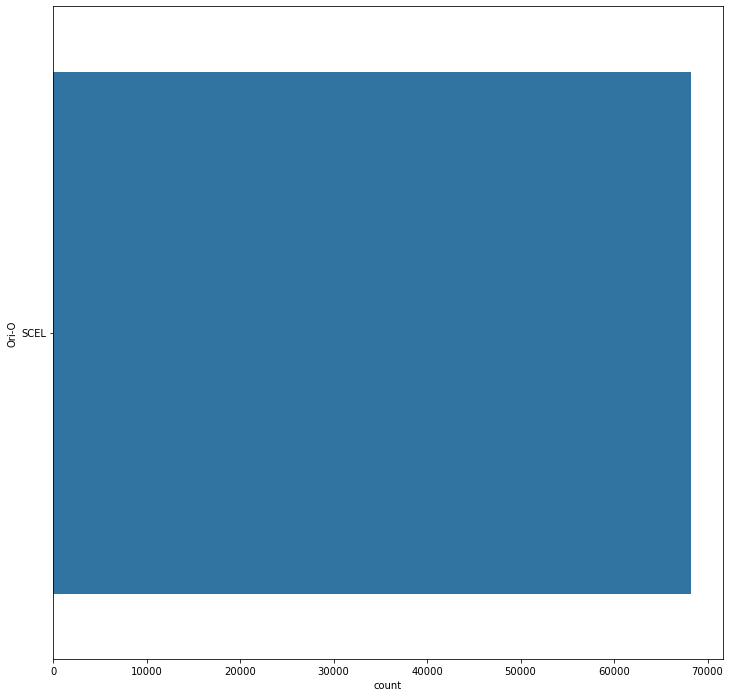

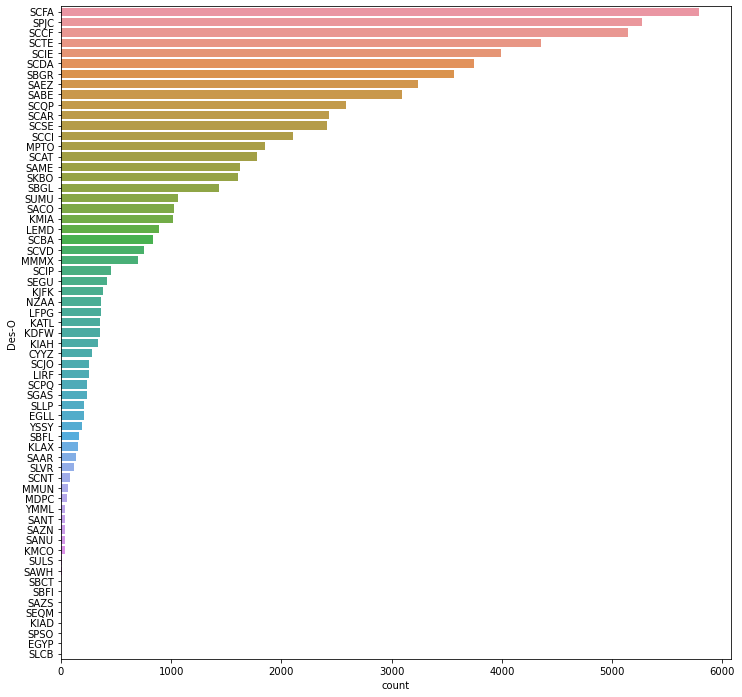

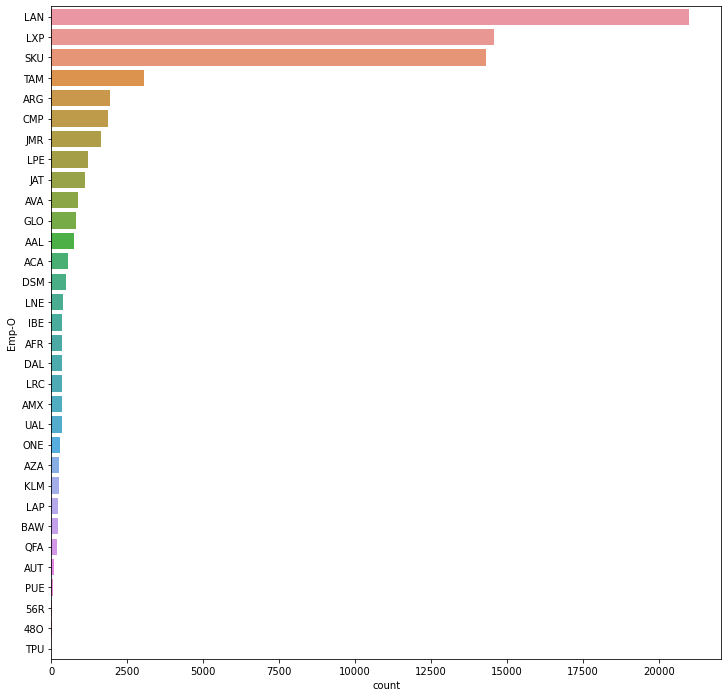

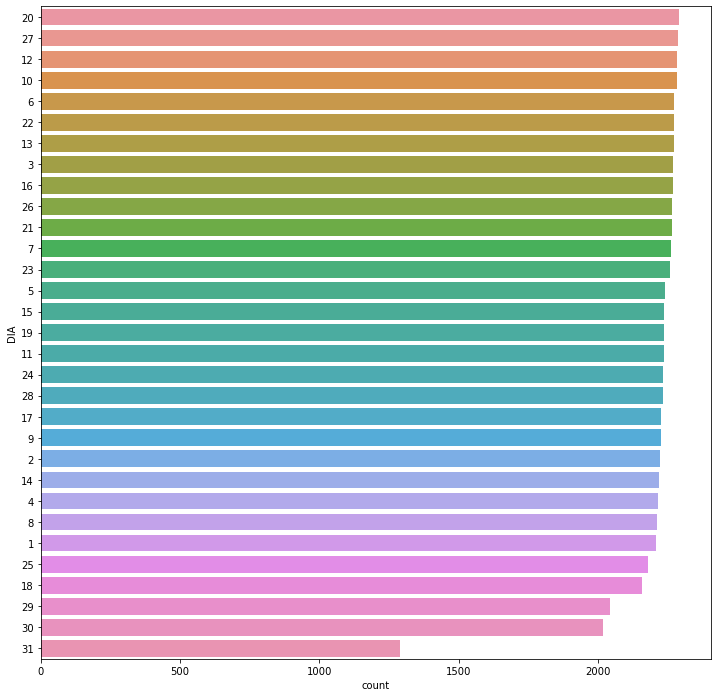

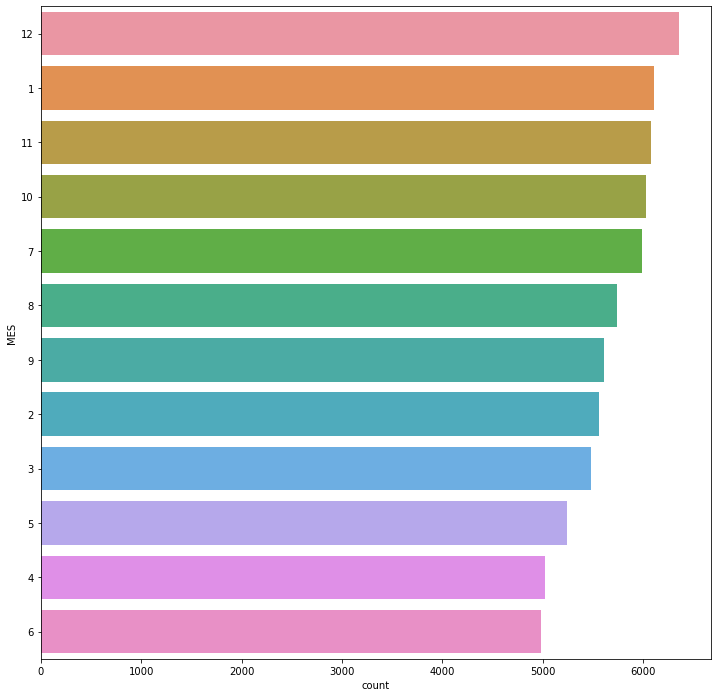

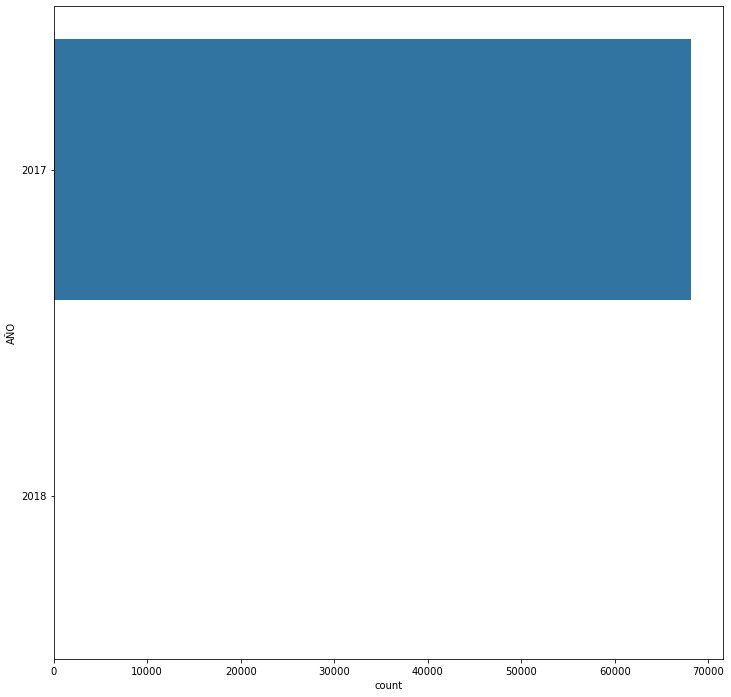

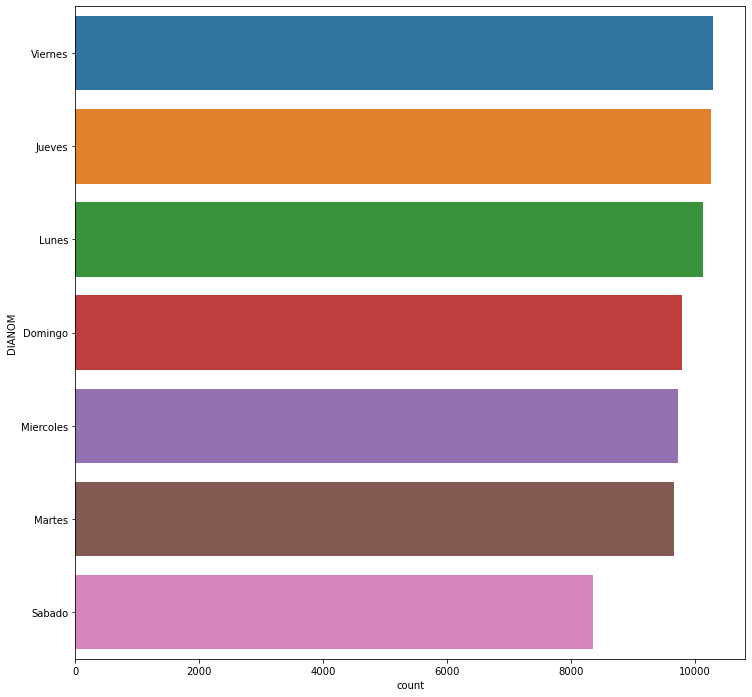

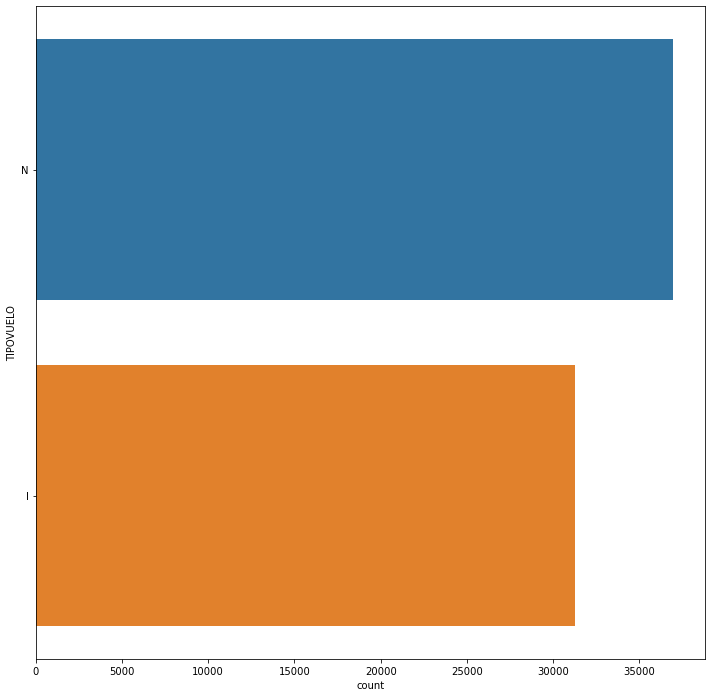

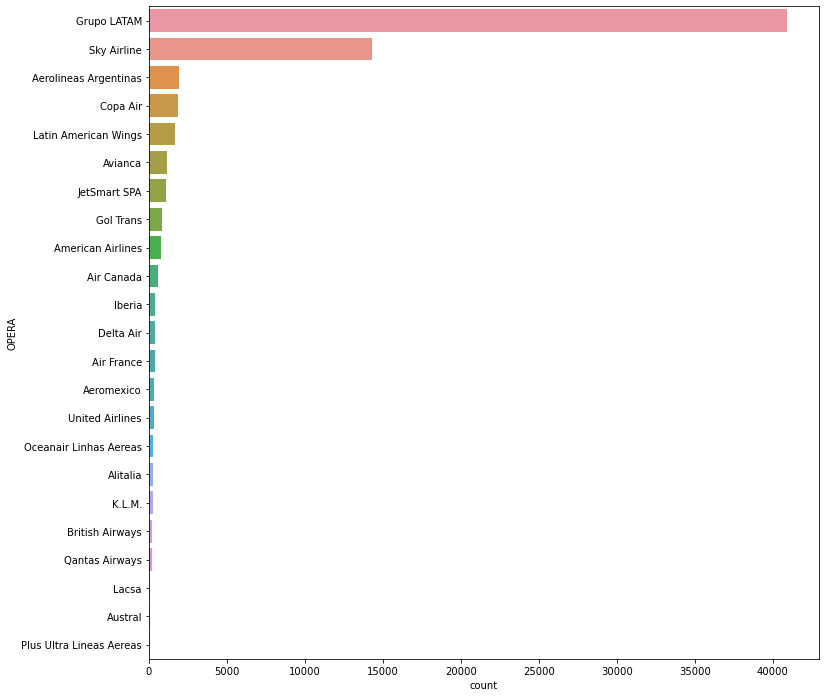

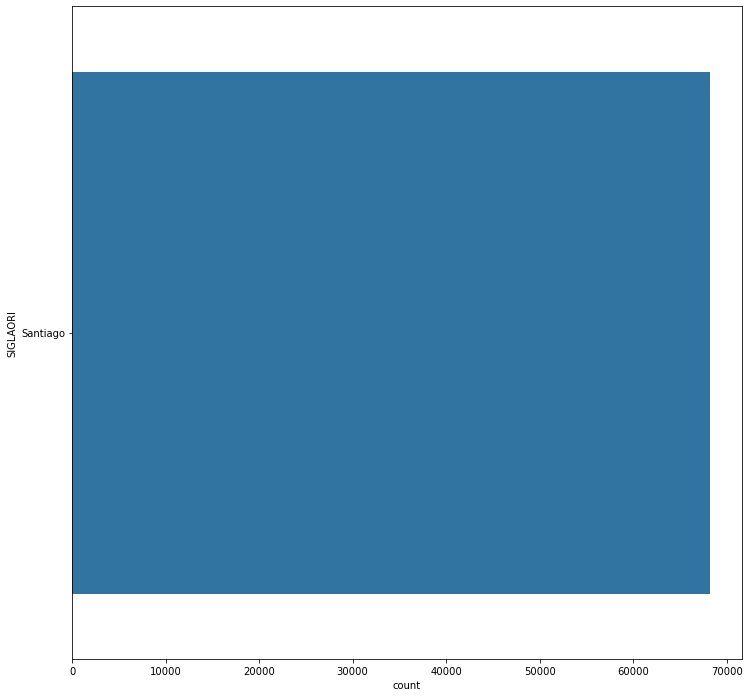

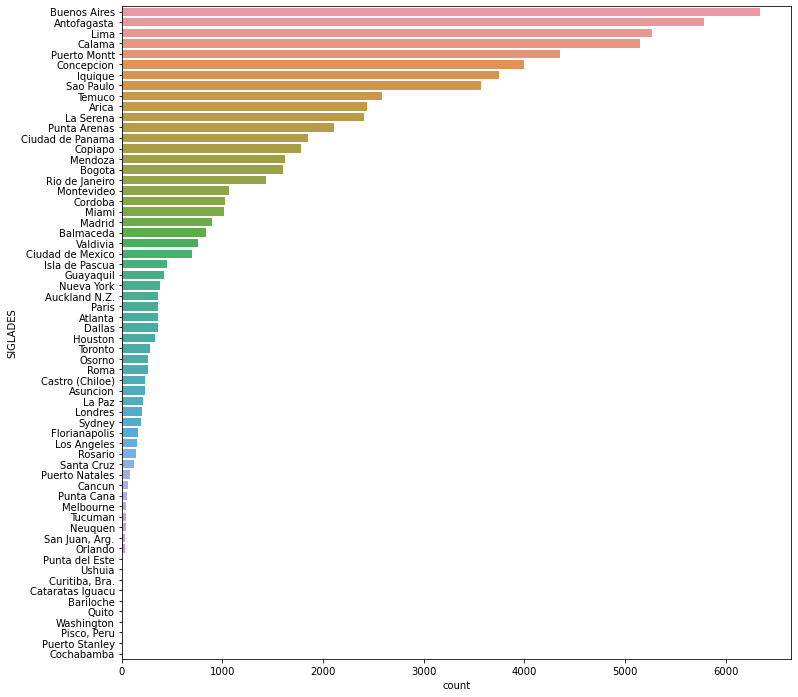

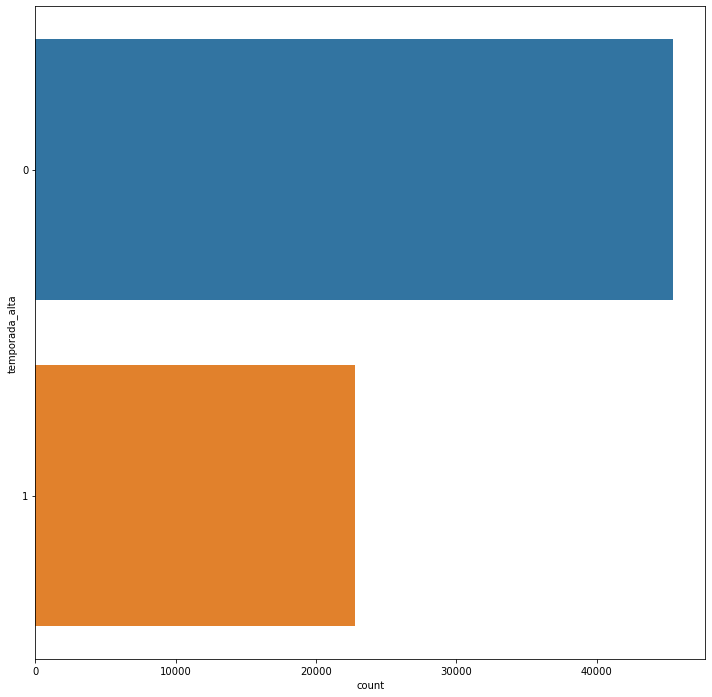

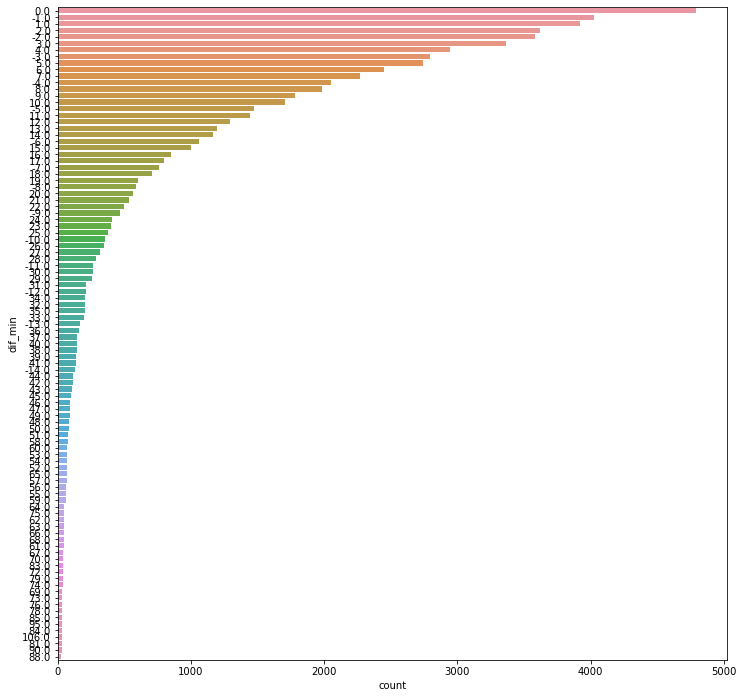

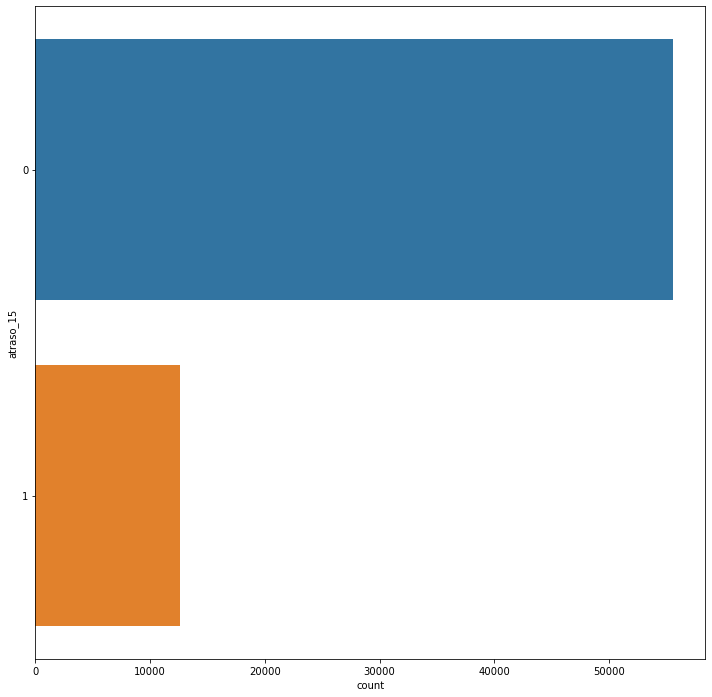

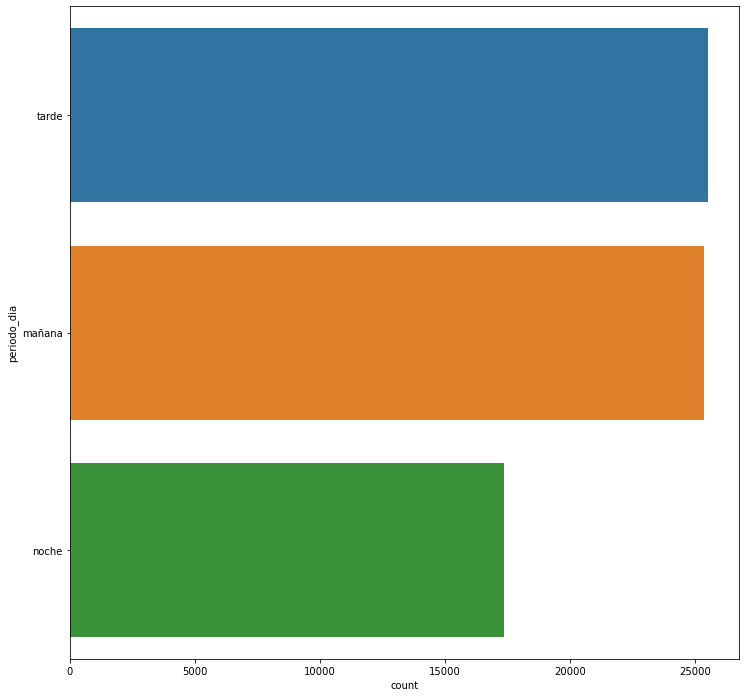

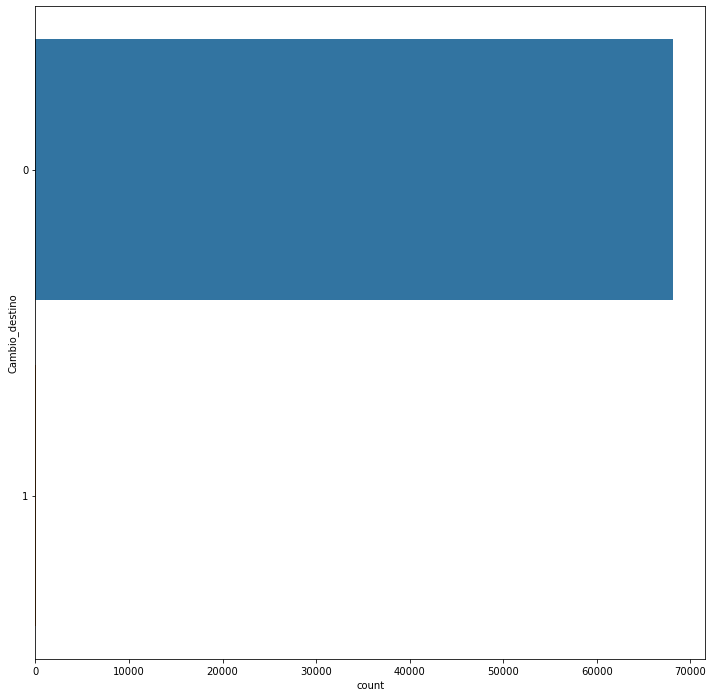

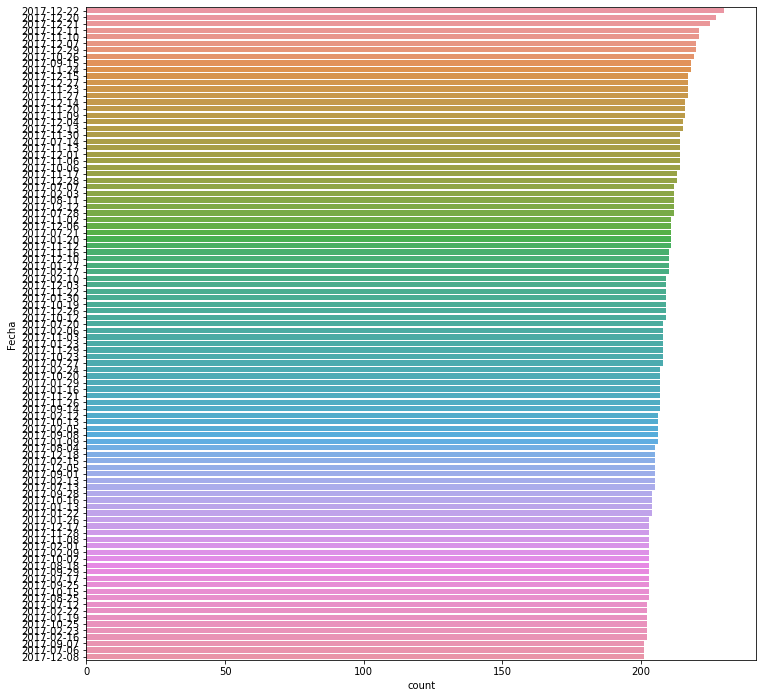

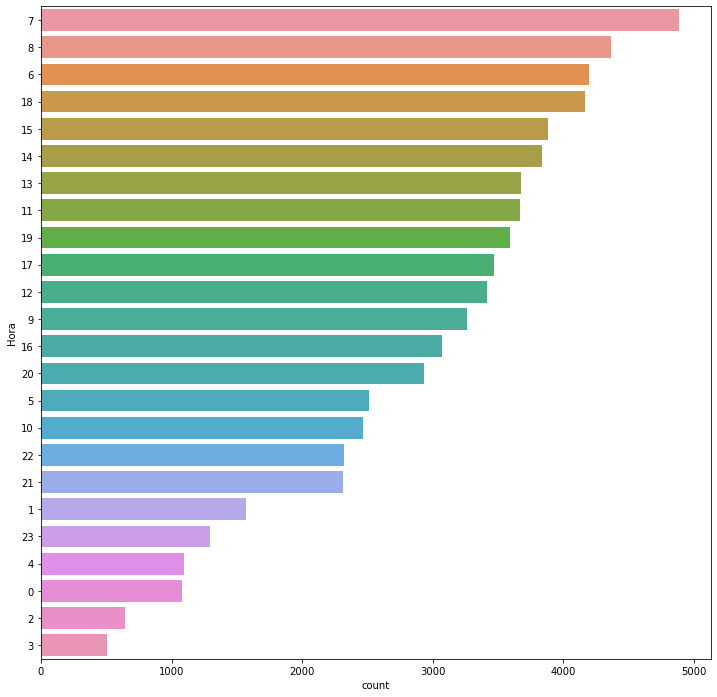

In [49]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100

for n in range(len(df.columns)):
    count_order = df[list(df.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df, y=list(df.columns.values)[n], order=count_order)
plt.show()


### Histoplots

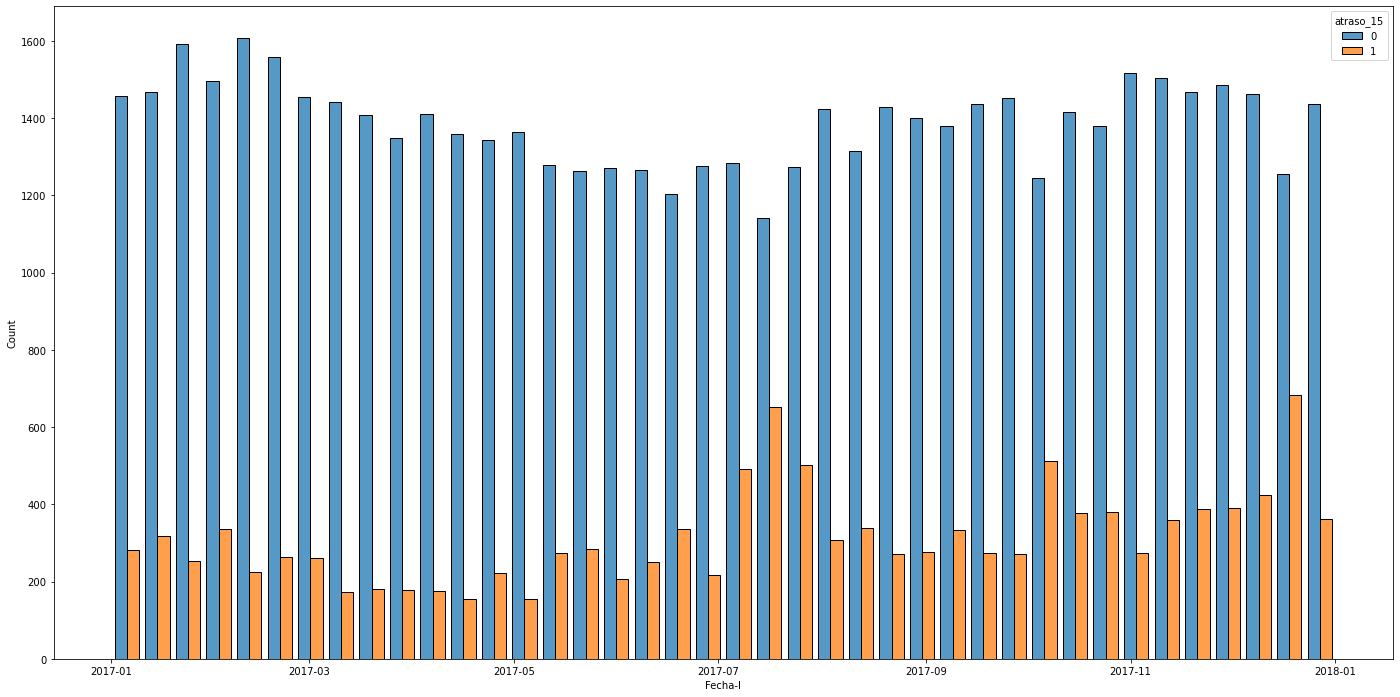

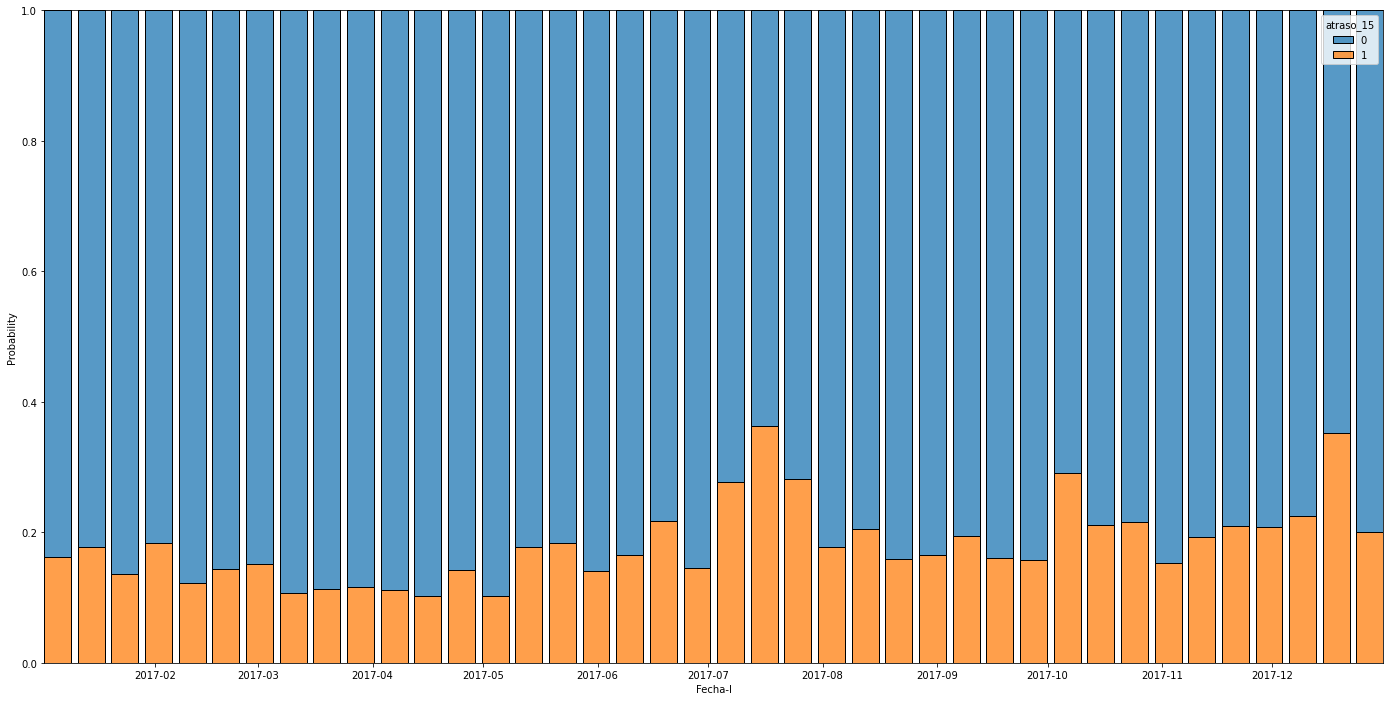

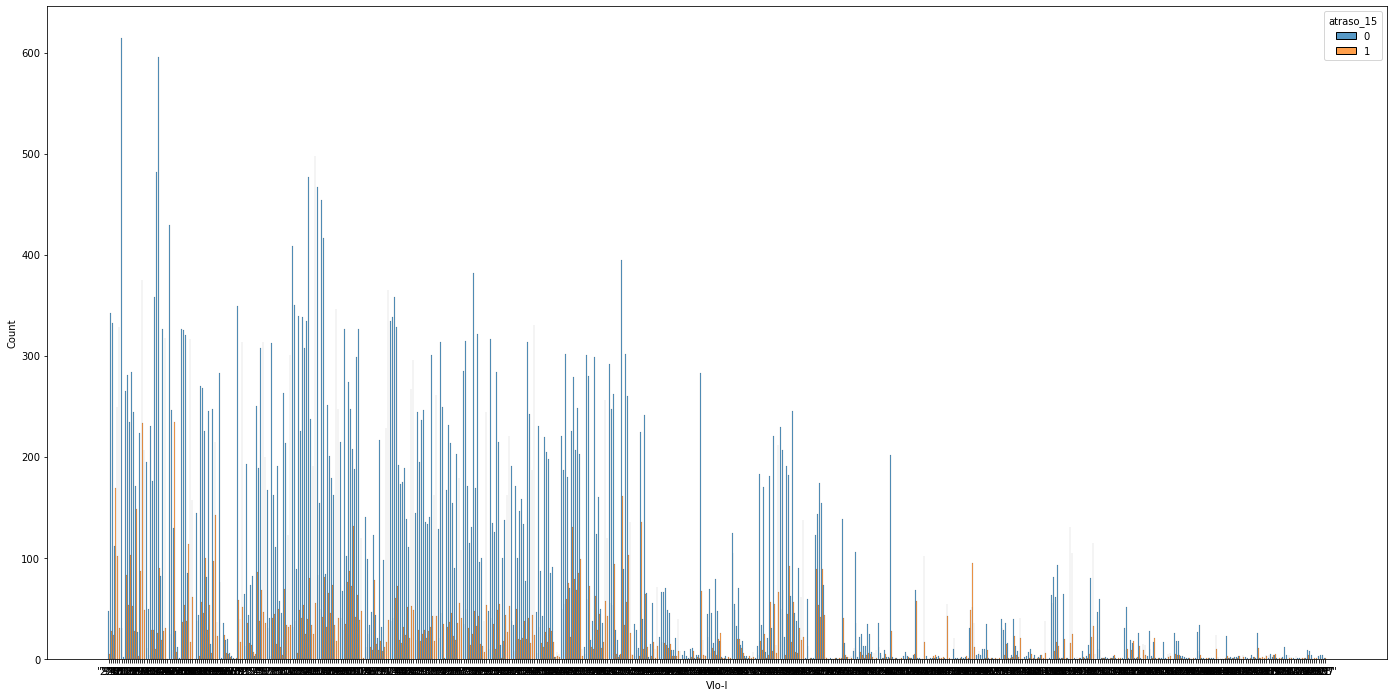

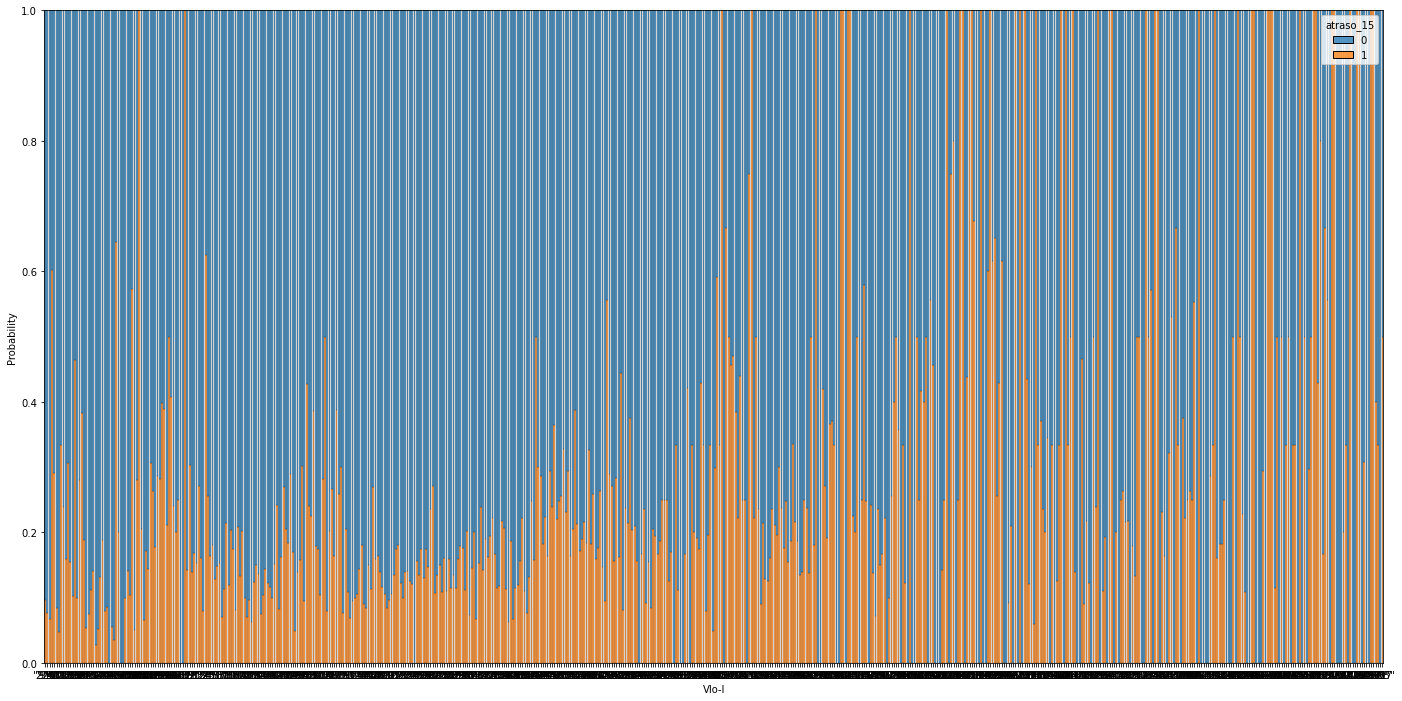

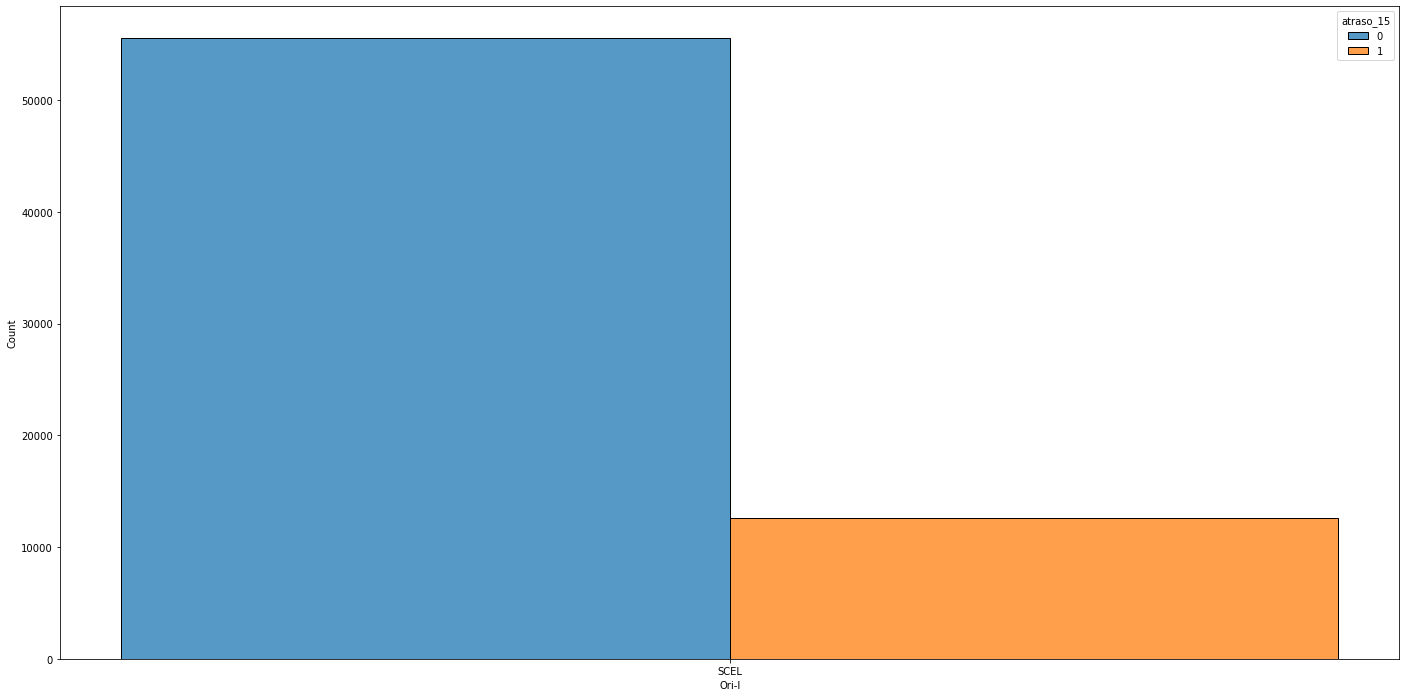

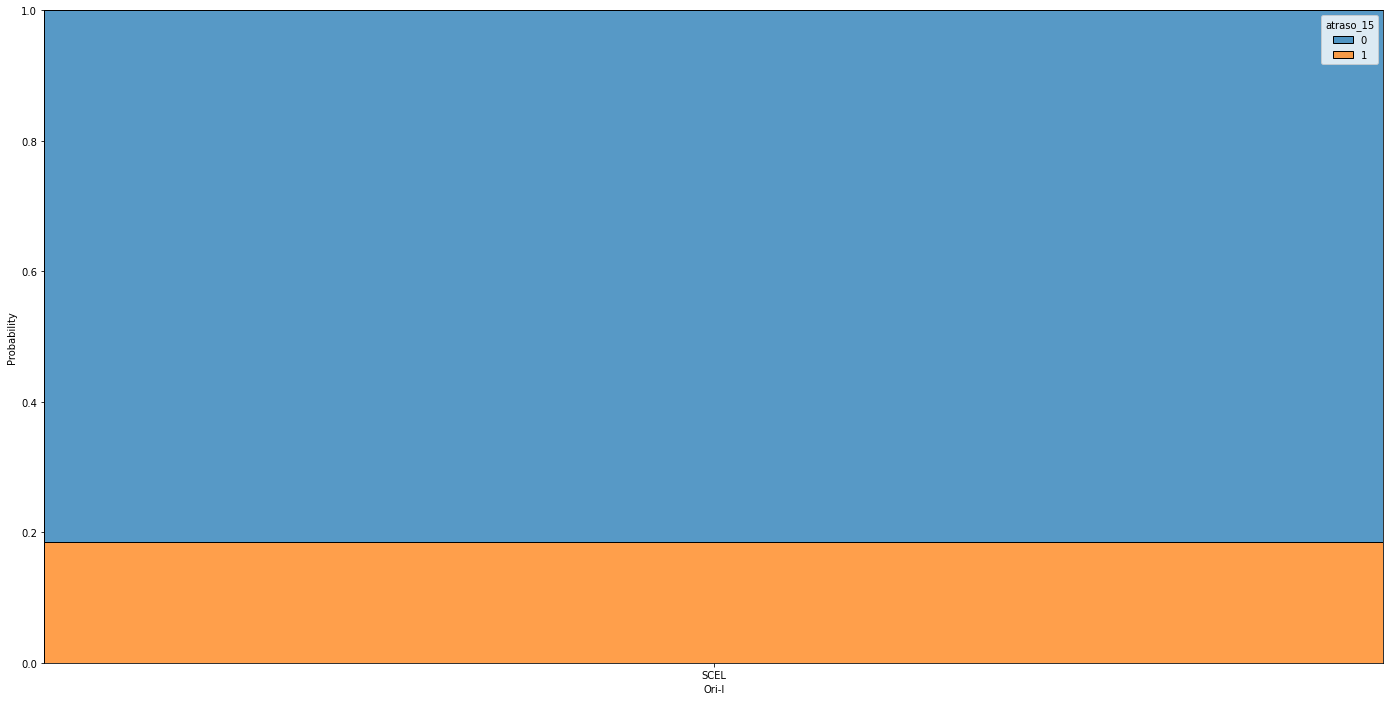

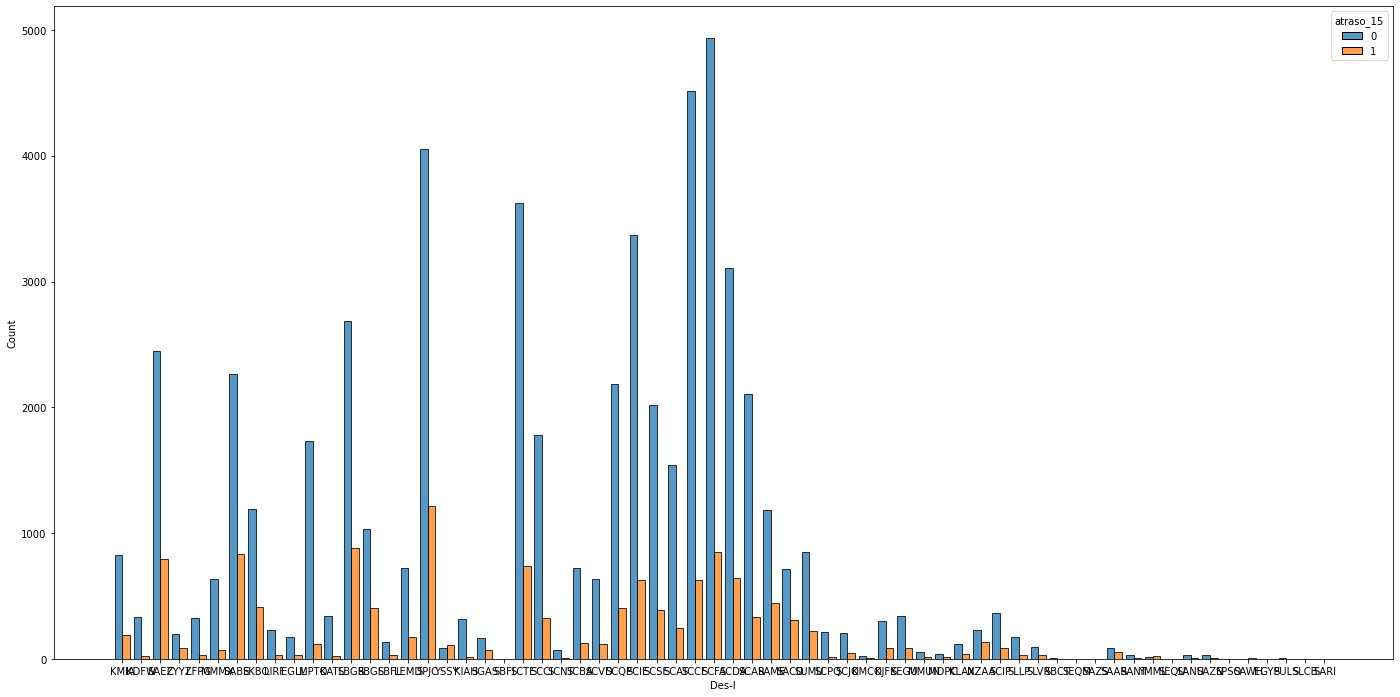

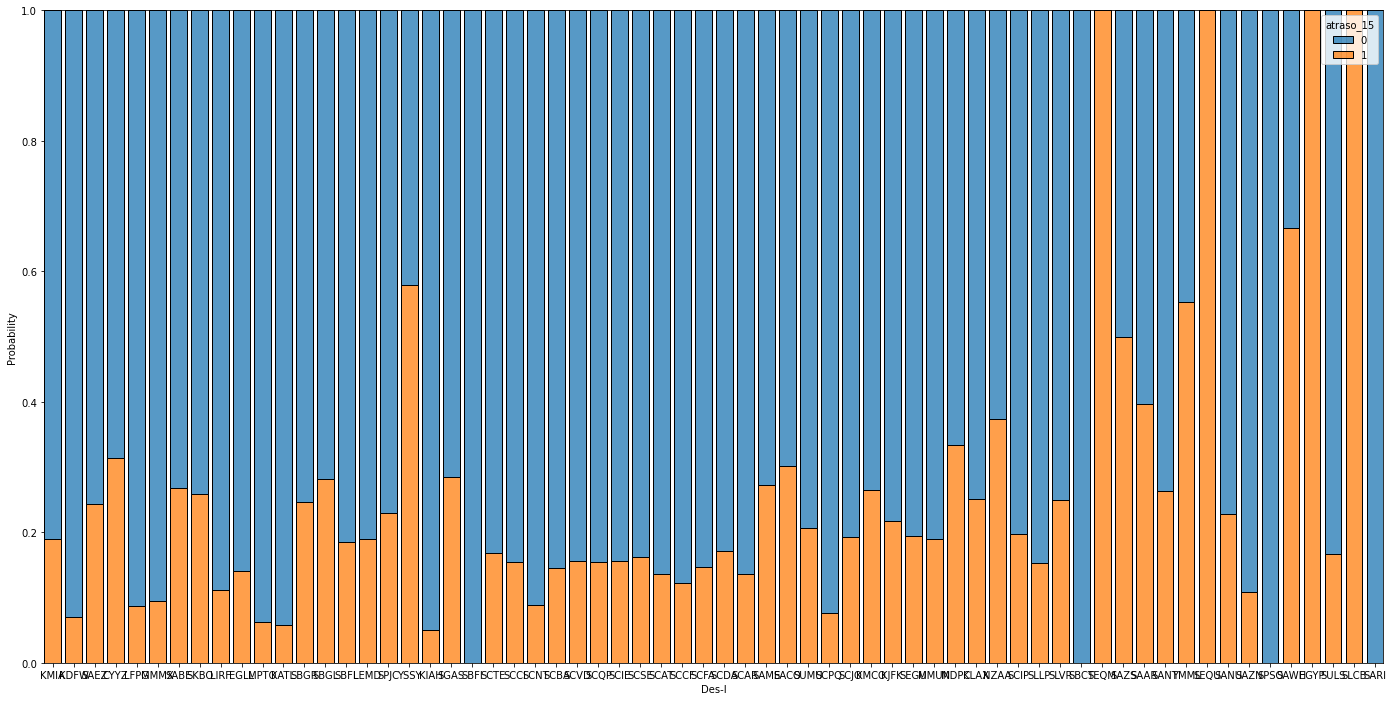

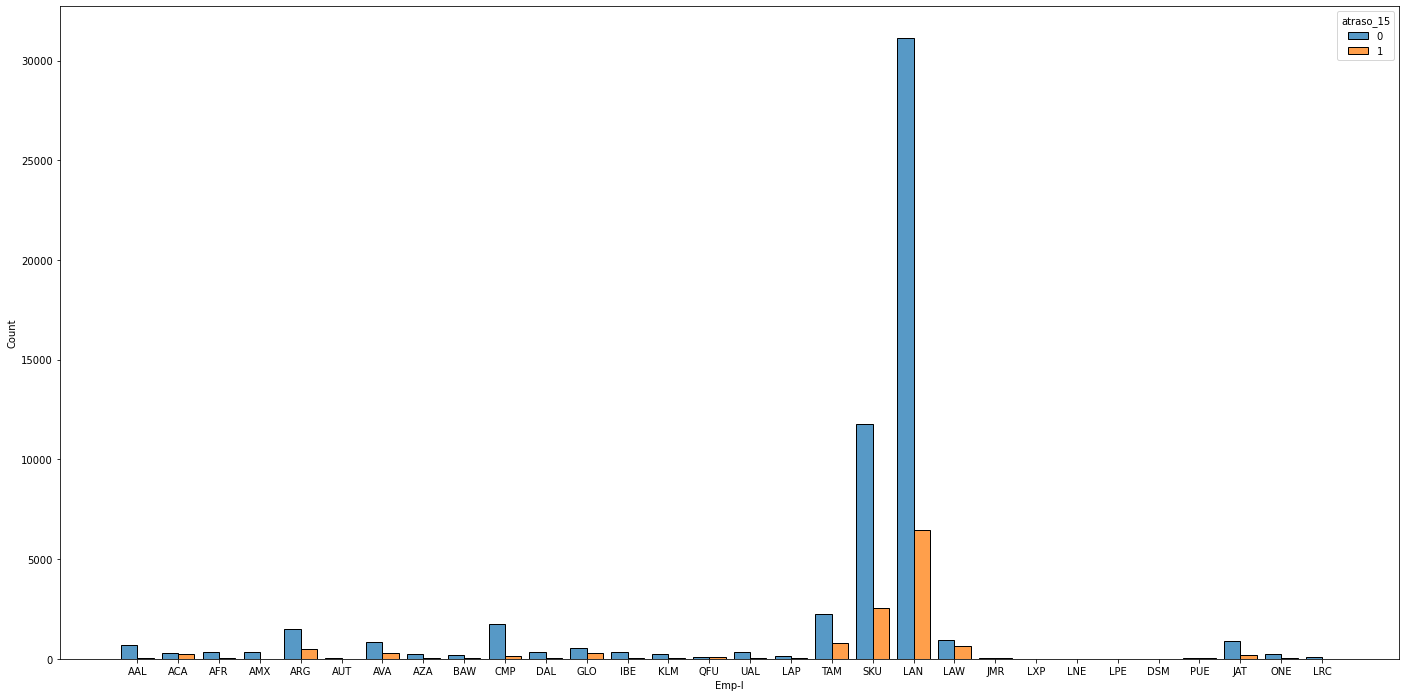

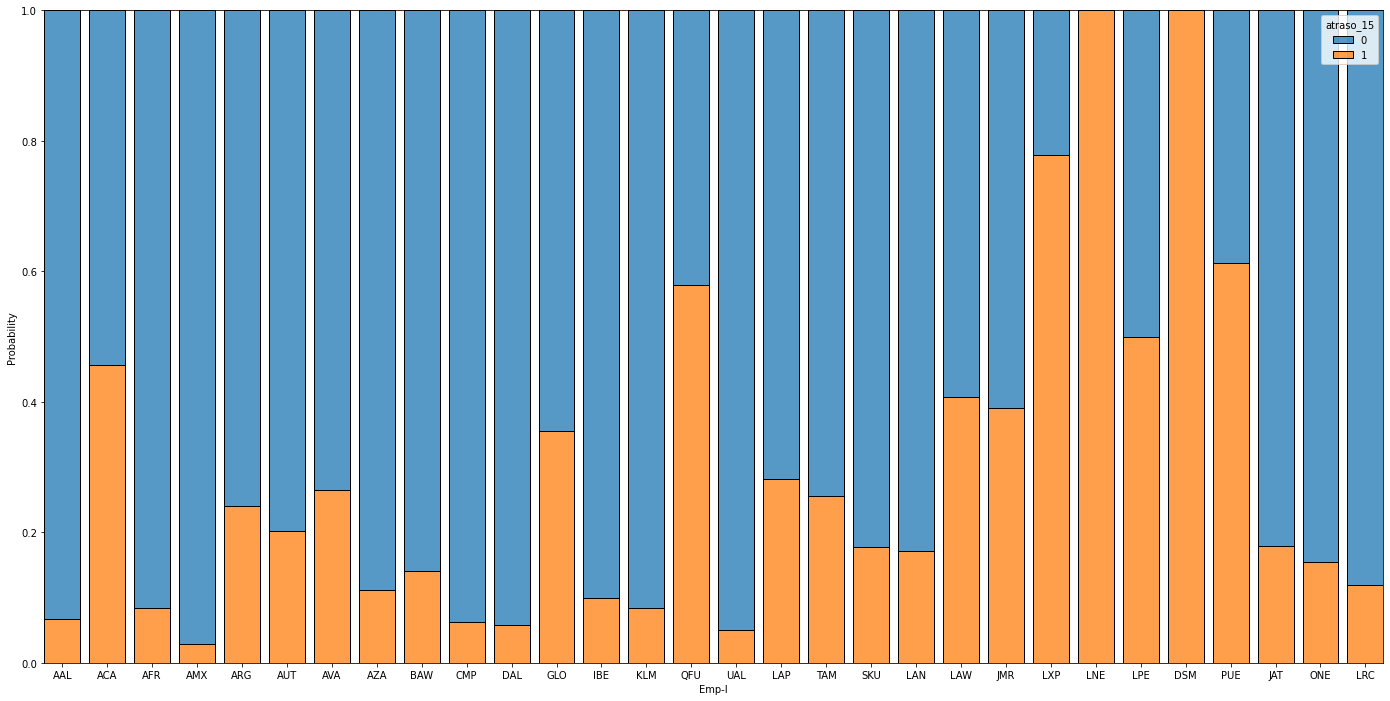

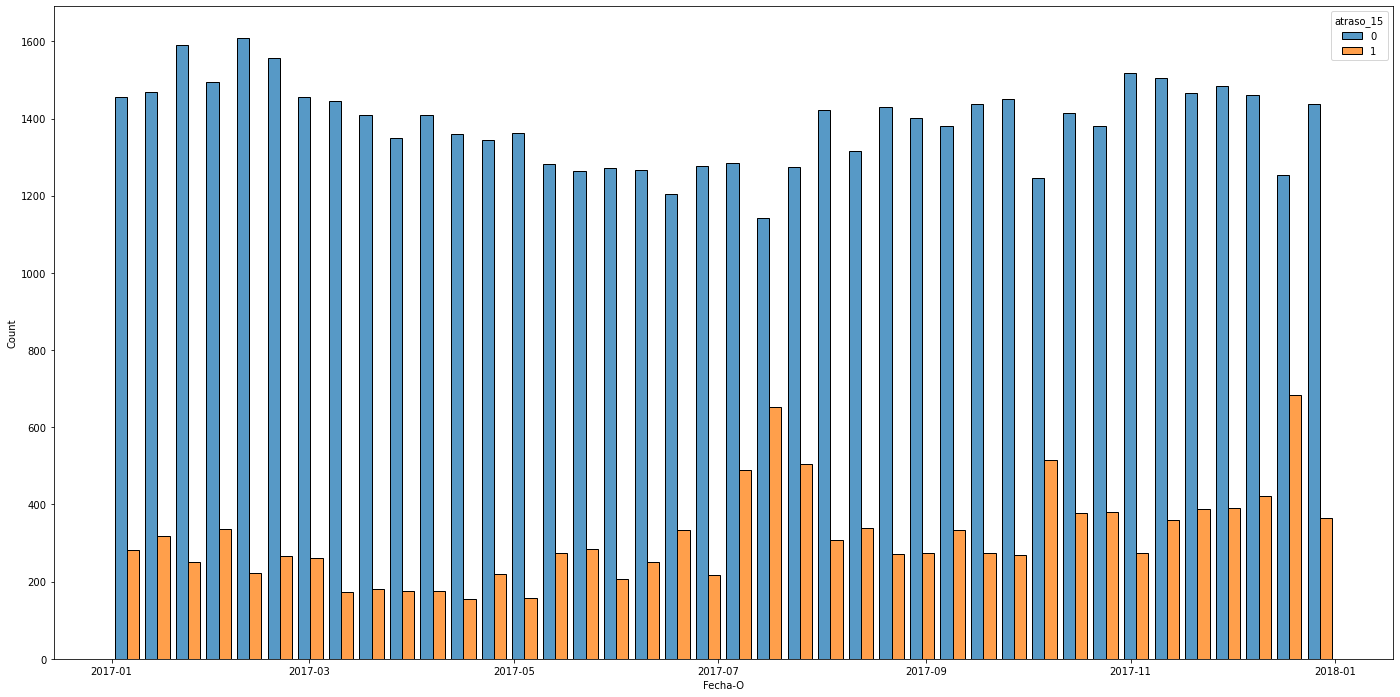

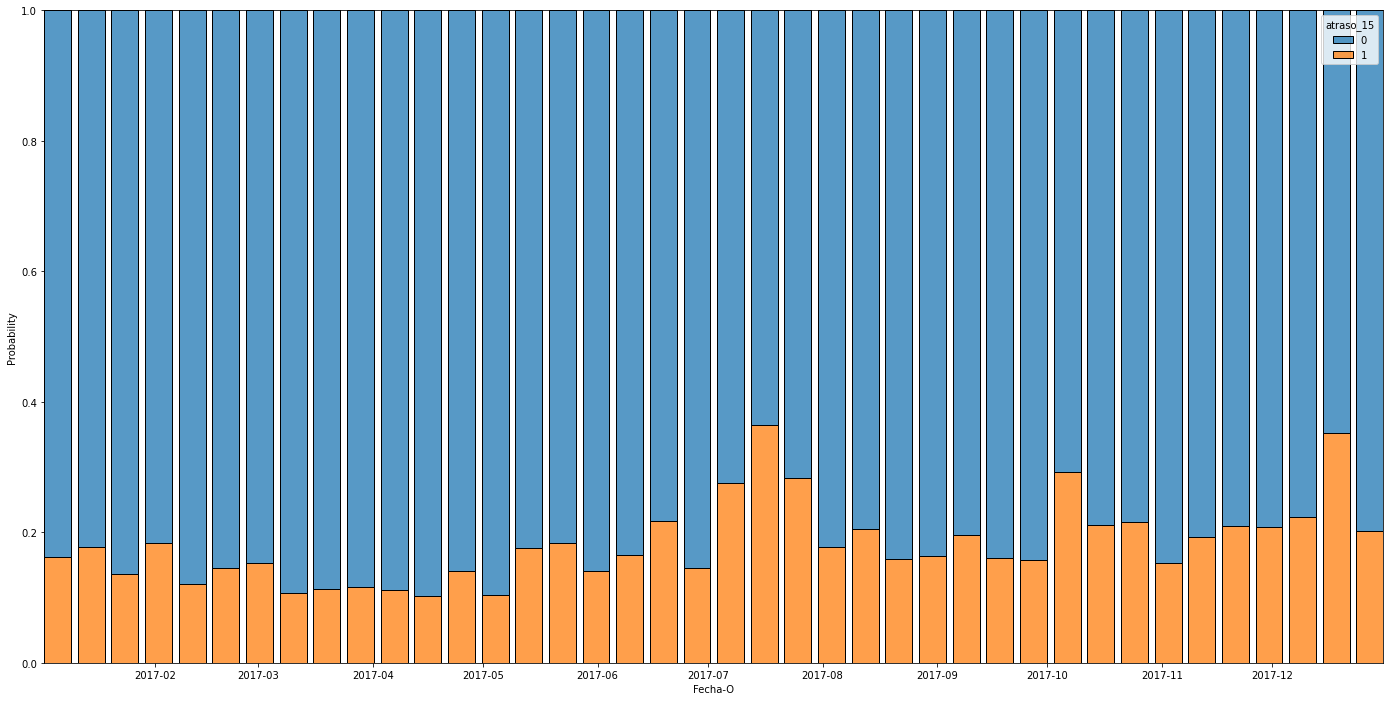

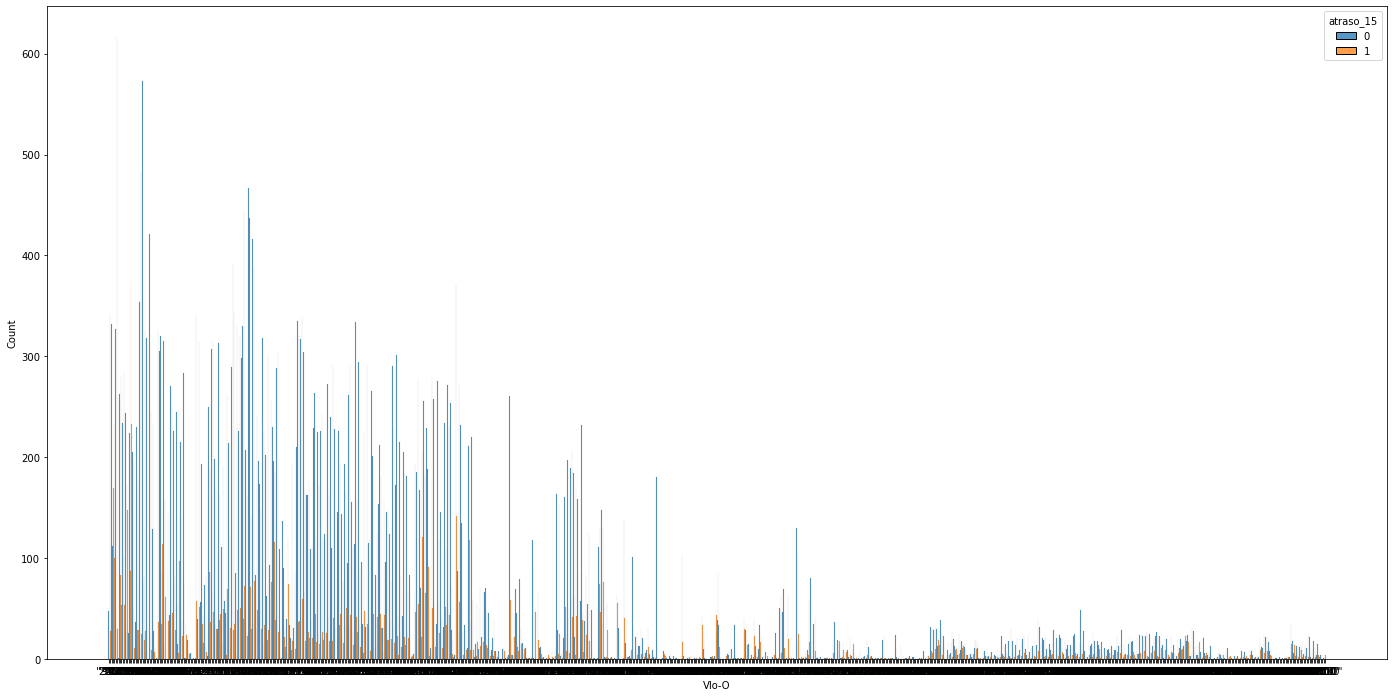

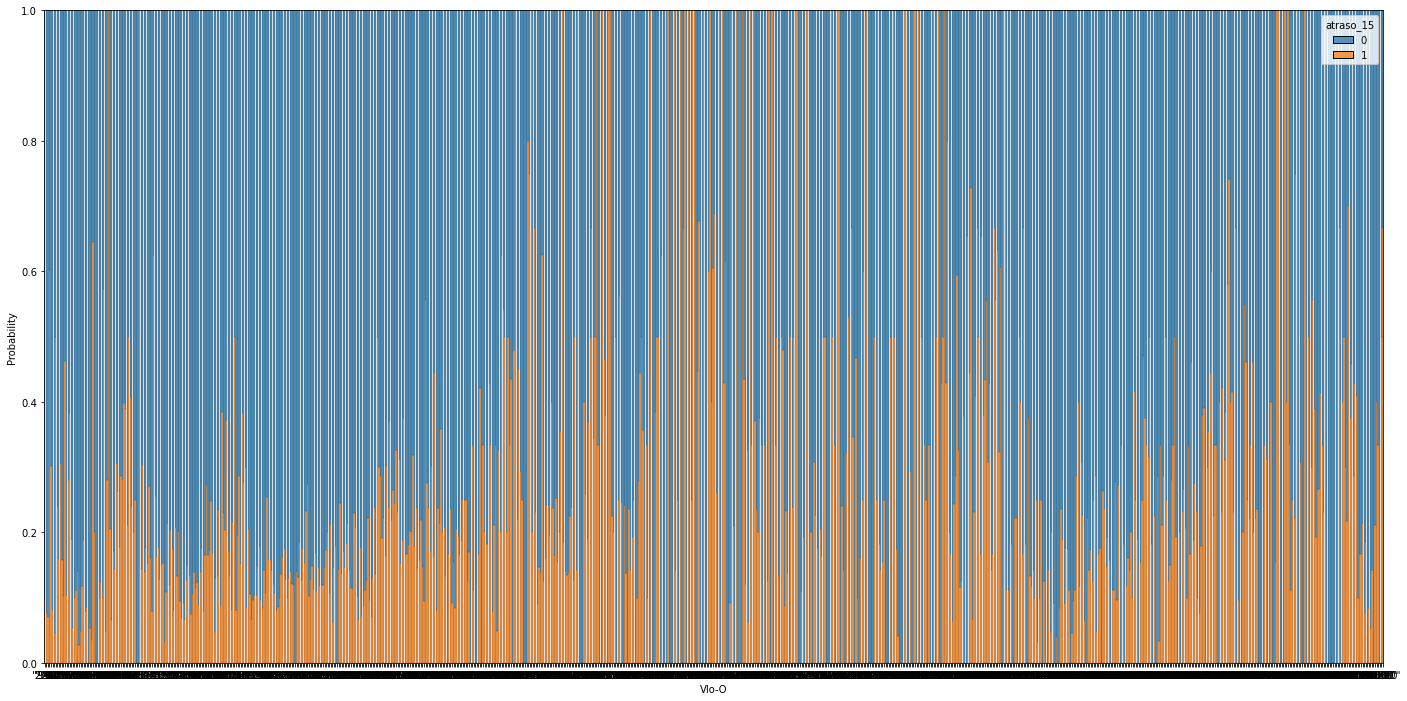

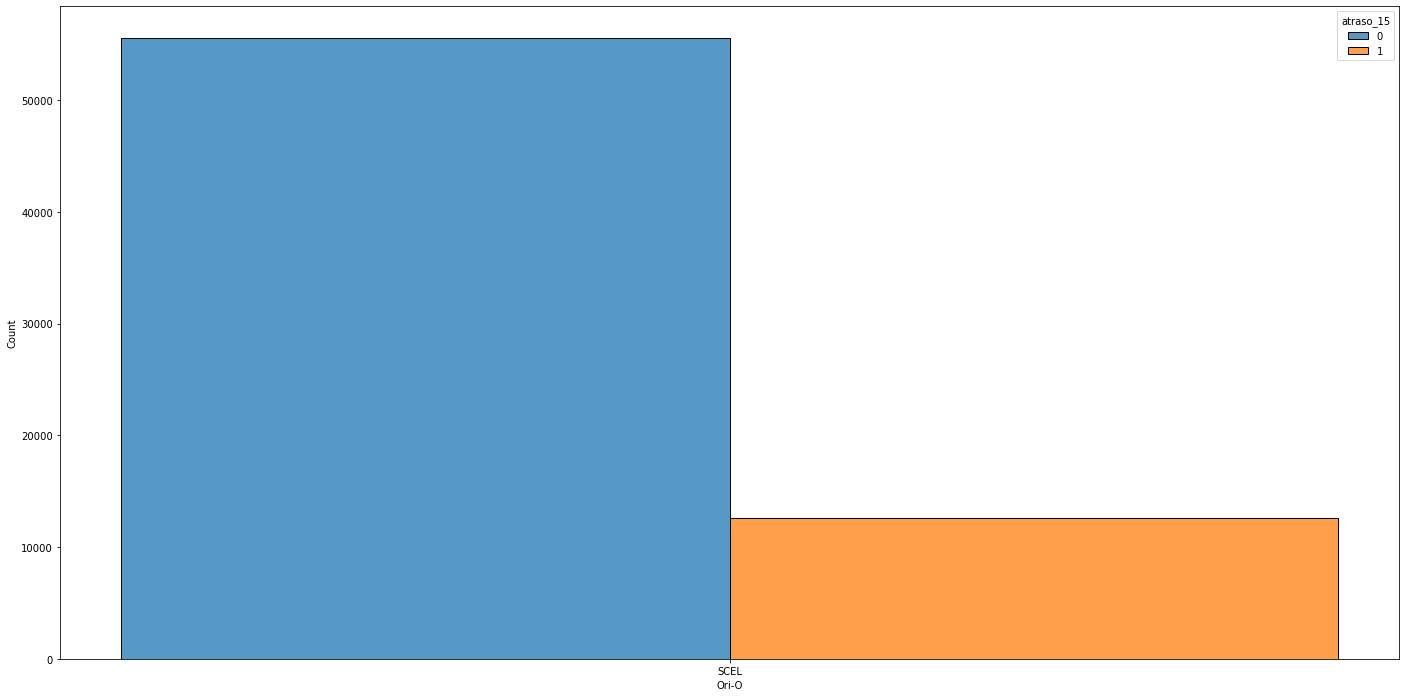

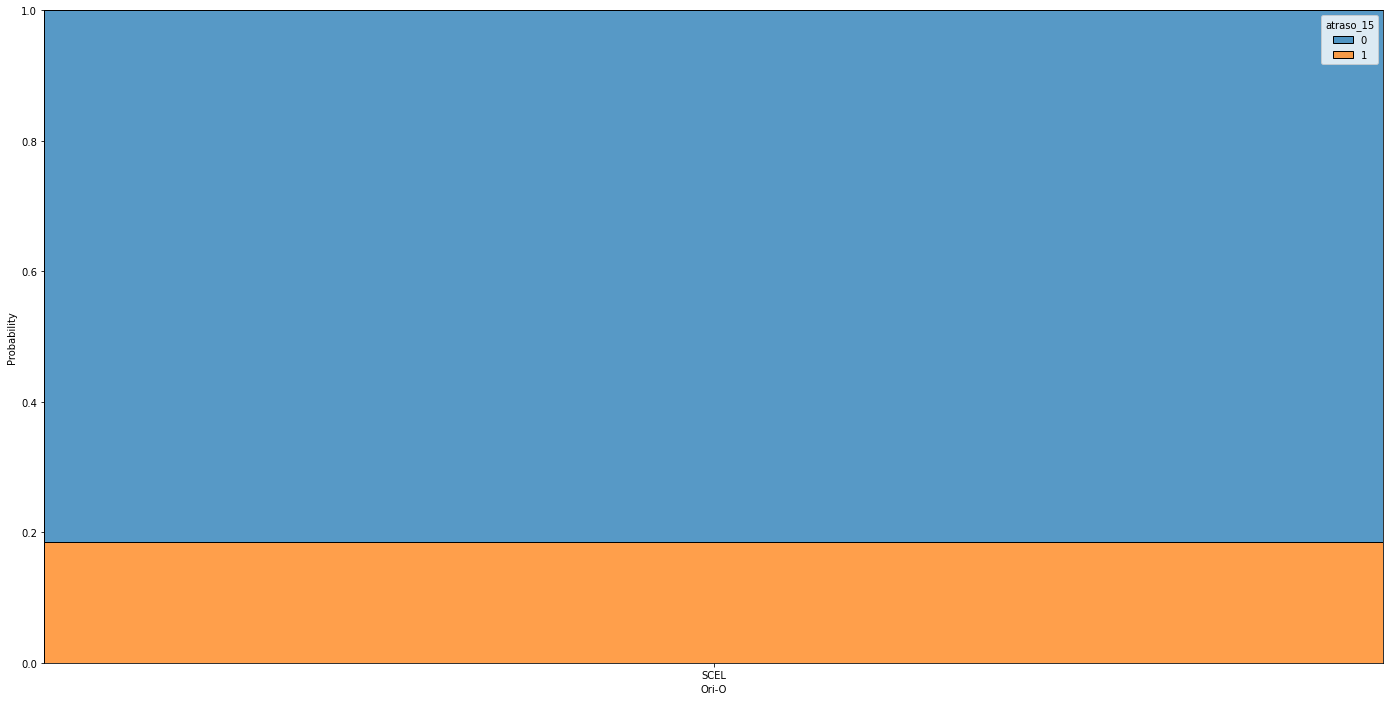

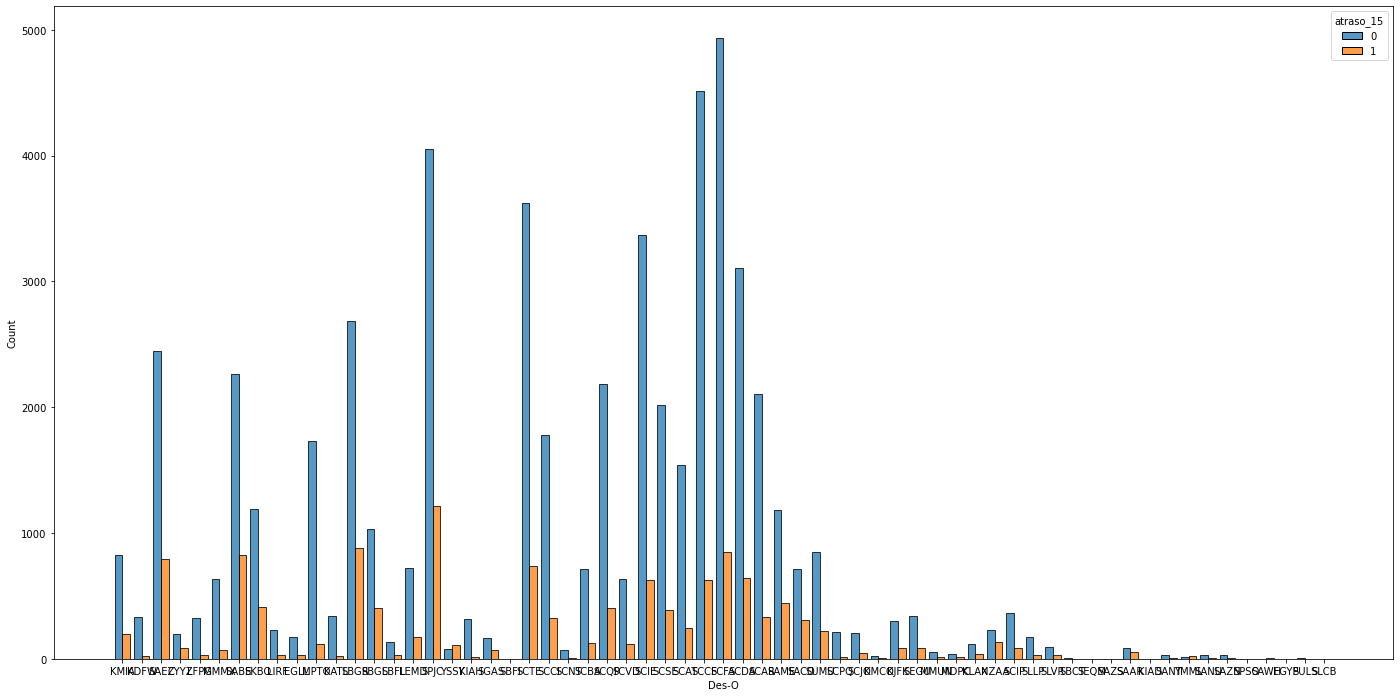

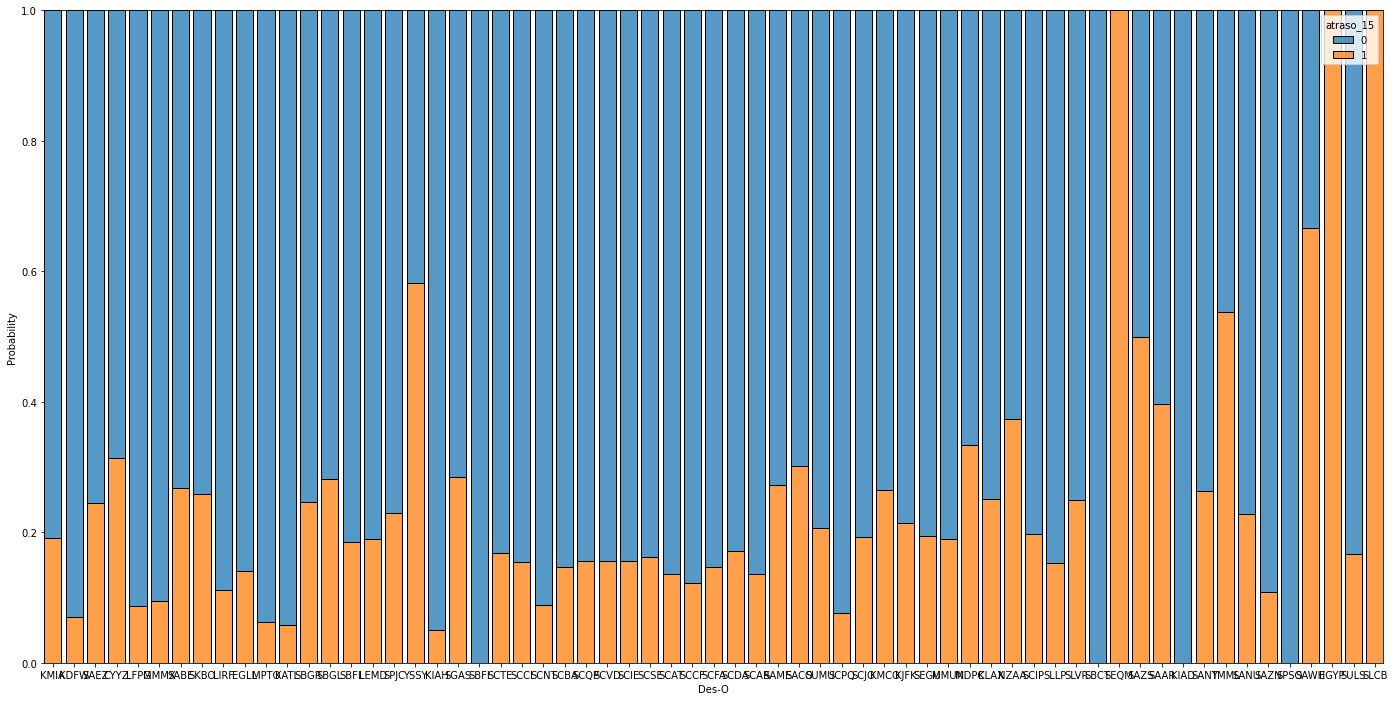

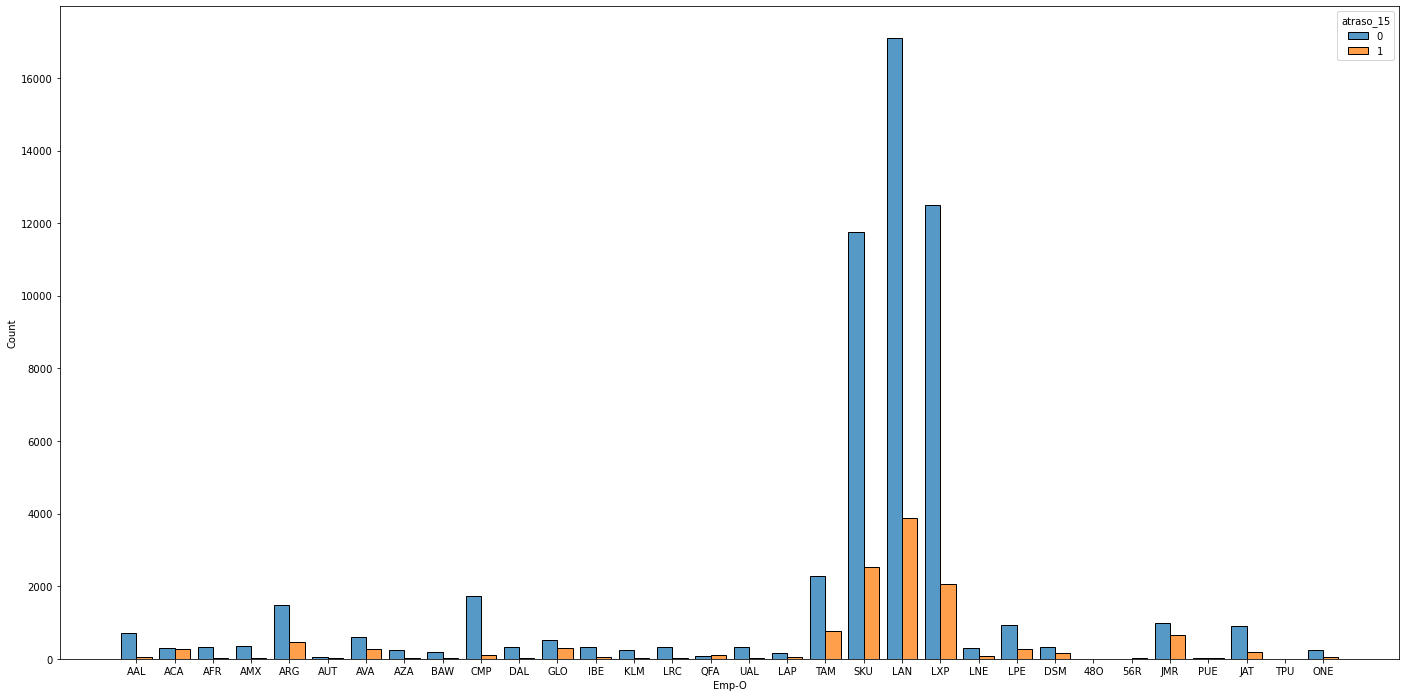

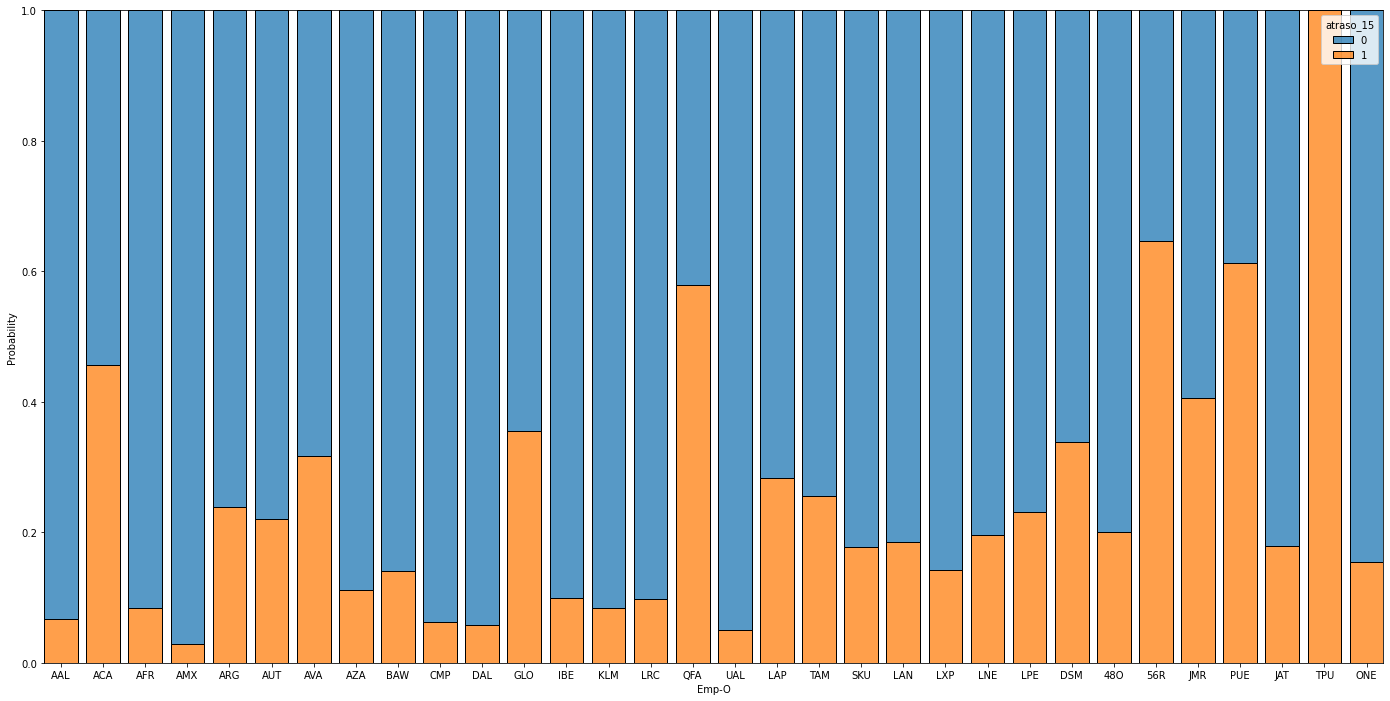

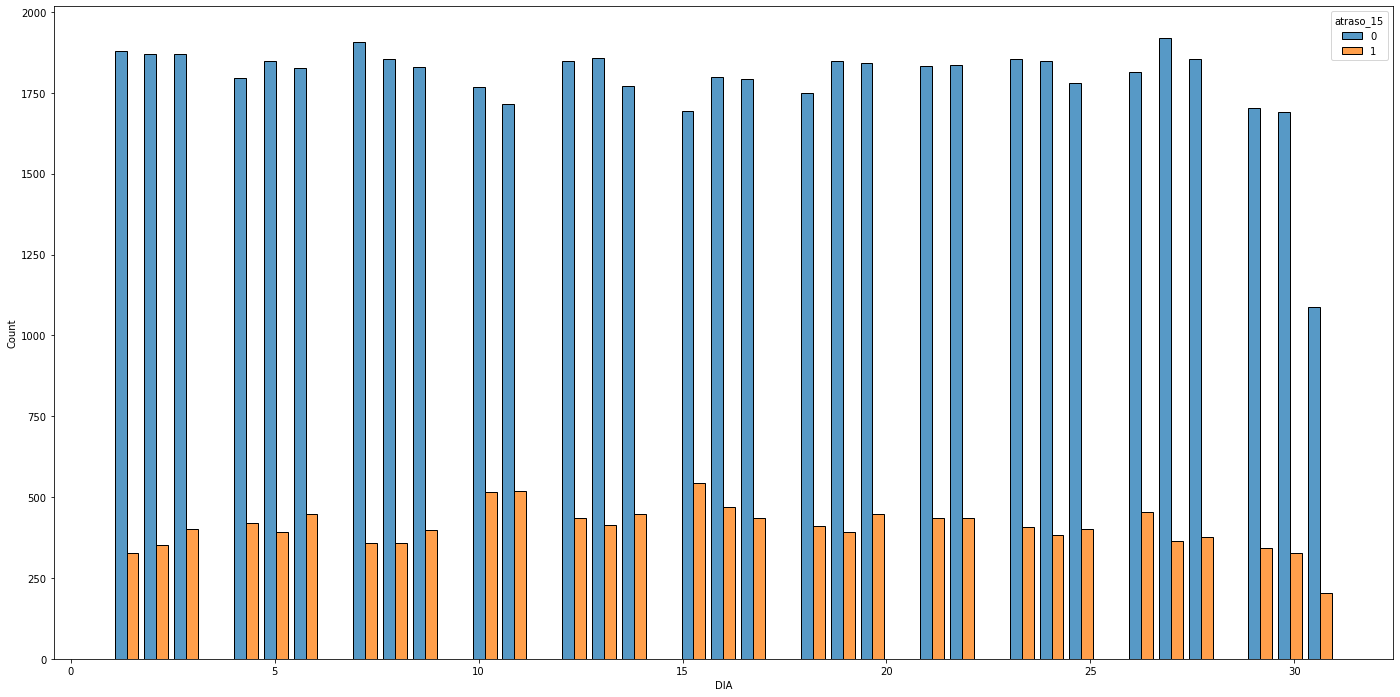

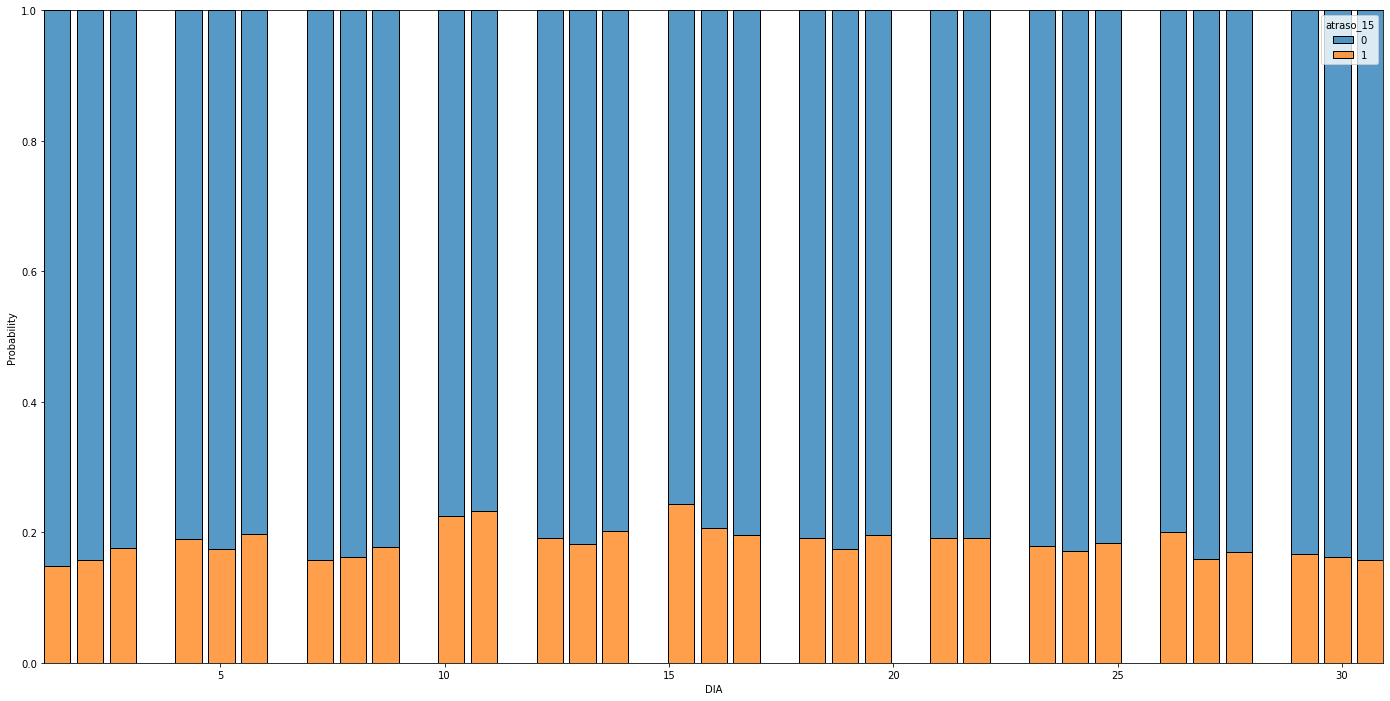

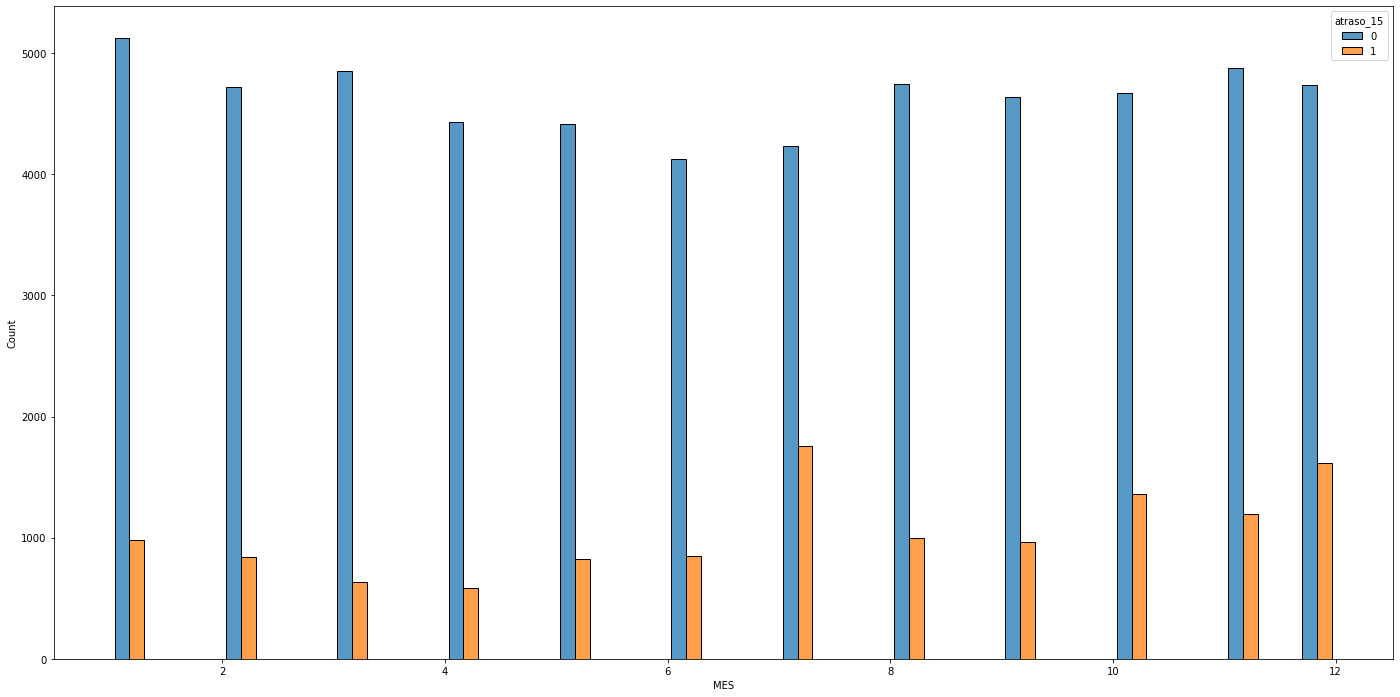

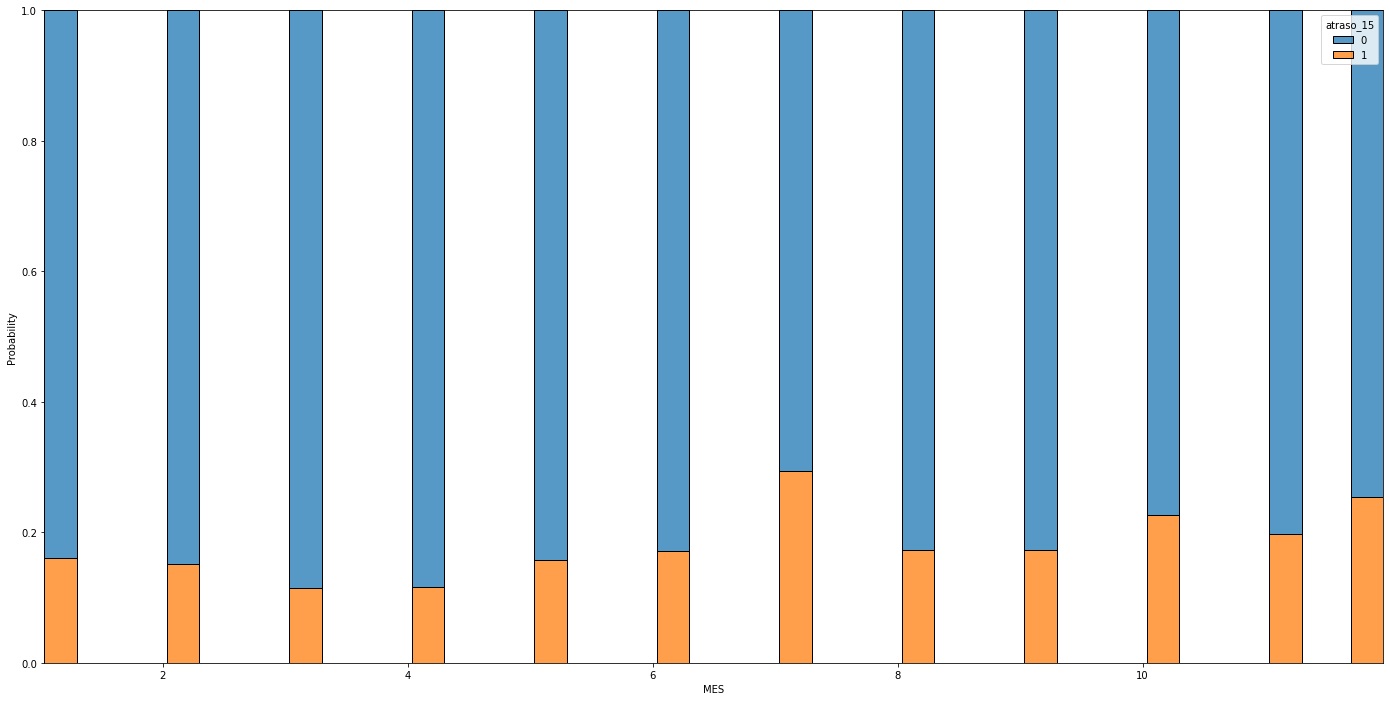

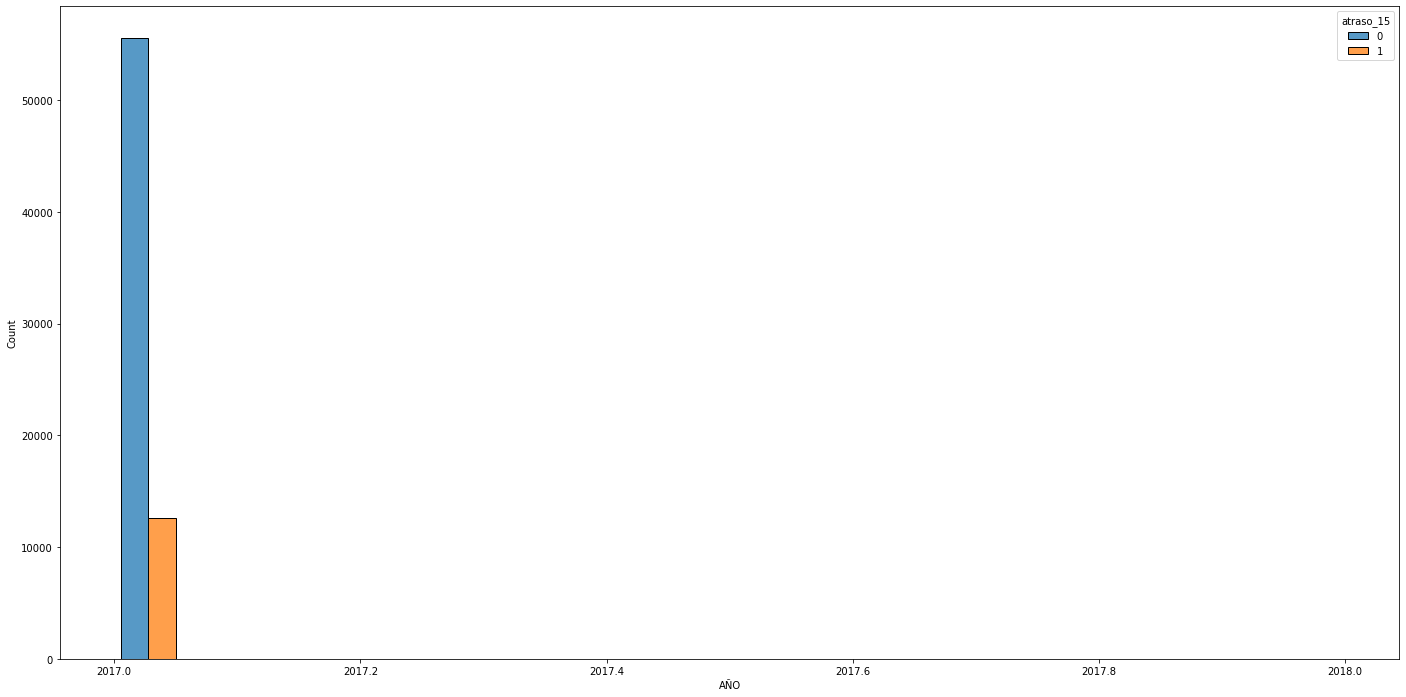

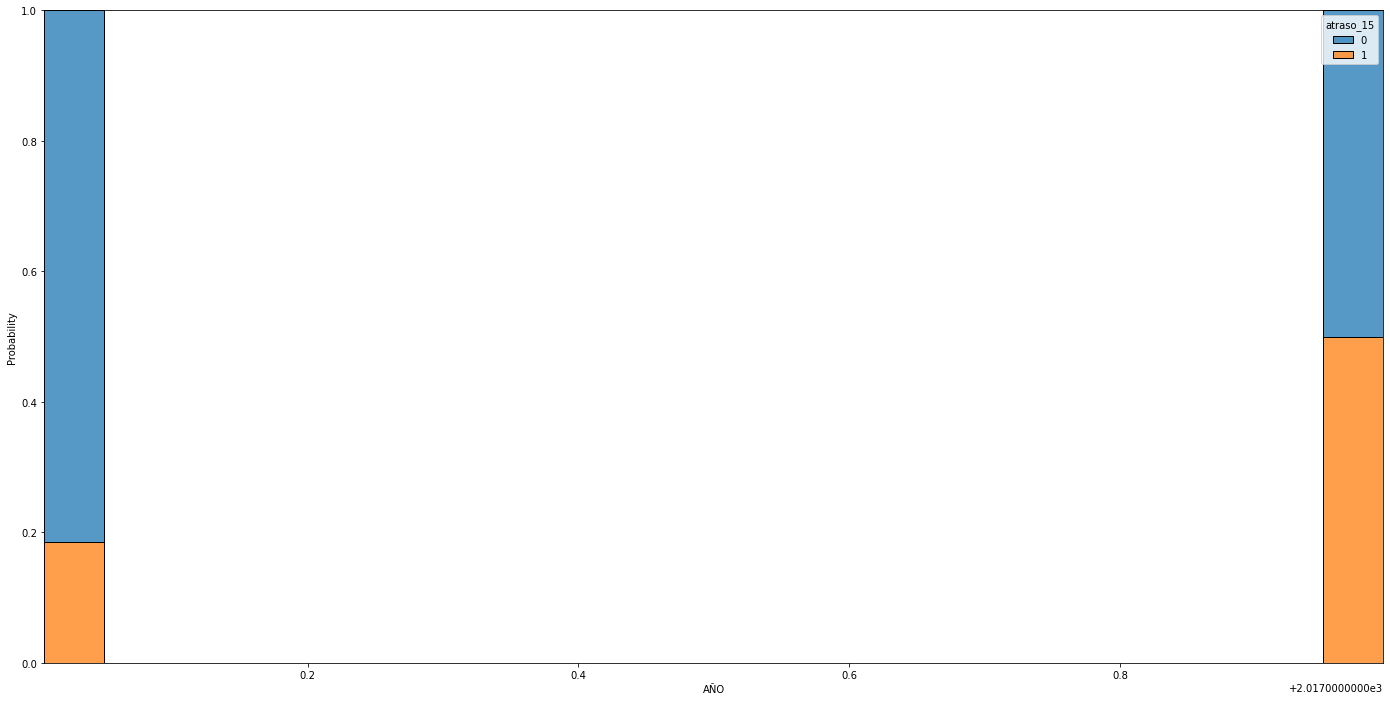

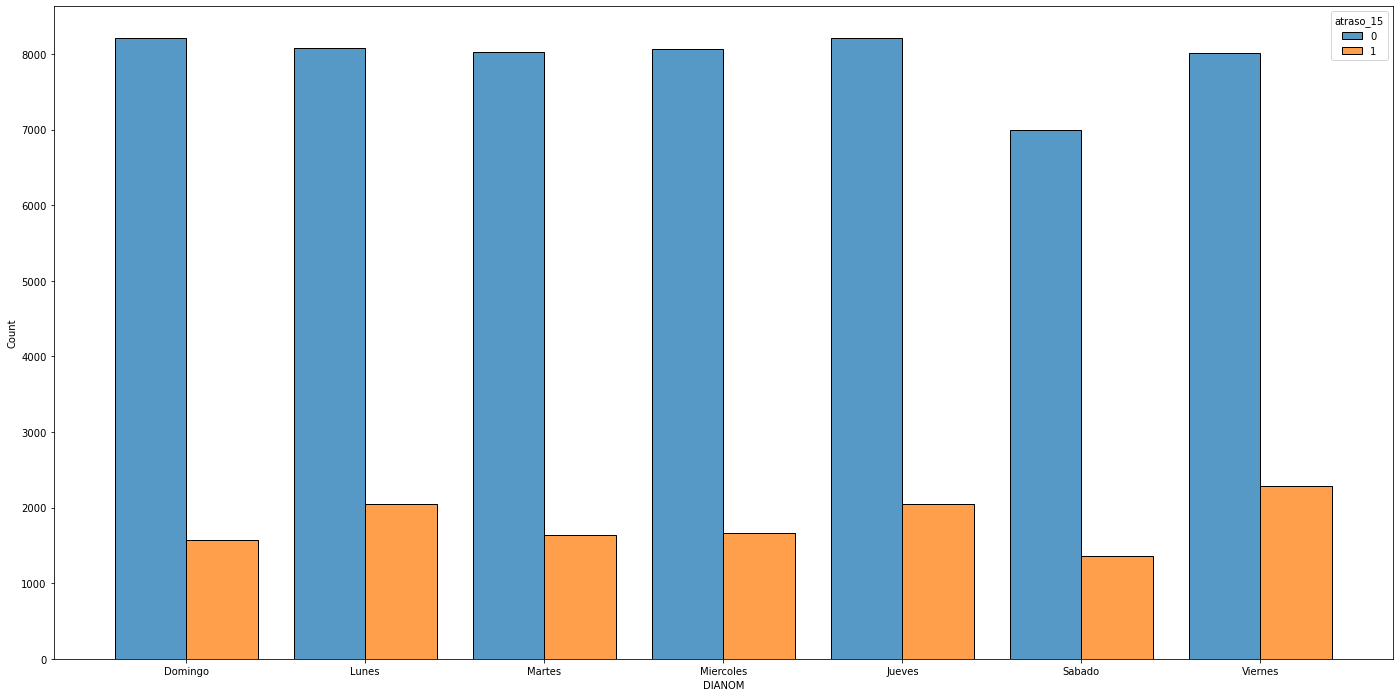

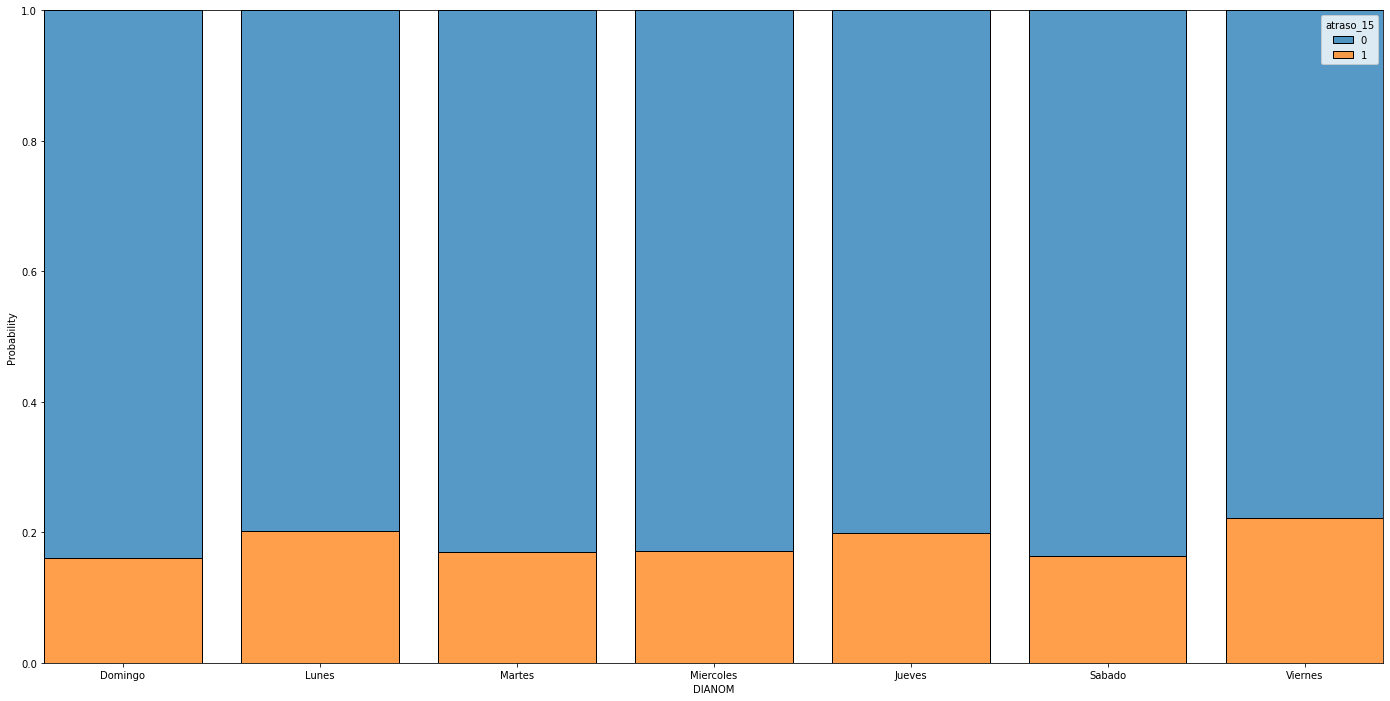

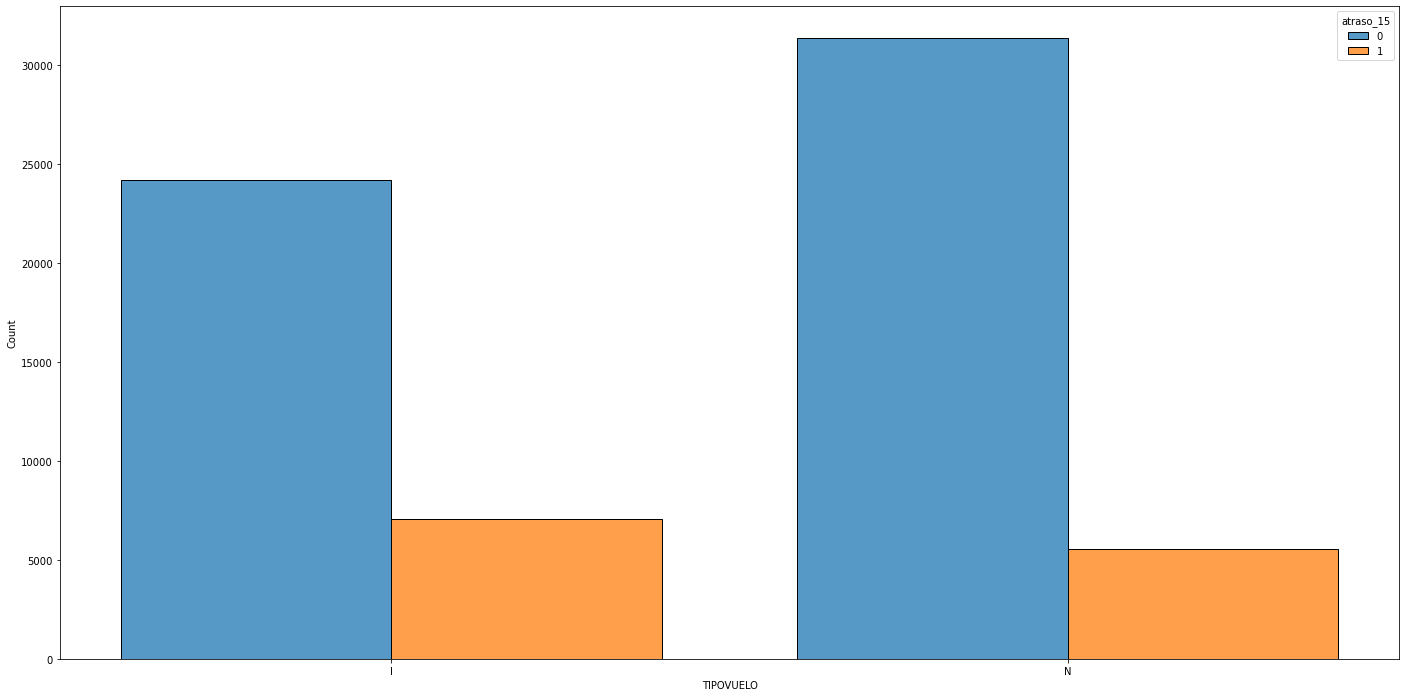

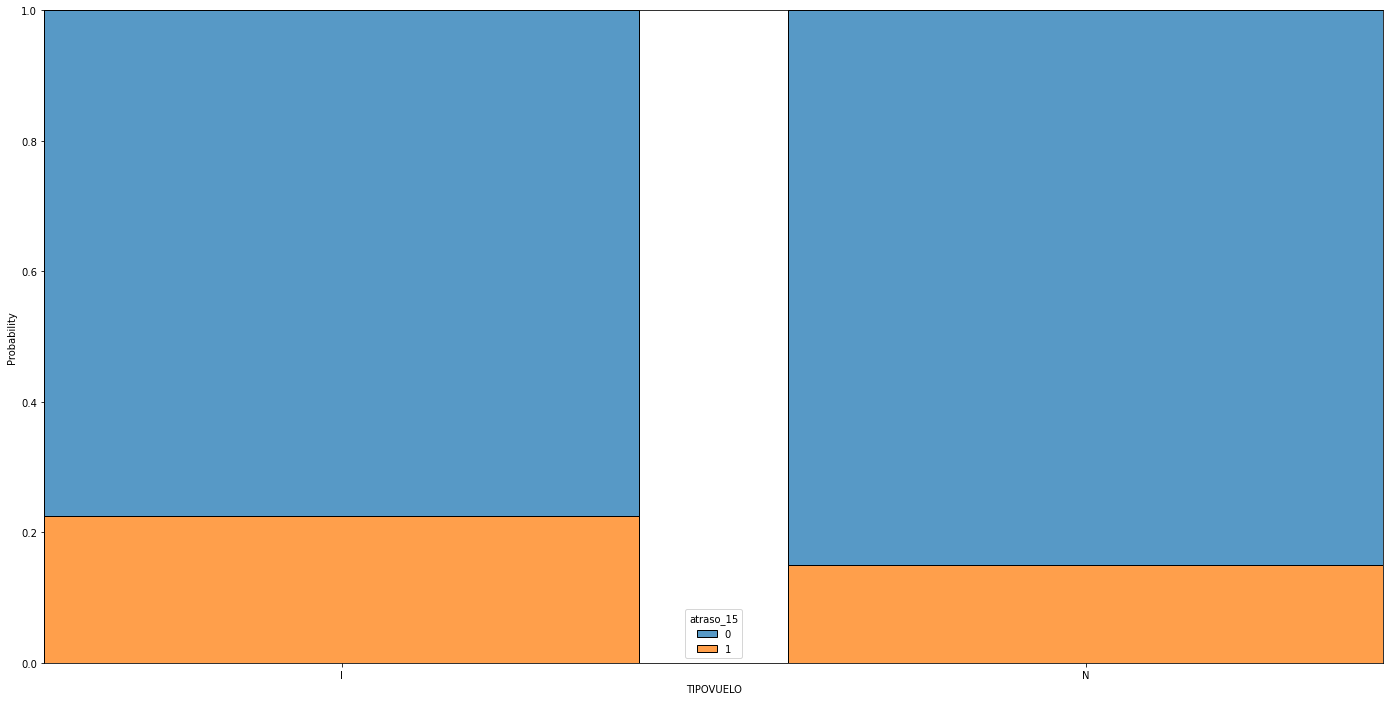

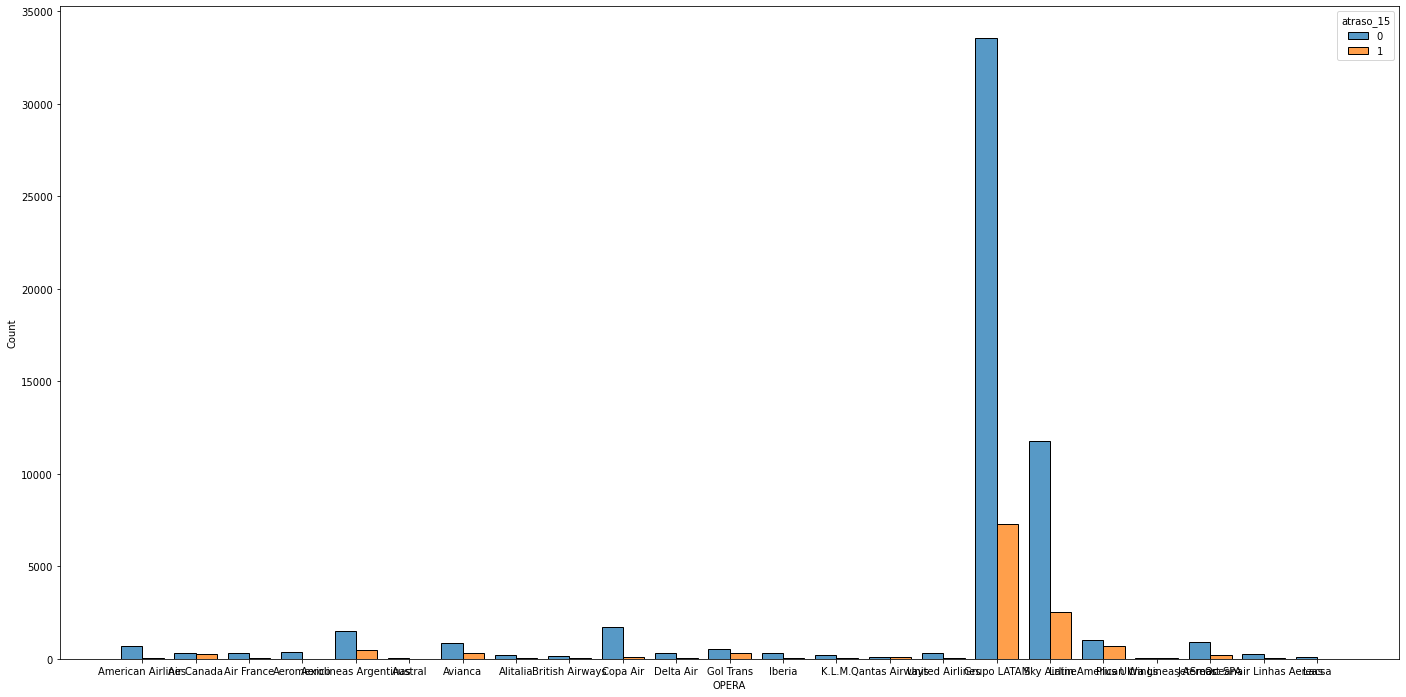

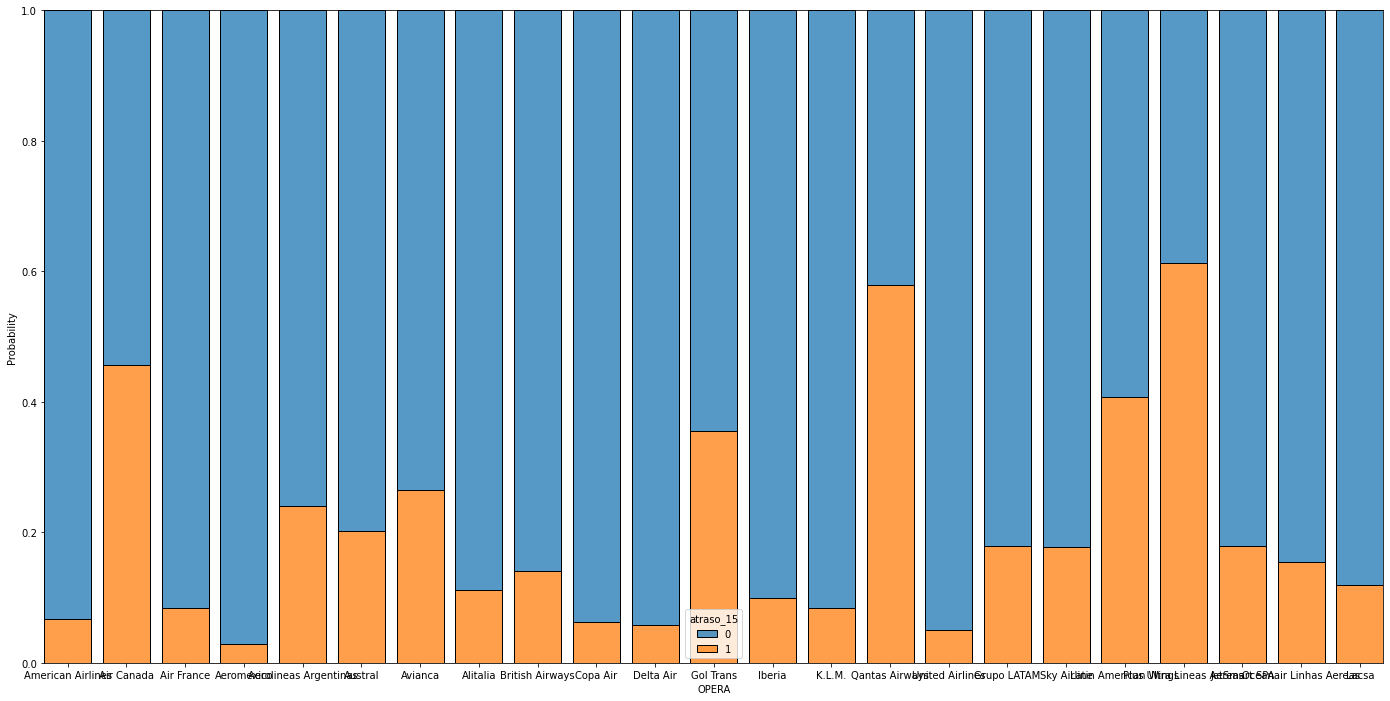

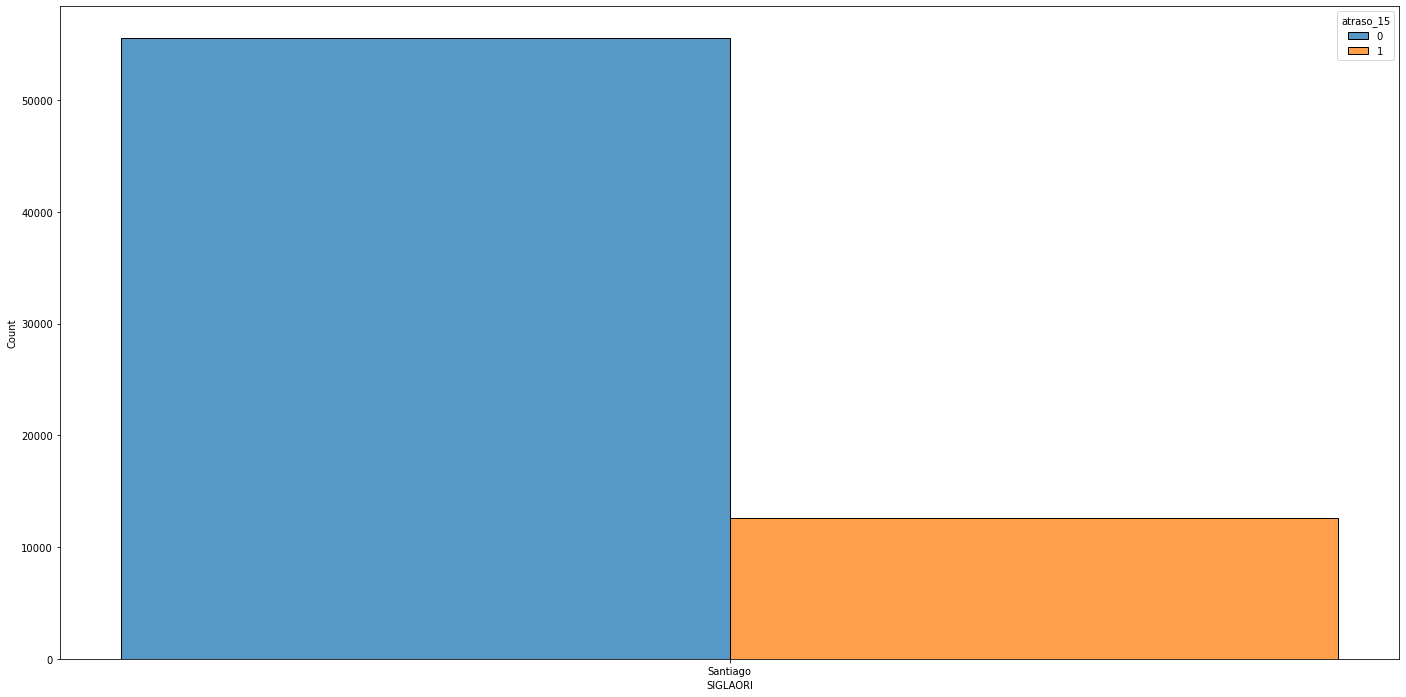

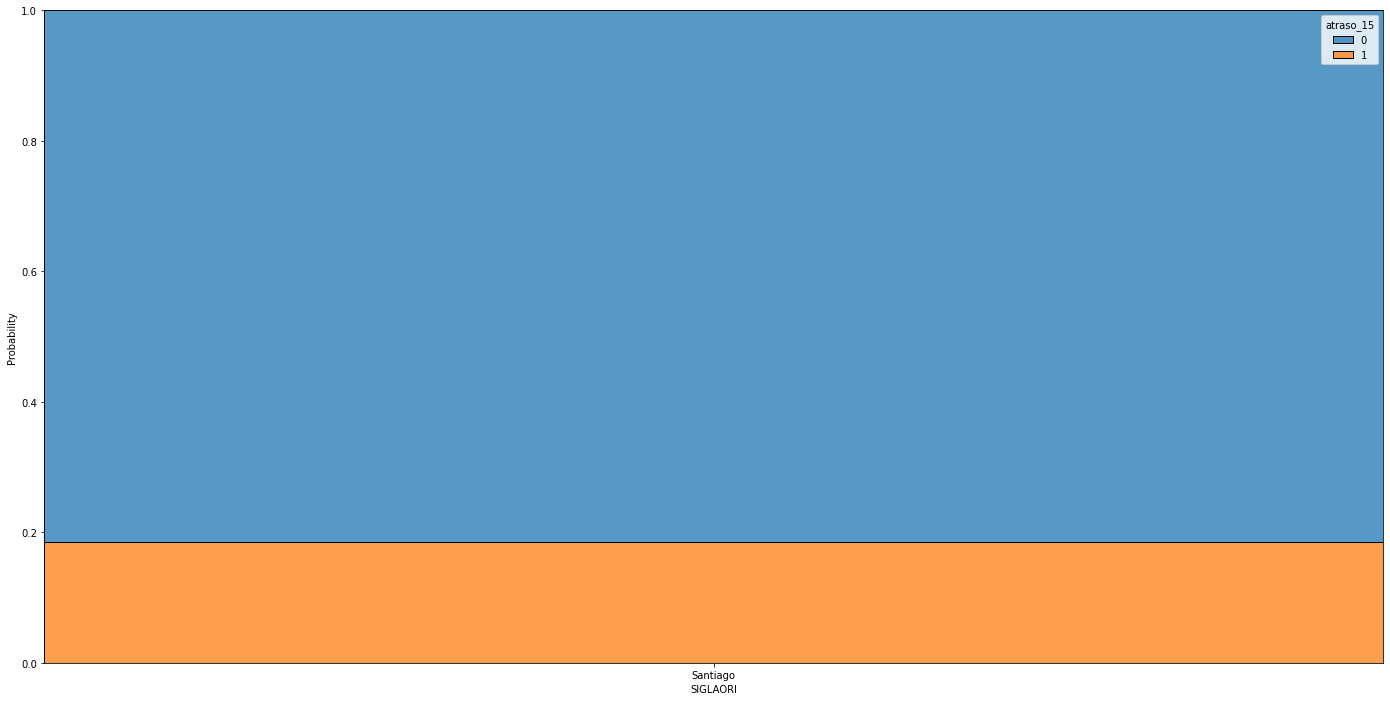

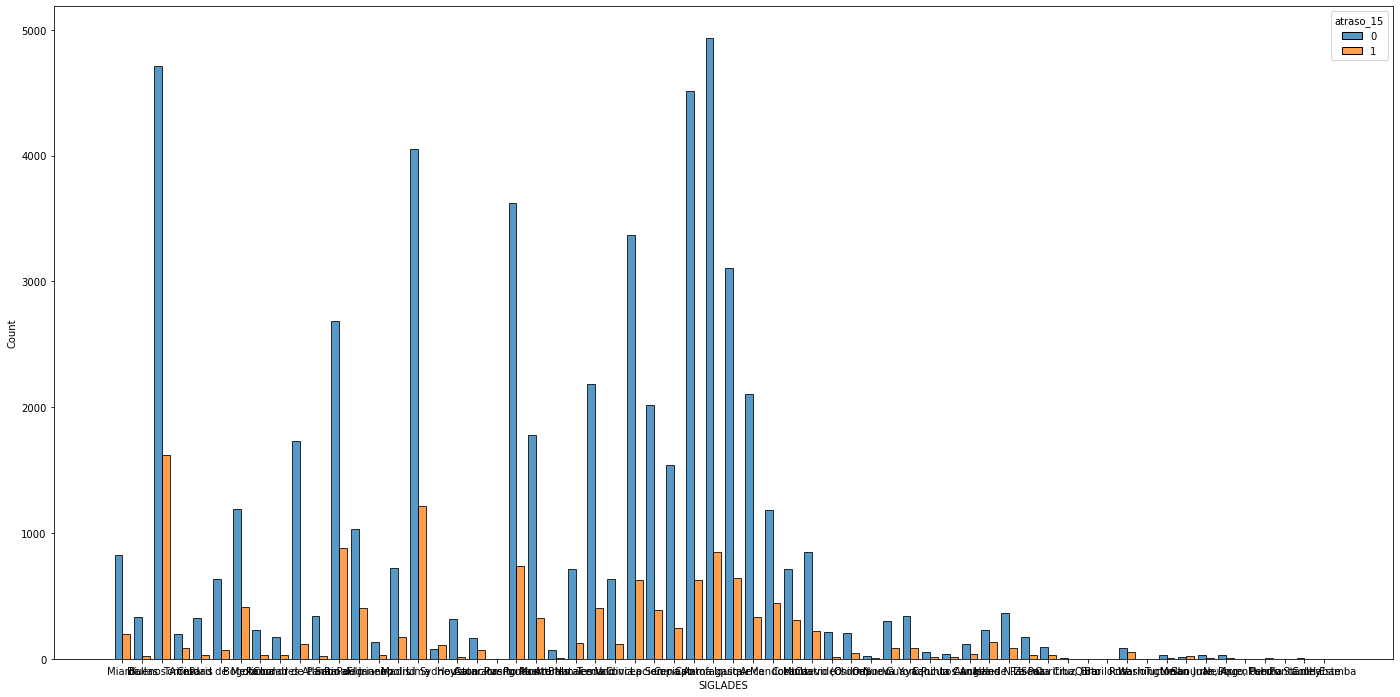

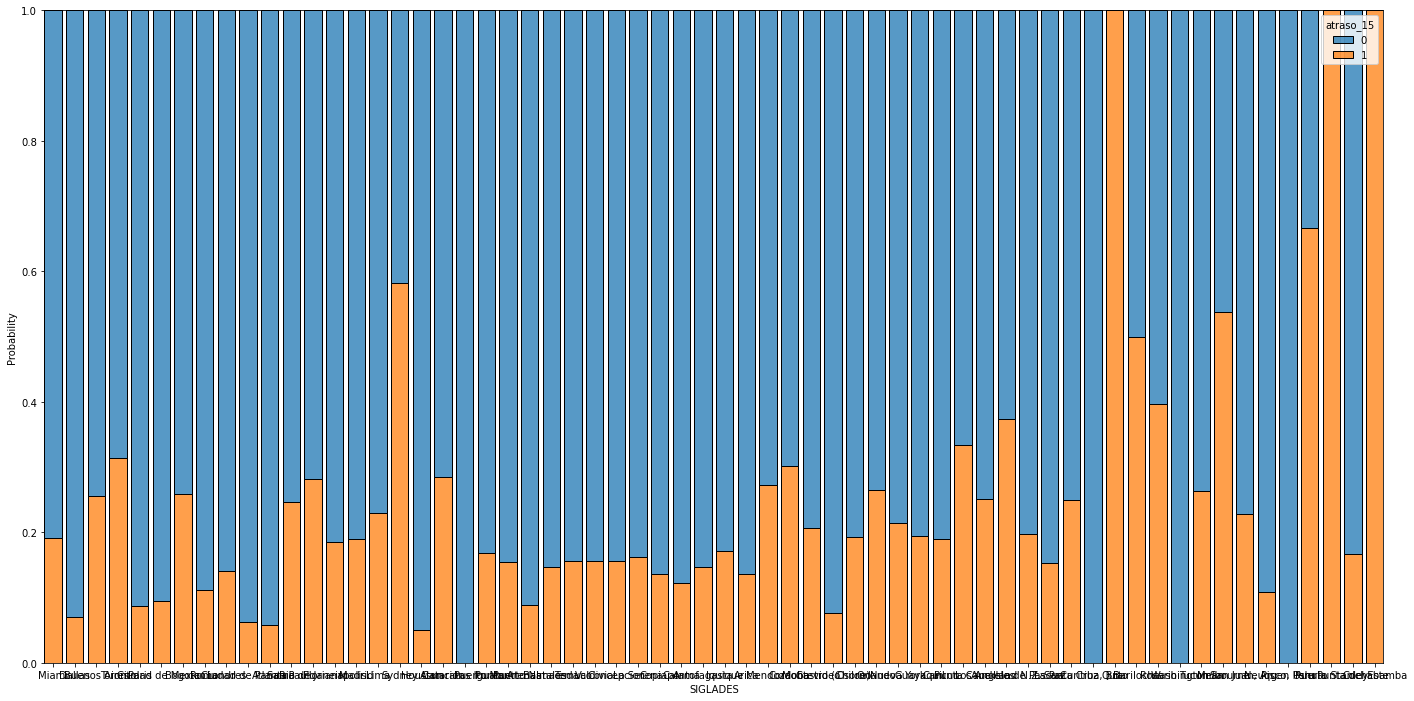

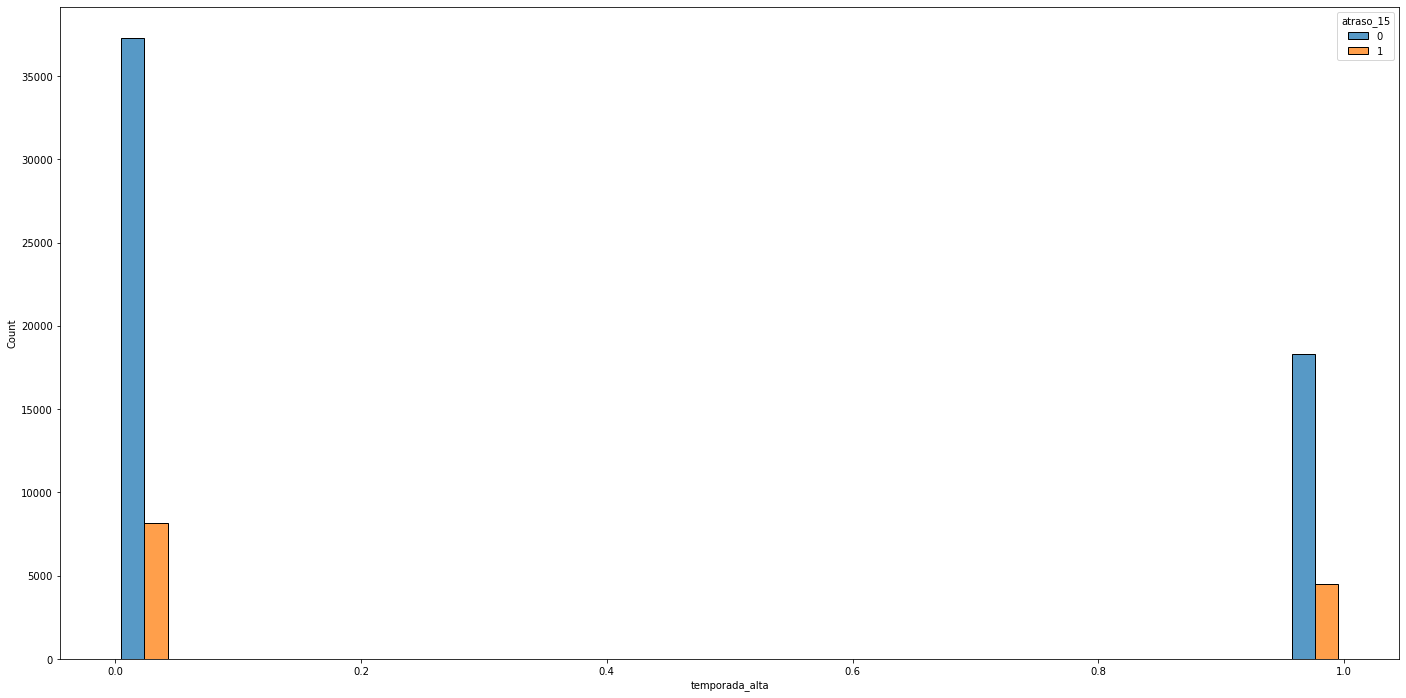

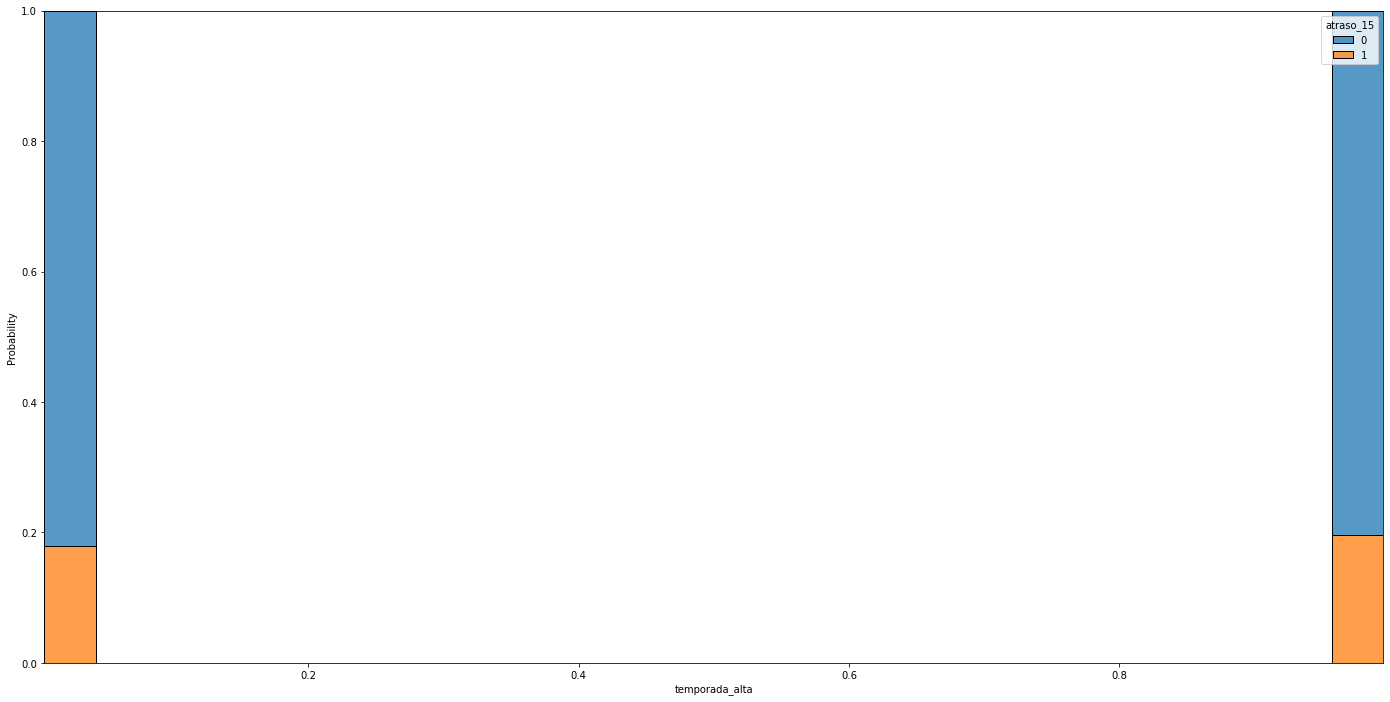

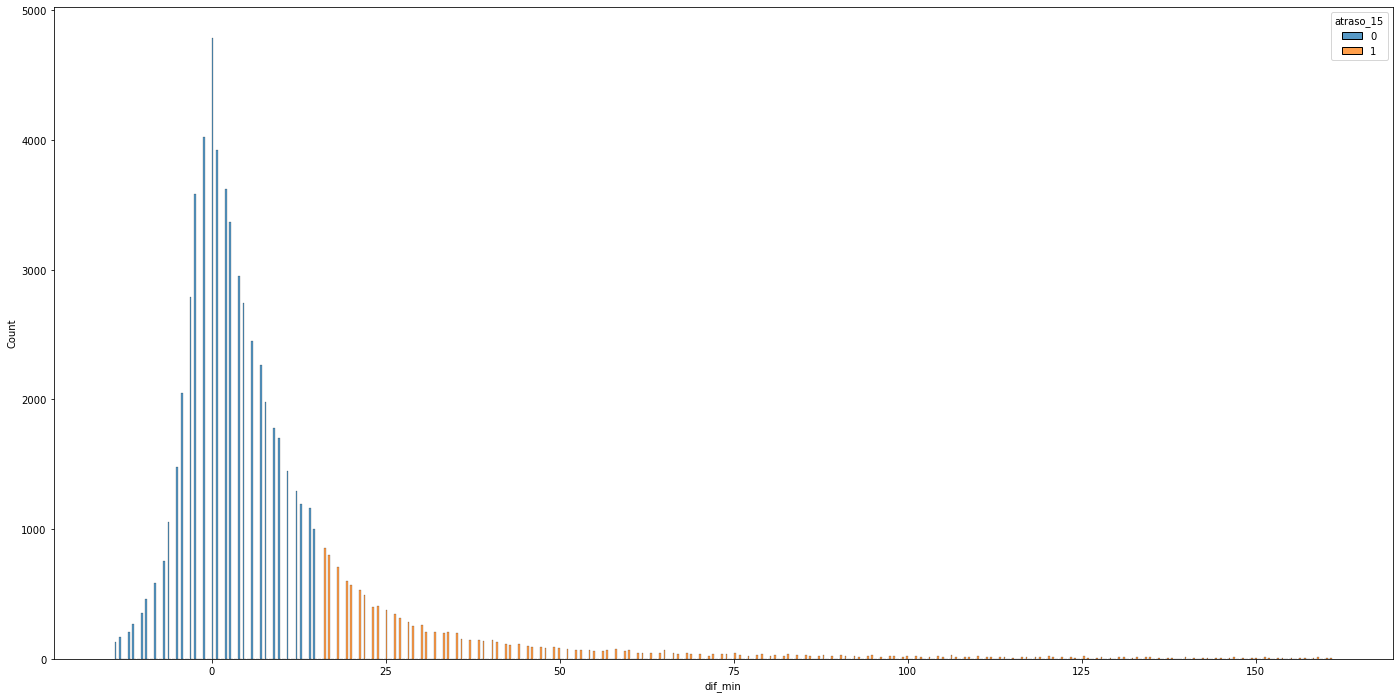

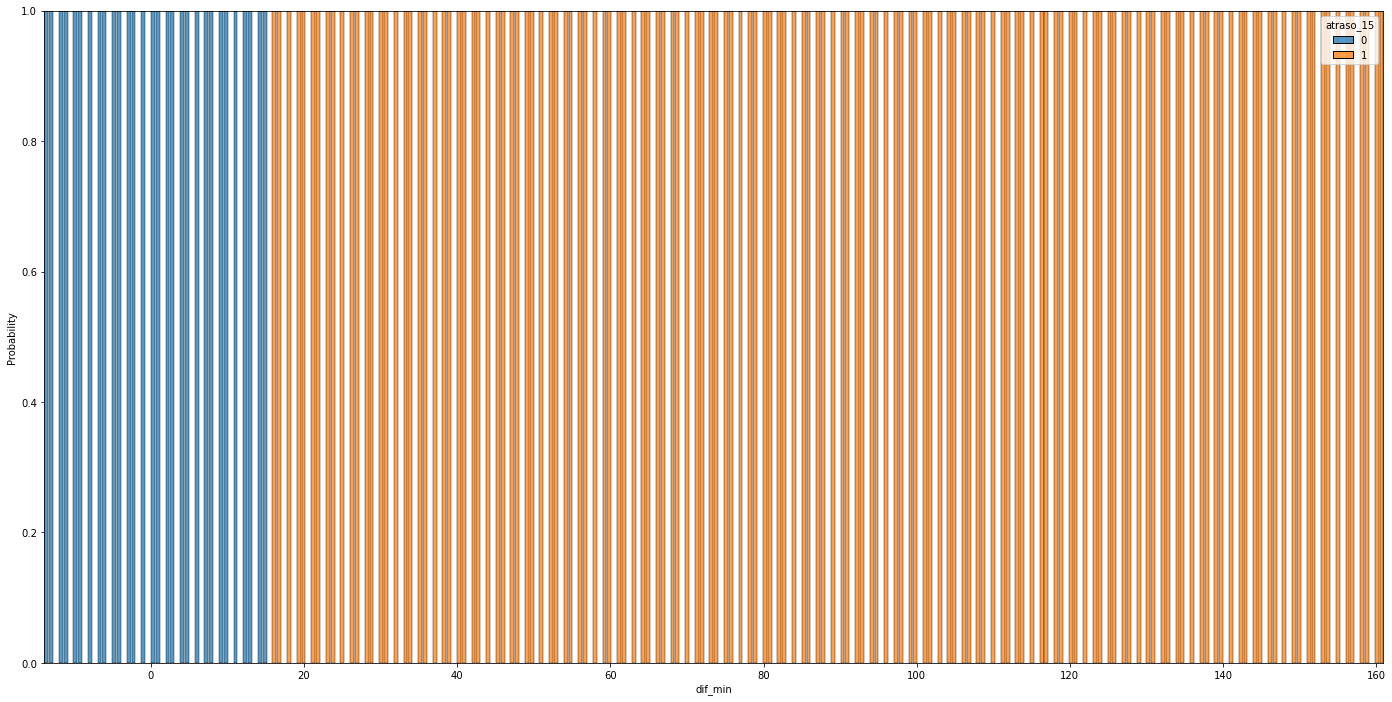

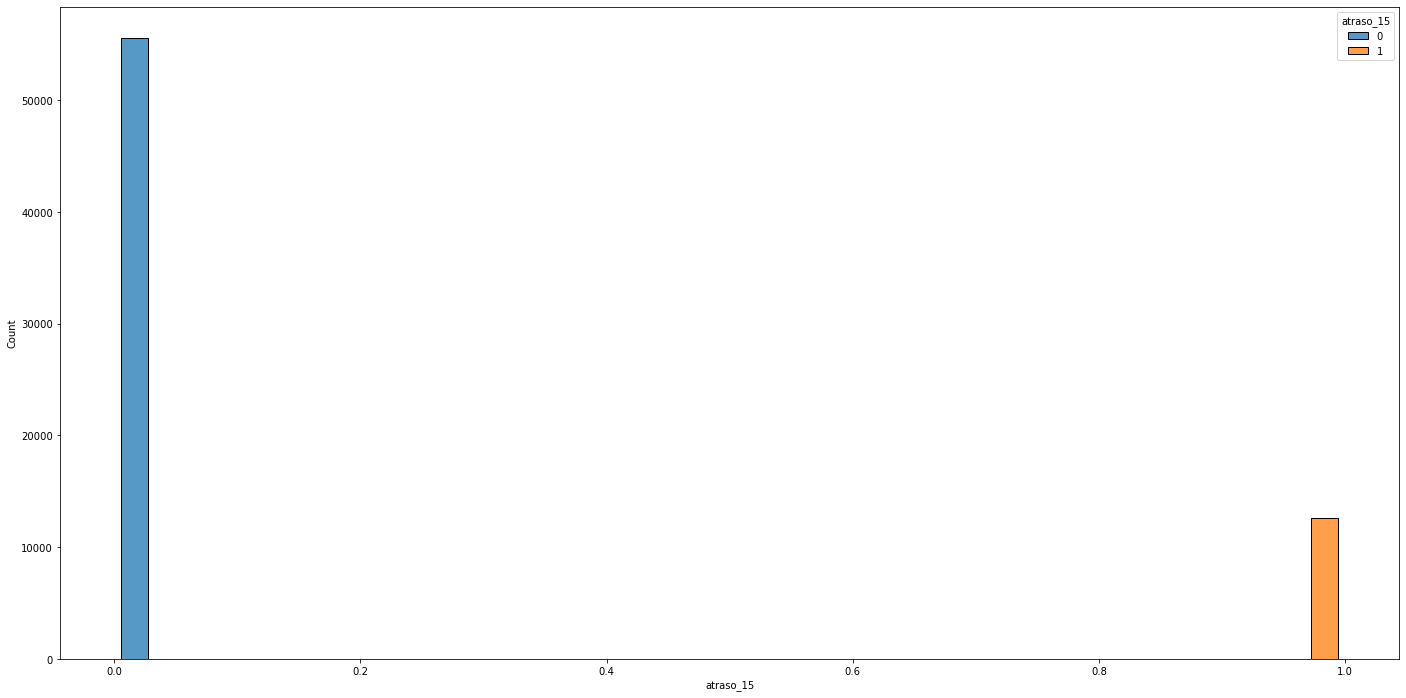

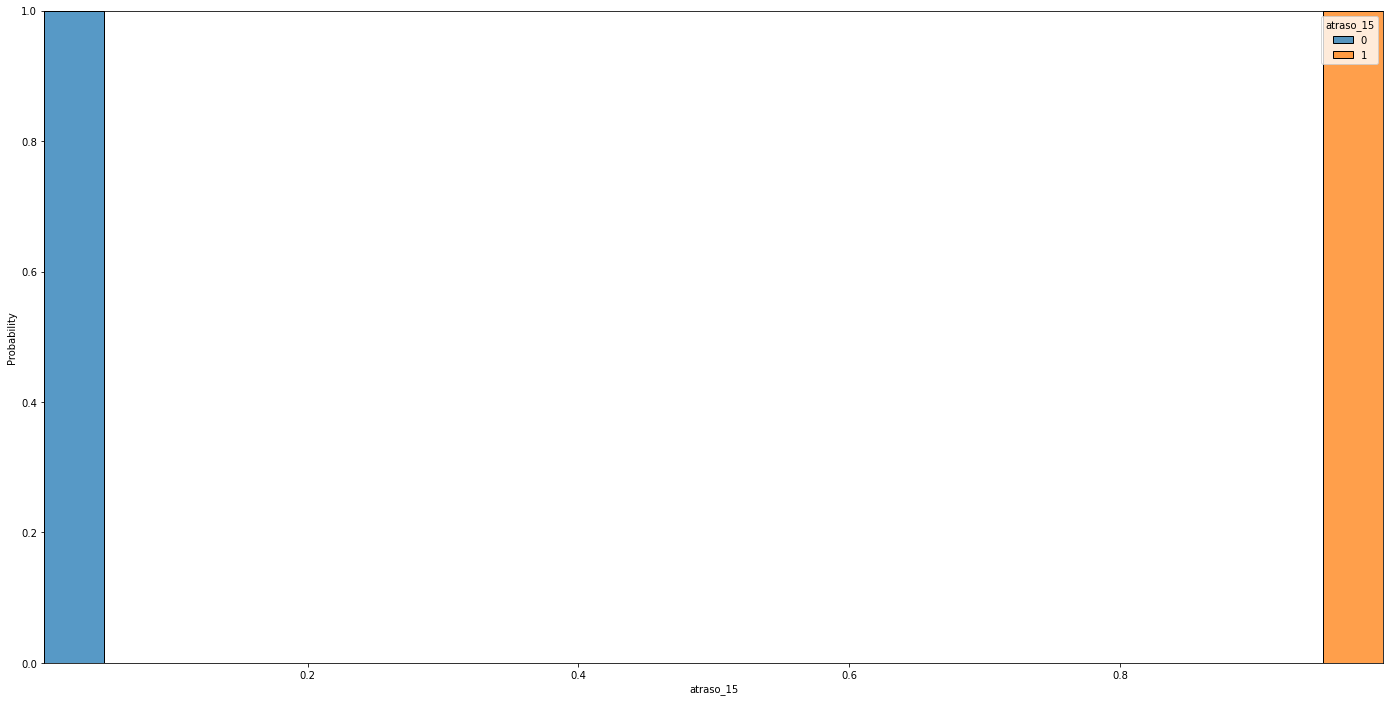

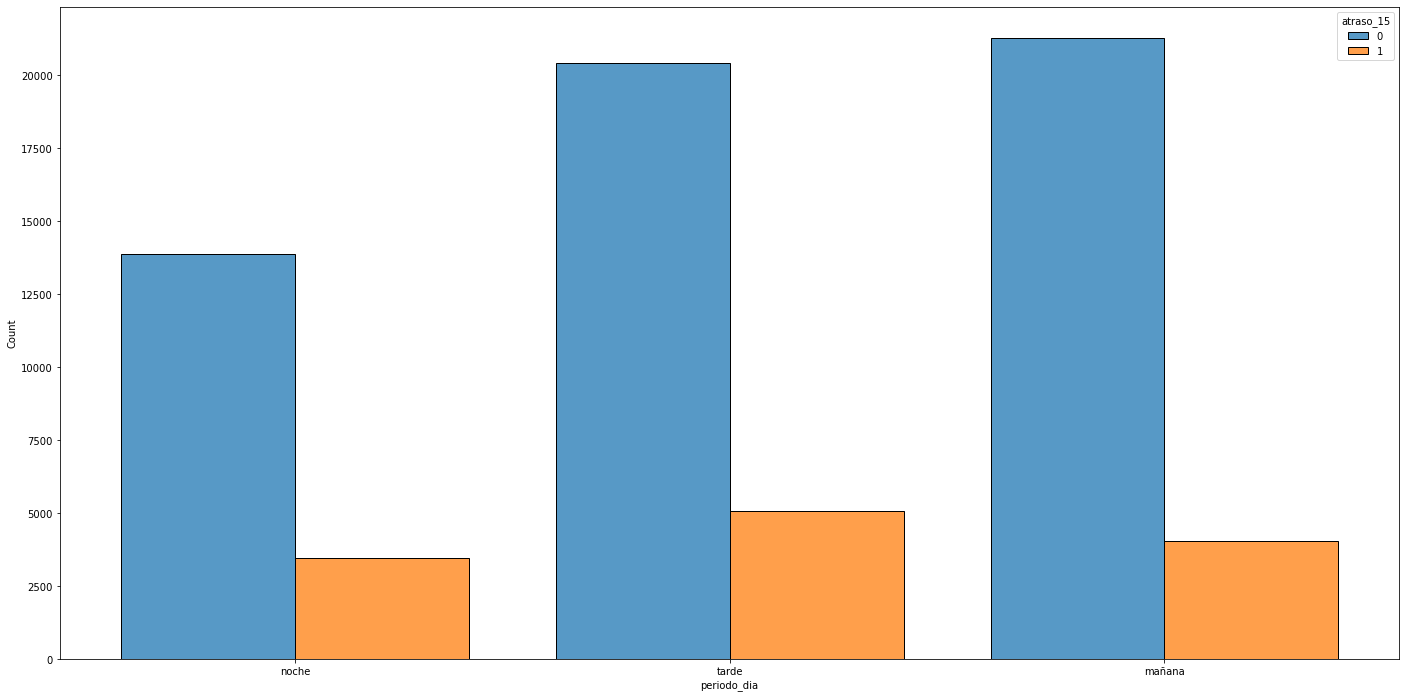

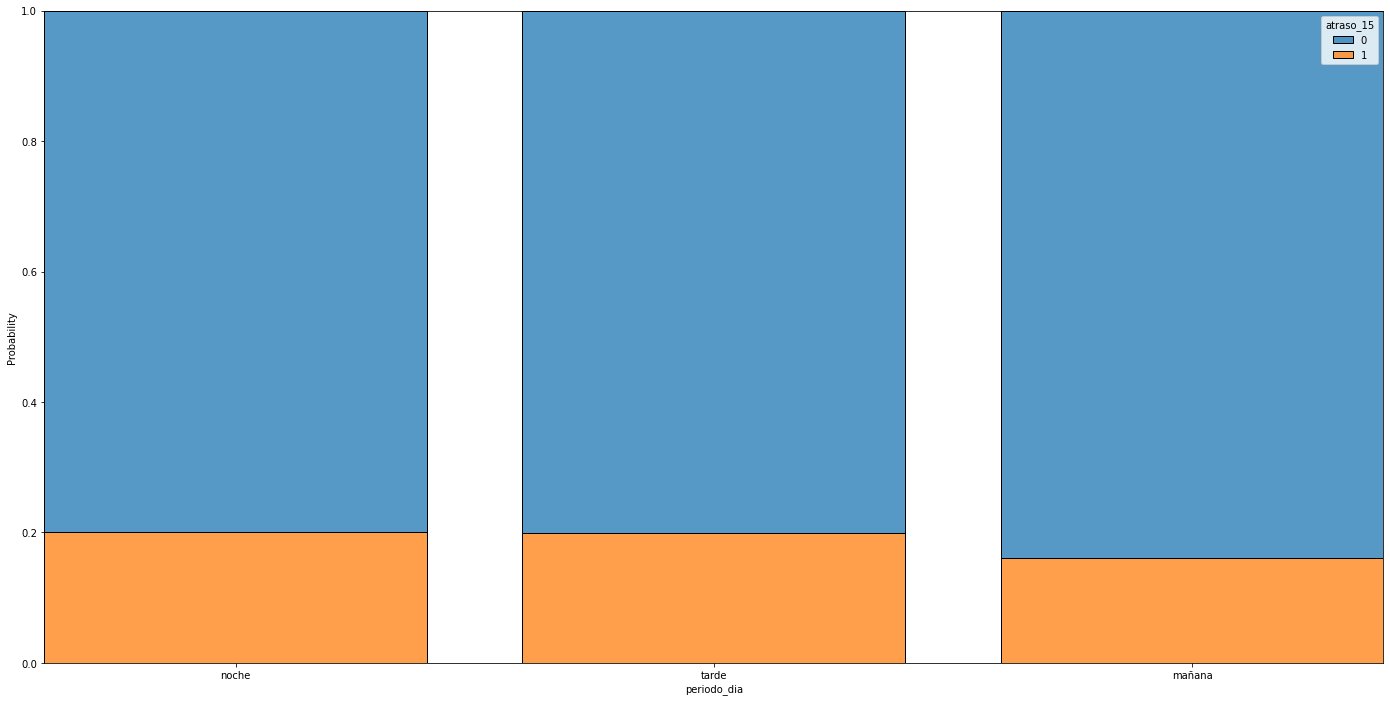

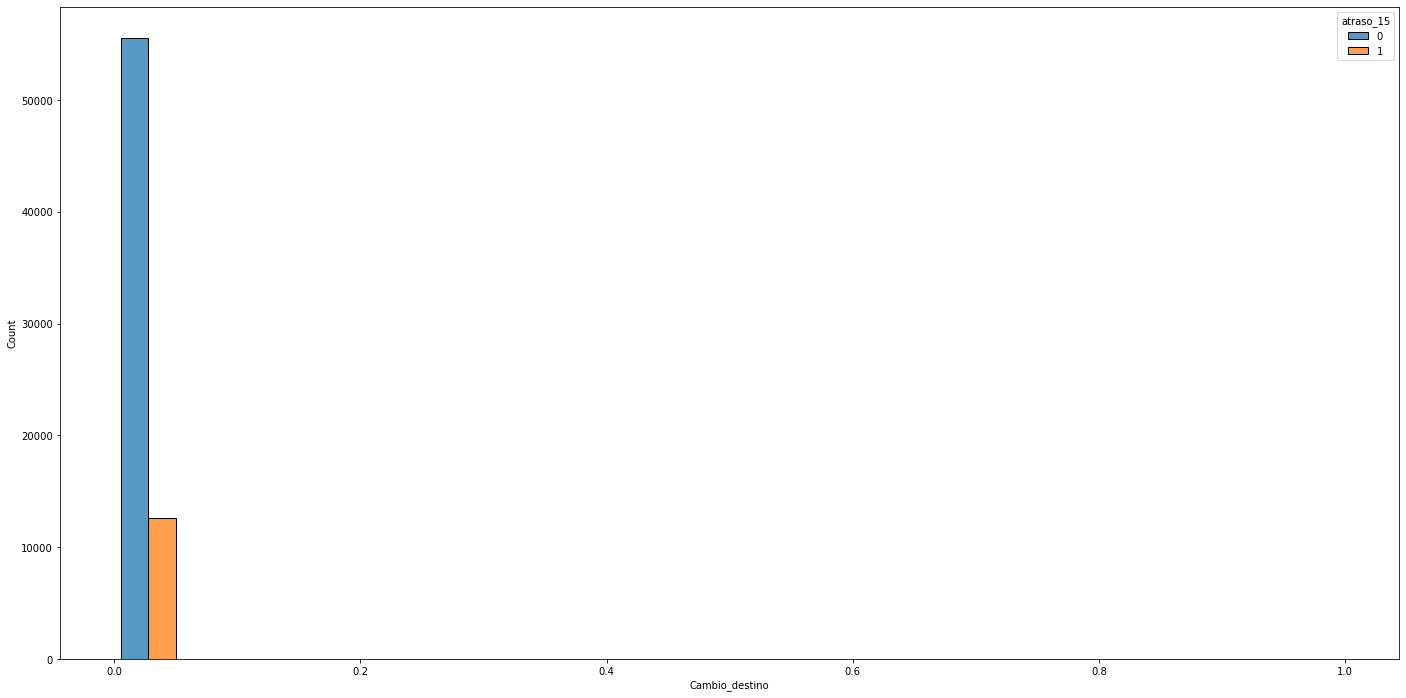

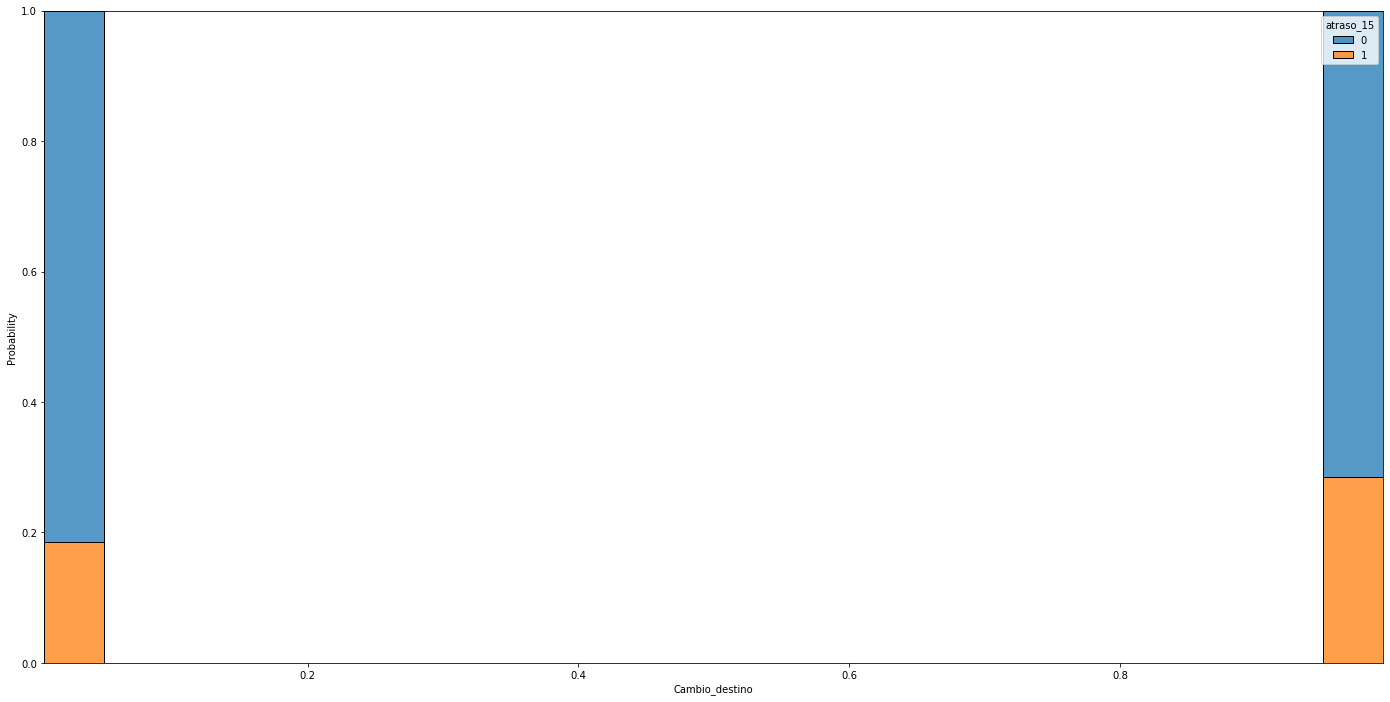

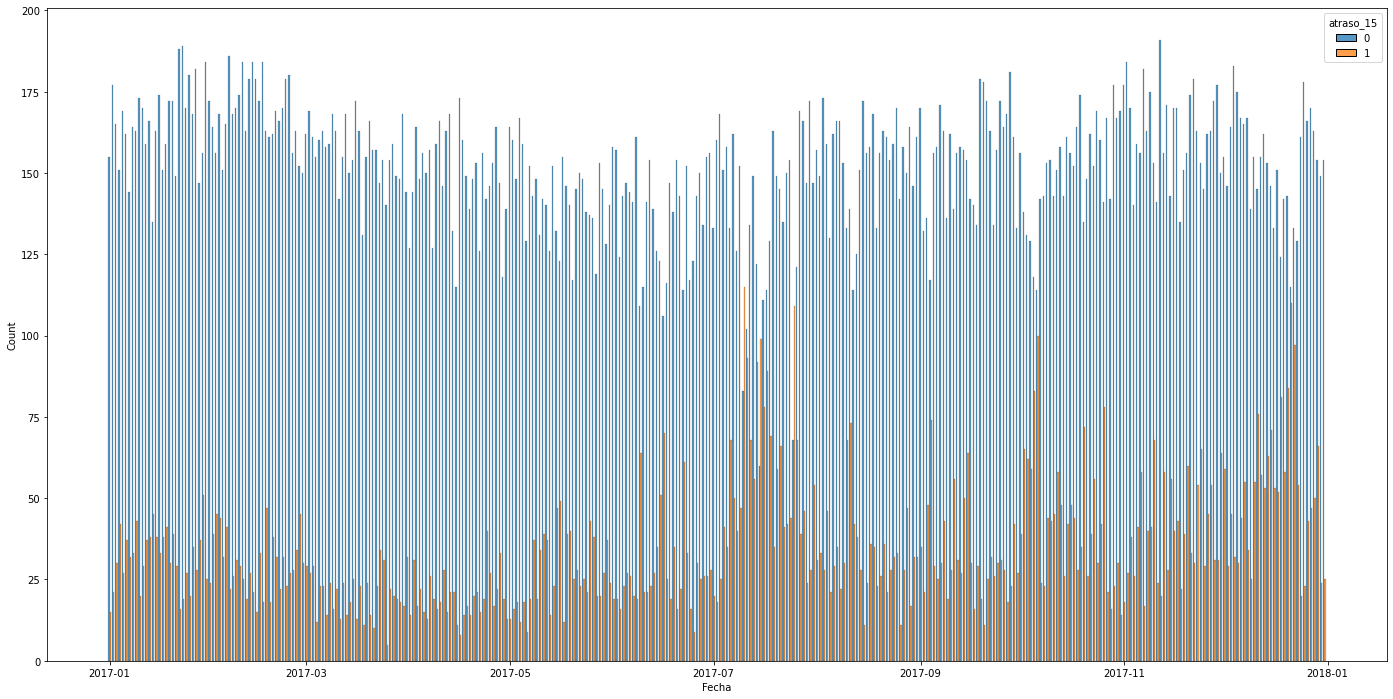

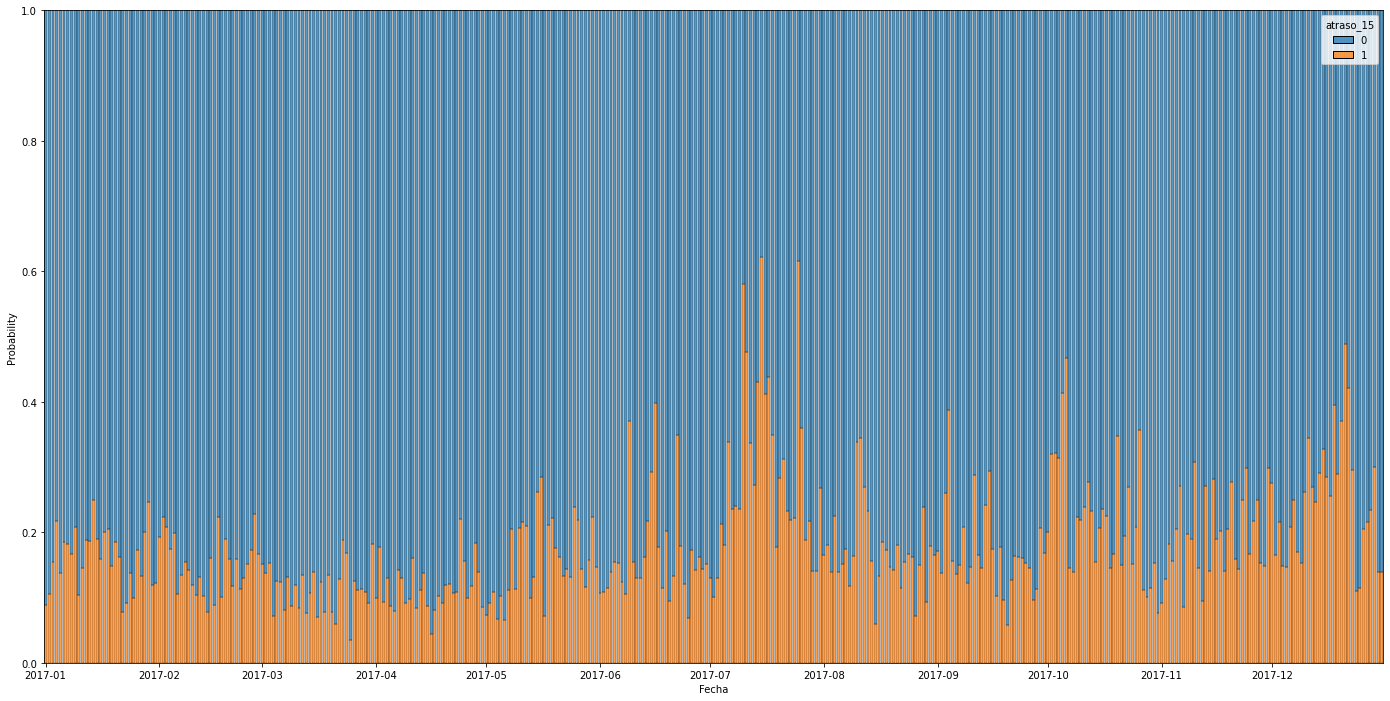

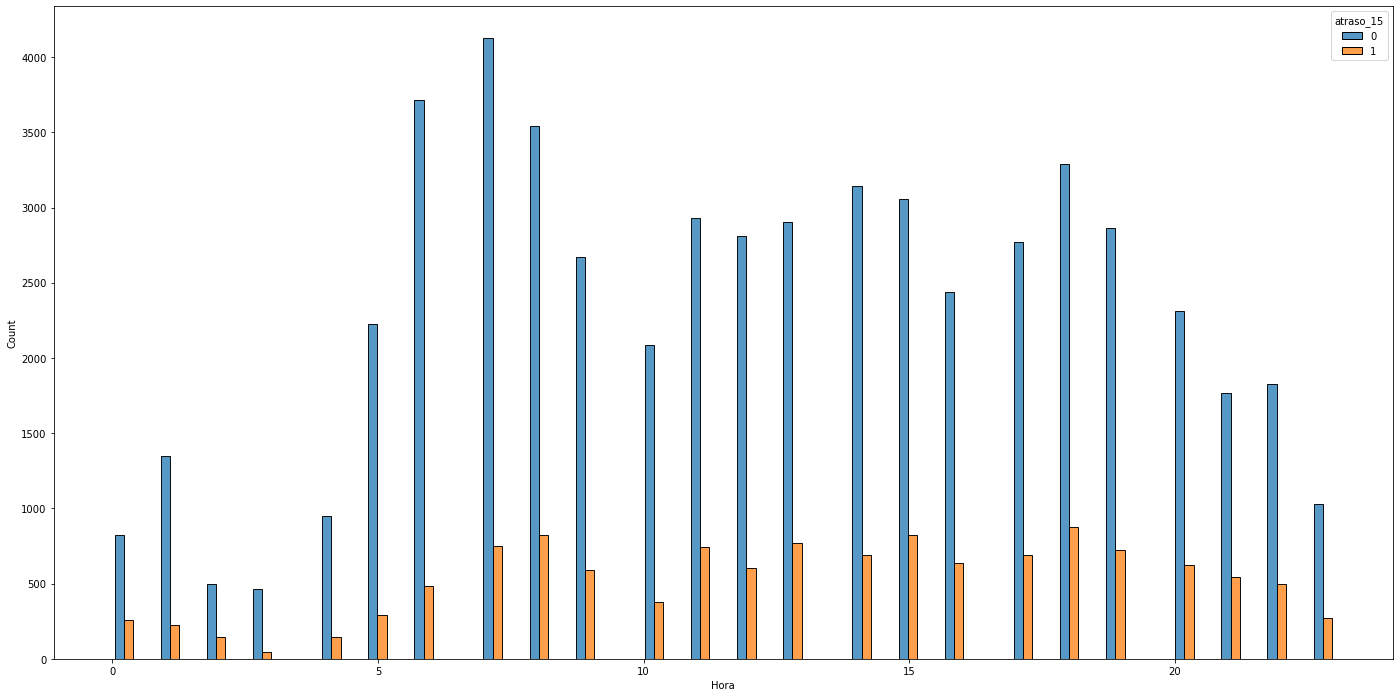

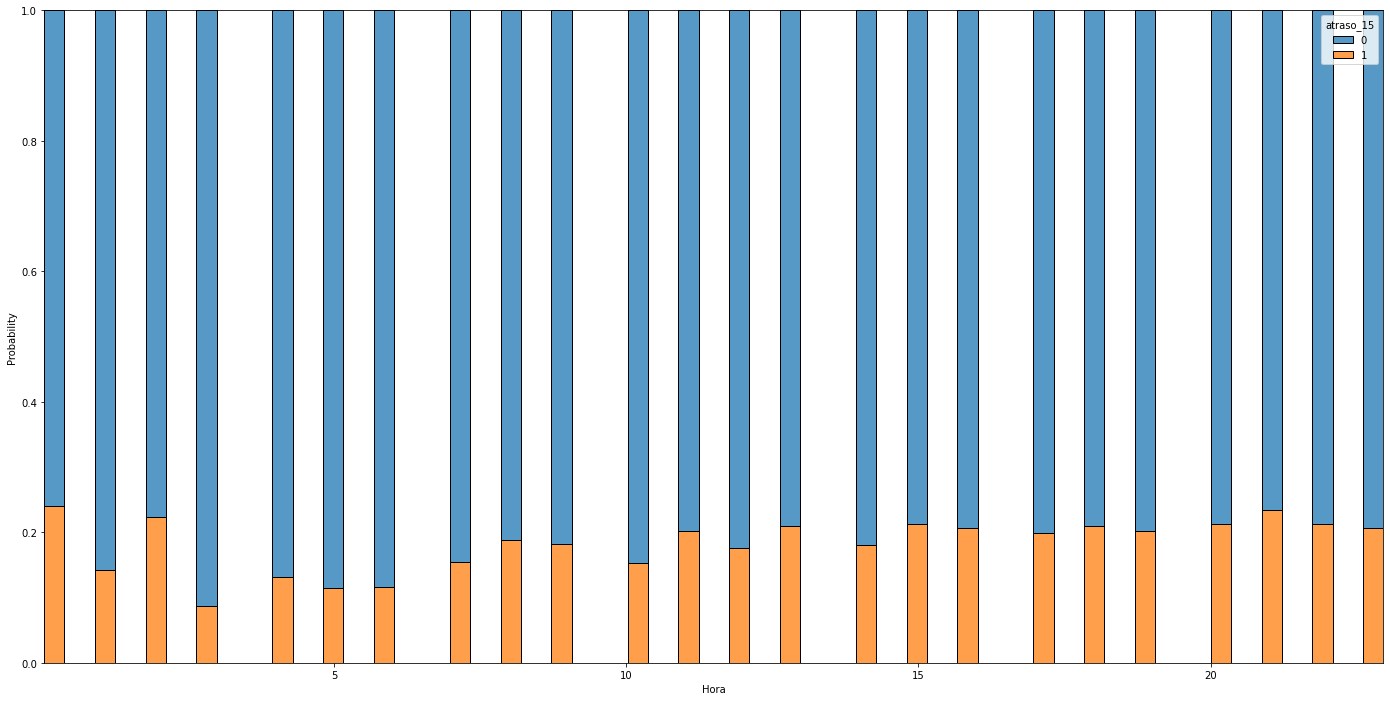

In [50]:
for n in range(len(df2.columns)):
    plt.figure(figsize=(24, 12))
    sns.histplot(data=df, x=list(df2.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(24, 12))
    sns.histplot(data=df, x=list(df2.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()


### Bar_charts_new_variables

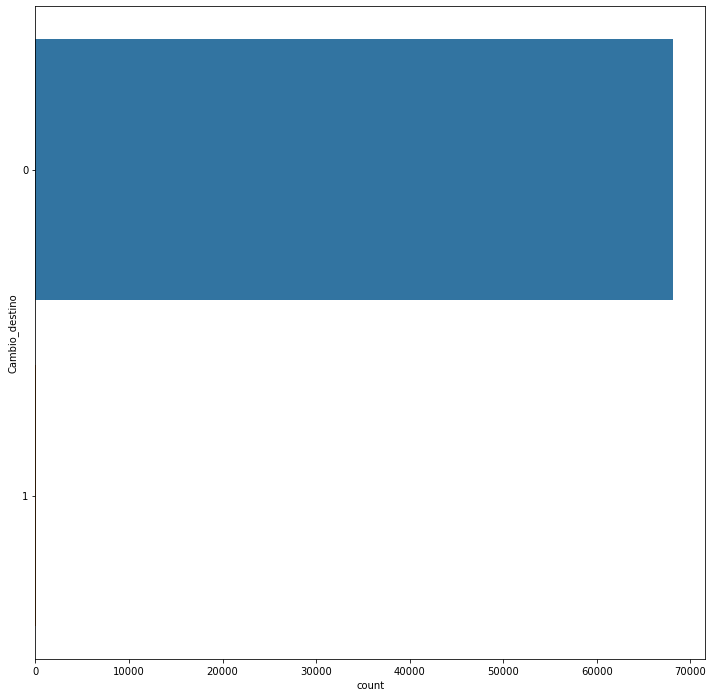

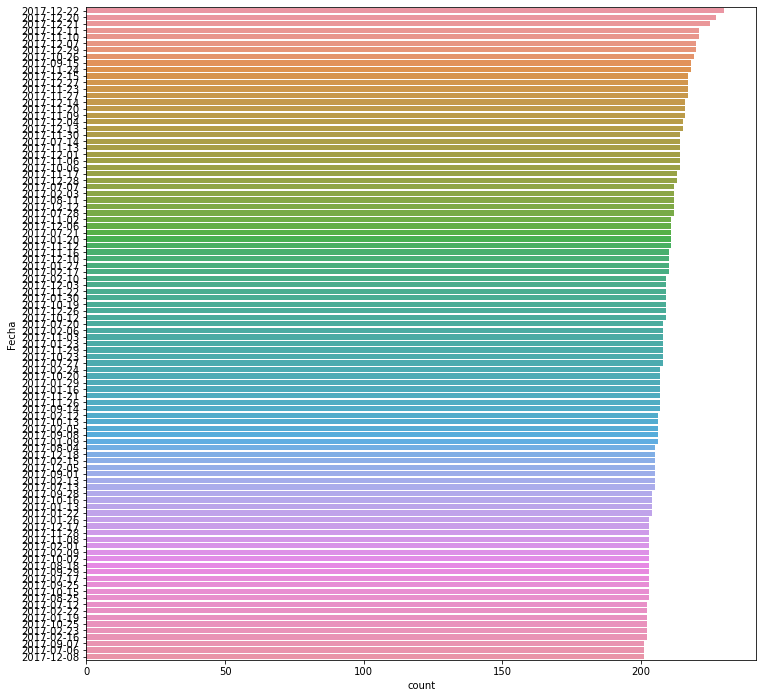

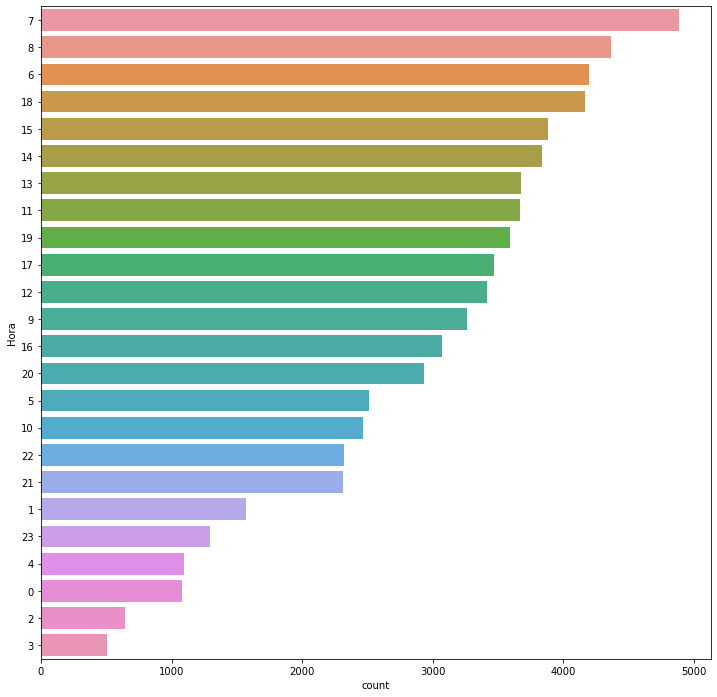

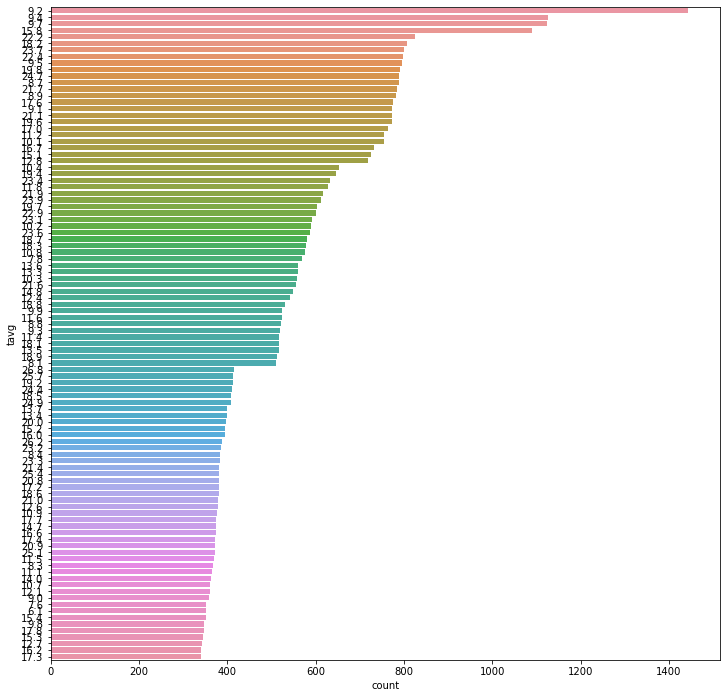

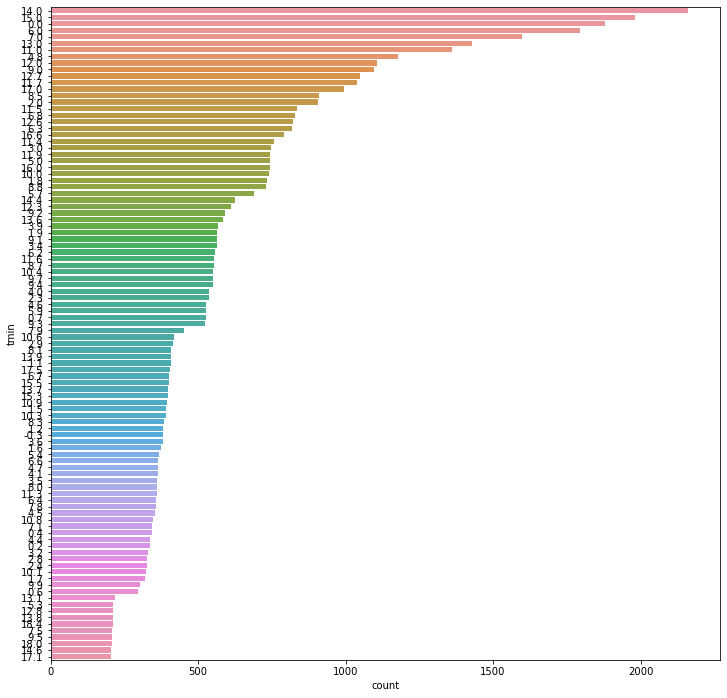

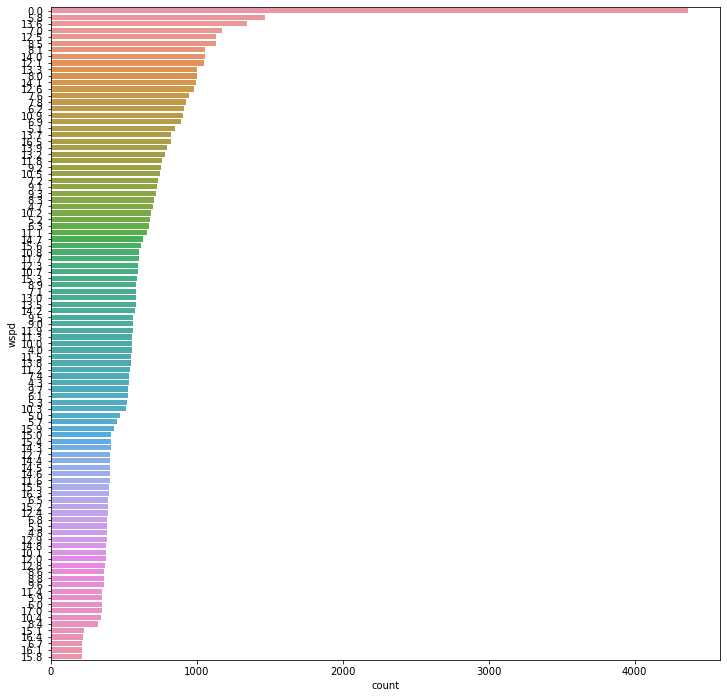

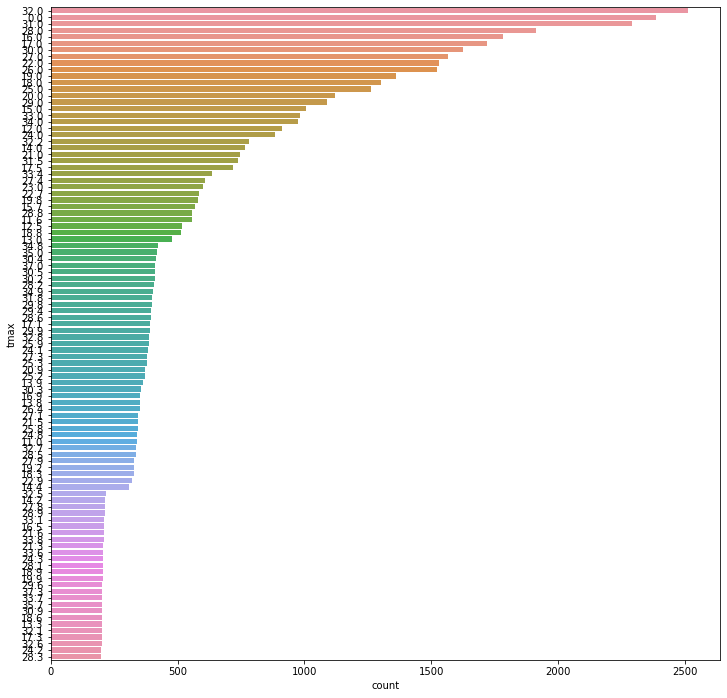

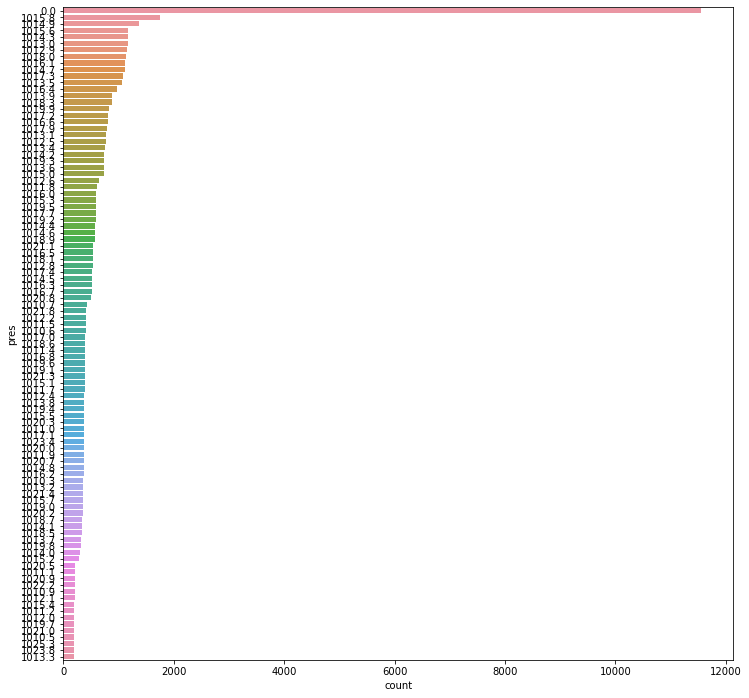

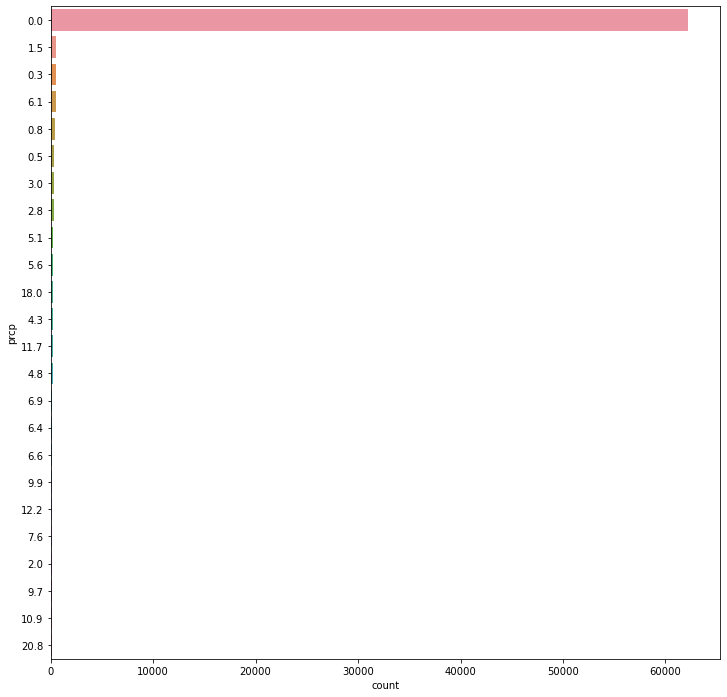

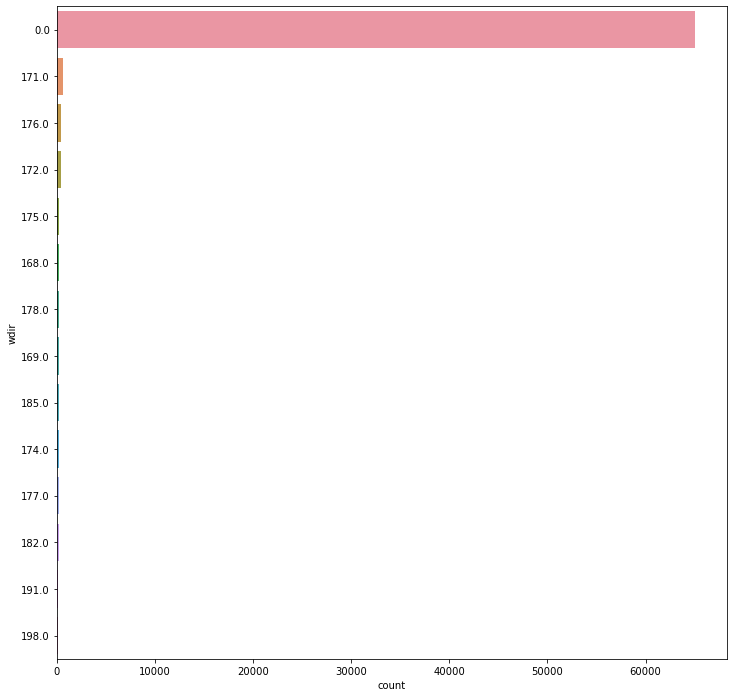

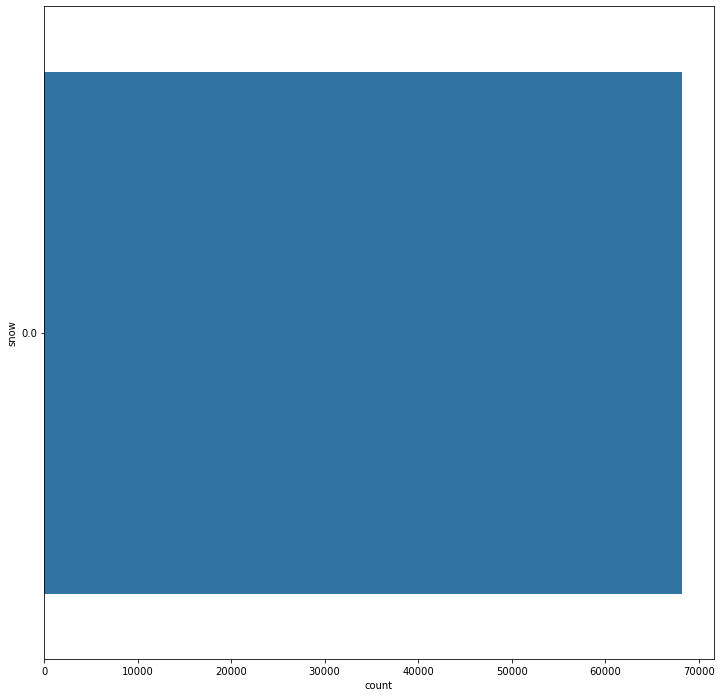

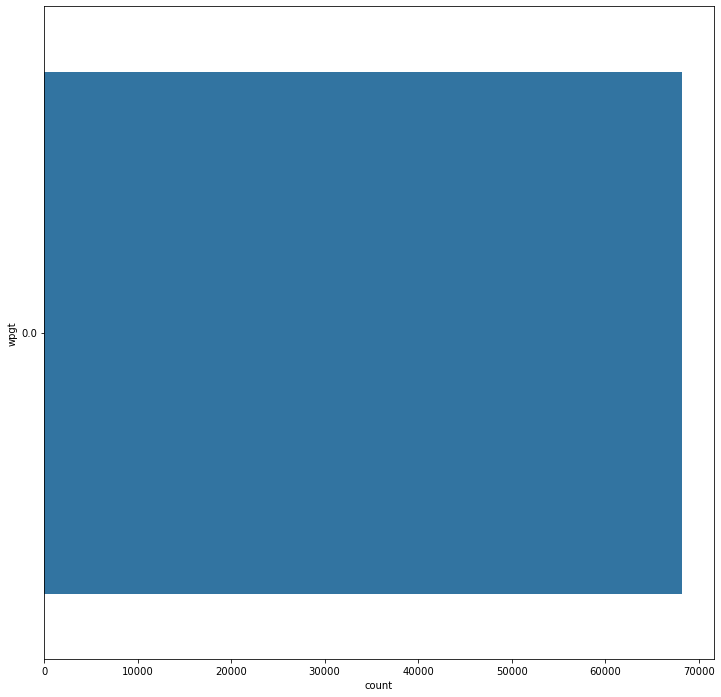

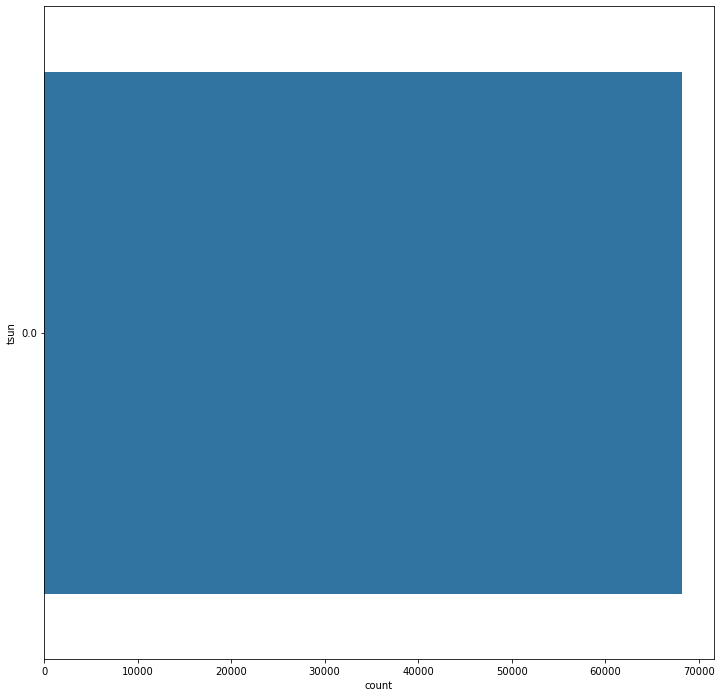

In [51]:
#Top n categorías (cambiar "top" para ver otras opciones)
top=100
df_bar_n=df_n[['Cambio_destino','Fecha', 'Hora','tavg', 'tmin', 'wspd', 'tmax', 'pres', 'prcp', 'wdir', 'snow', 'wpgt', 'tsun']]
for n in range(len(df_bar_n.columns)):
    count_order = df_bar_n[list(df_bar_n.columns.values)[n]].value_counts().head(top).index
    plt.figure(figsize=(12, 12))
    sns.countplot(data=df_bar_n, y=list(df_bar_n.columns.values)[n], order=count_order)
plt.show()


### Histoplots_new_variables

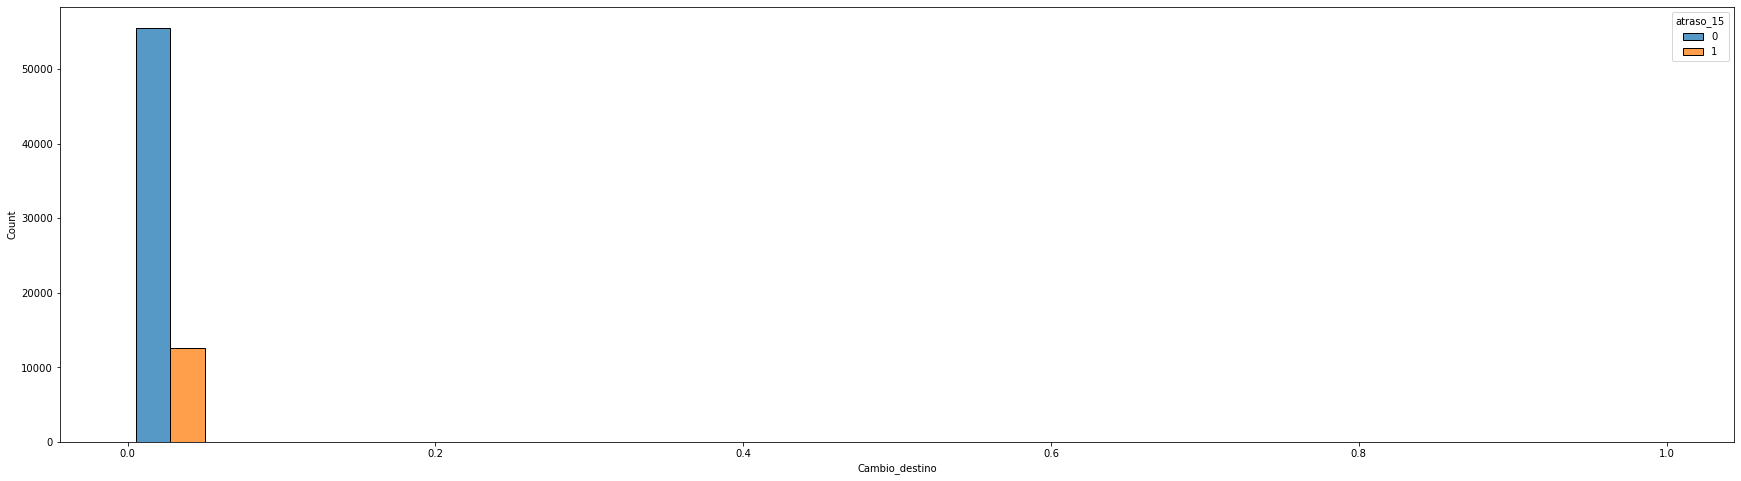

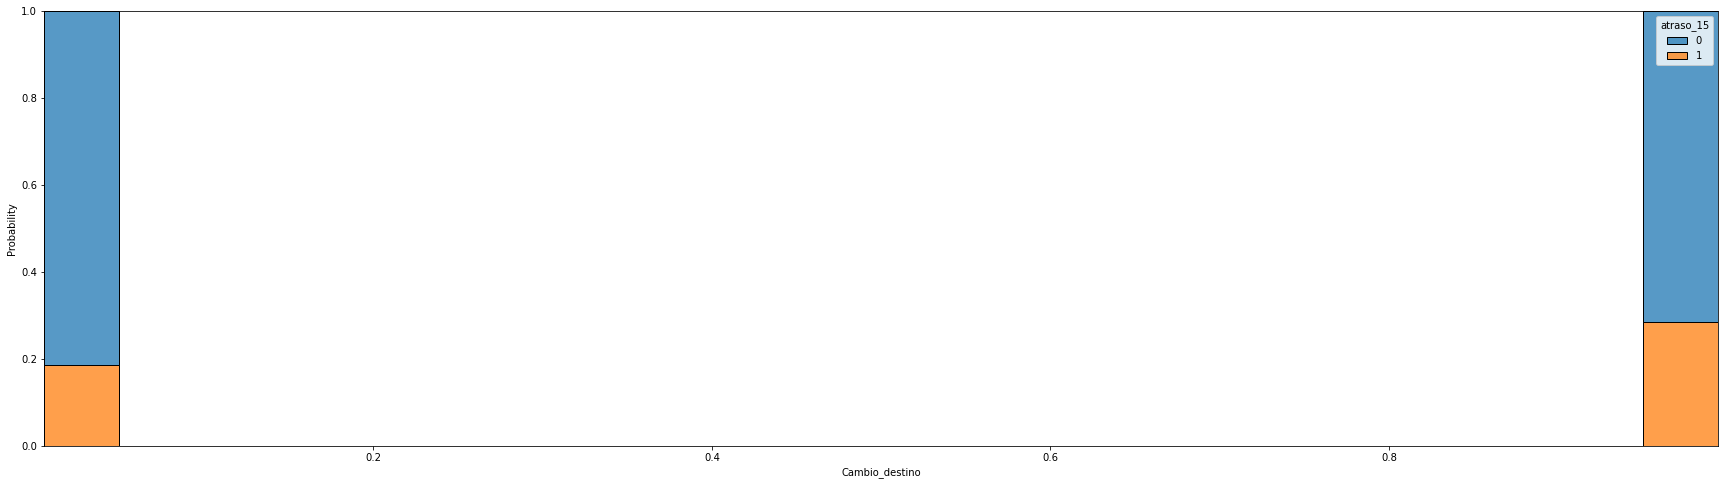

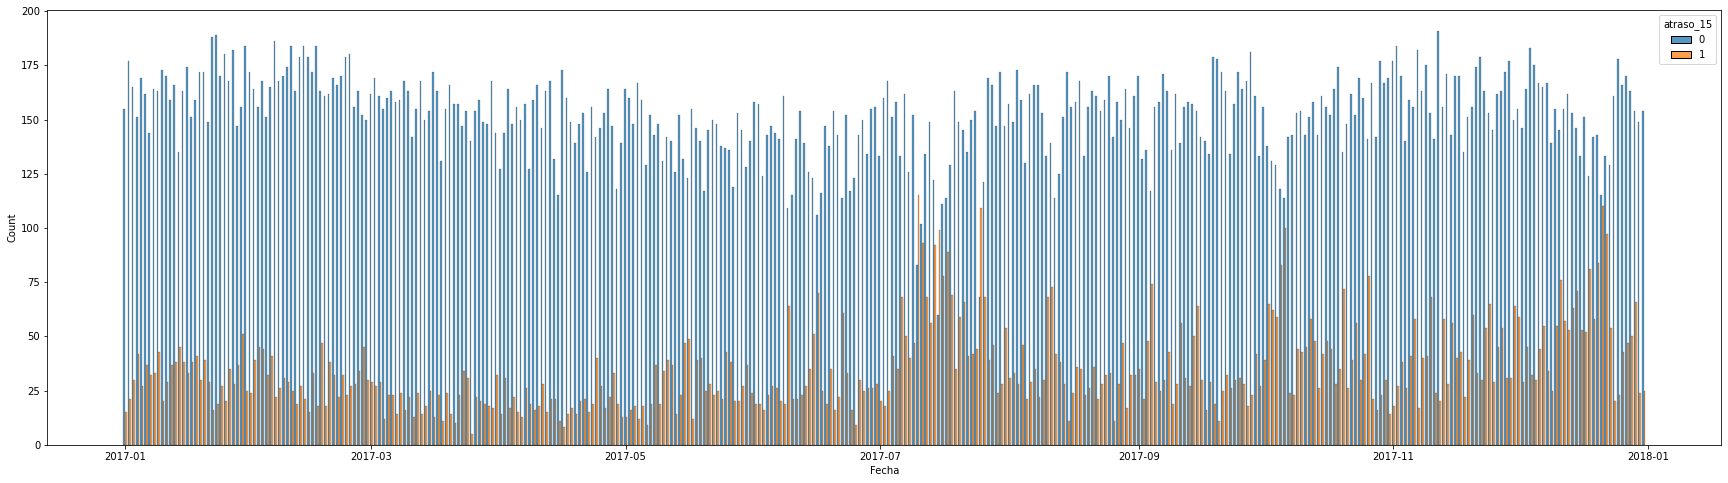

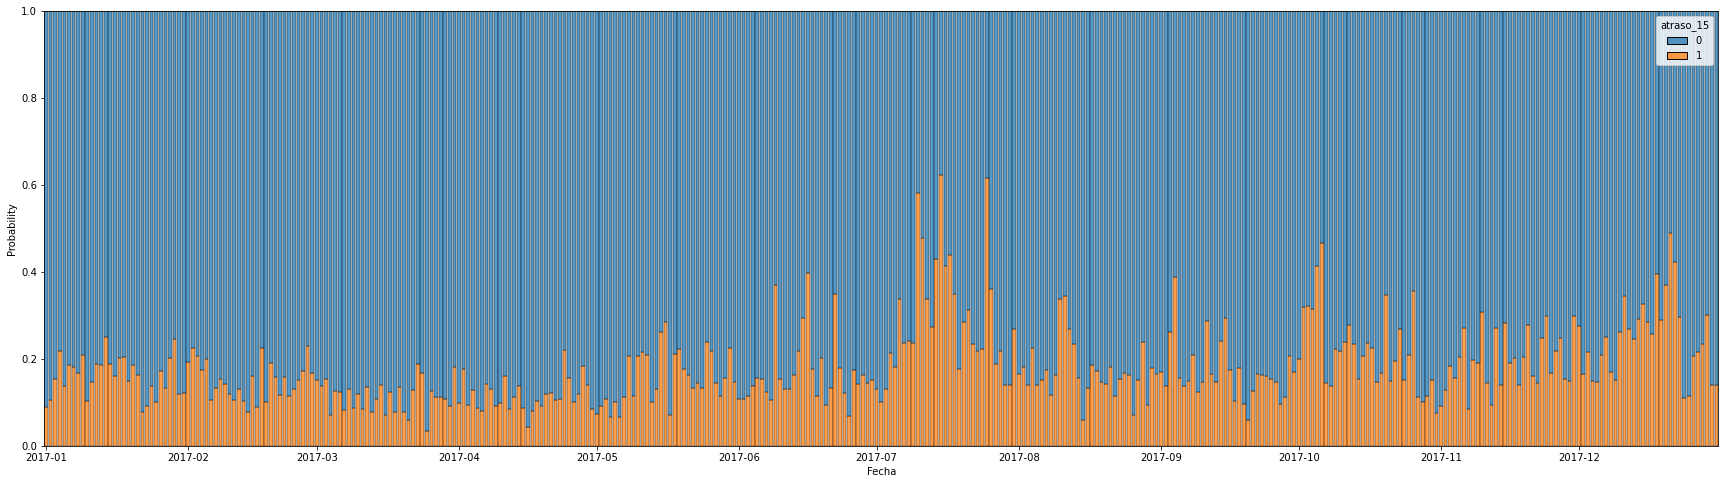

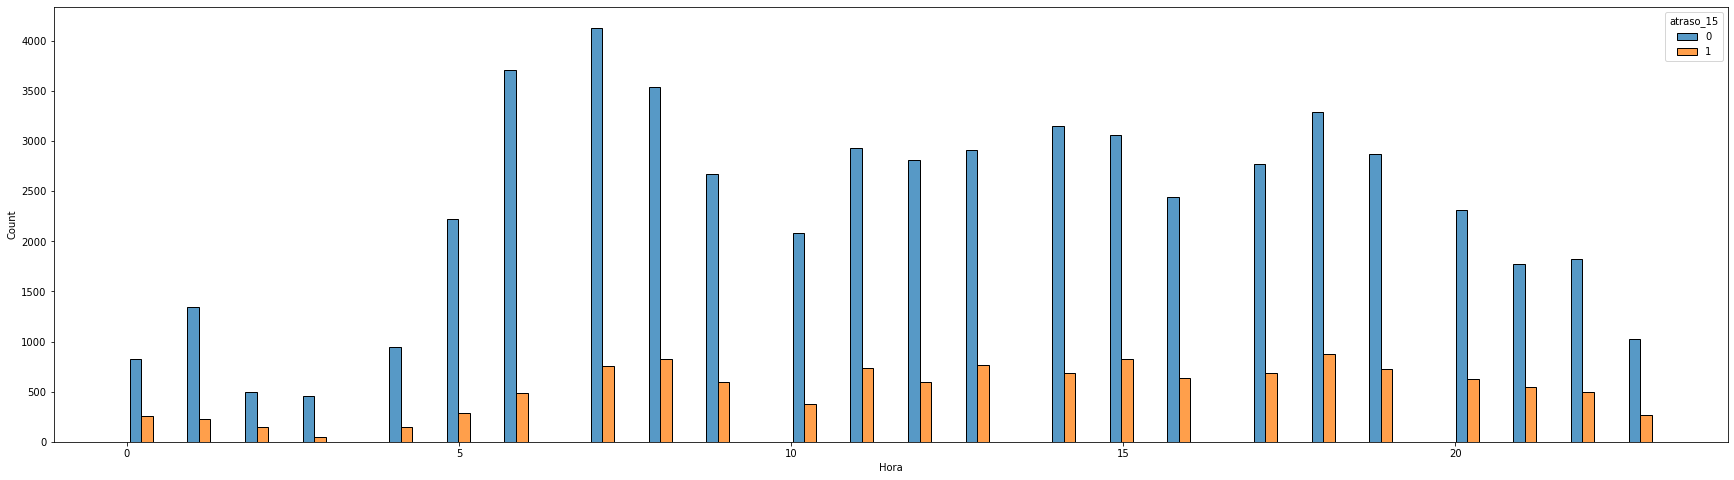

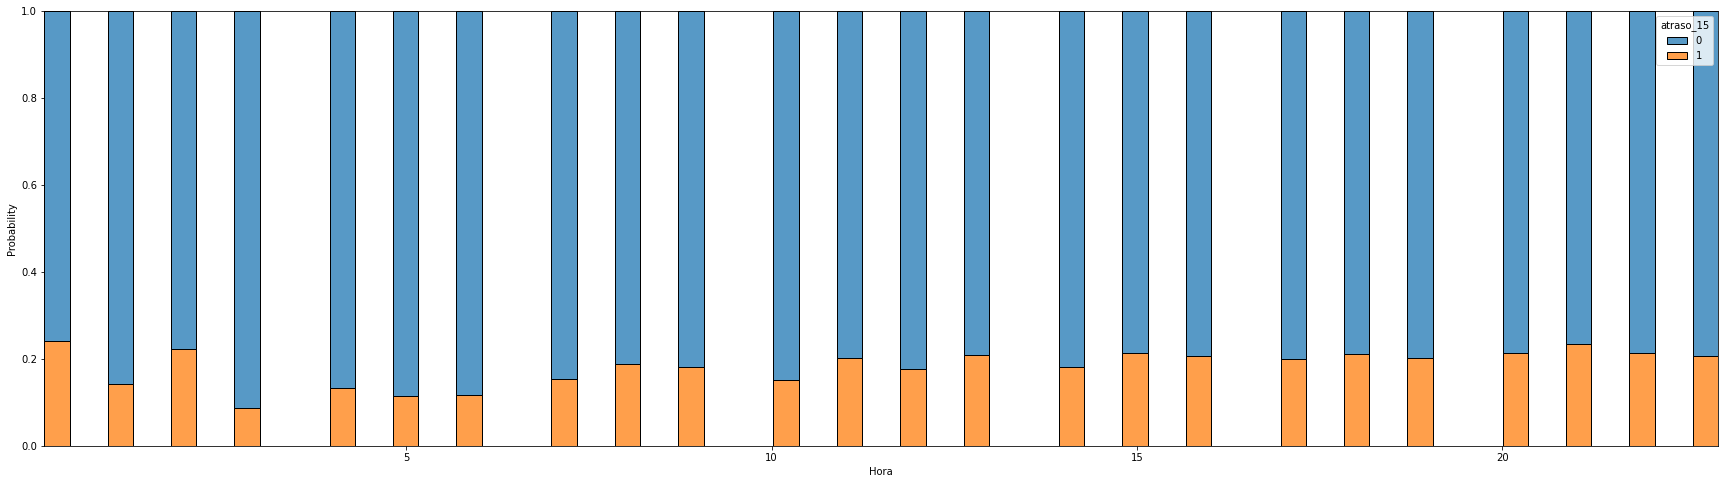

In [52]:
df_hist_n=df_n[['Cambio_destino','Fecha', 'Hora']]
for n in range(len(df_hist_n.columns)):
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist_n.columns.values)[n], hue="atraso_15", stat="count", multiple="dodge", shrink=.8)
    plt.show()
    plt.figure(figsize=(30, 8))
    sns.histplot(data=df, x=list(df_hist_n.columns.values)[n], hue="atraso_15", stat="probability", multiple="fill", shrink=.8)
    plt.show()

### Detalles_numericos_tasas

In [53]:
# Cantidad de atrasos y porcentajes según categorías
var=df['Des-I']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

atraso_15     0     1         %_0         %_1
Des-I                                        
SLCB          0     1    0.000000  100.000000
EGYP          0     1    0.000000  100.000000
SEQU          0     1    0.000000  100.000000
SEQM          0     1    0.000000  100.000000
SAWH          2     4   33.333333   66.666667
YSSY         82   113   42.051282   57.948718
YMML         17    21   44.736842   55.263158
SAZS          1     1   50.000000   50.000000
SAAR         82    54   60.294118   39.705882
NZAA        226   135   62.603878   37.396122
MDPC         36    18   66.666667   33.333333
CYYZ        194    89   68.551237   31.448763
SACO        715   308   69.892473   30.107527
SGAS        166    66   71.551724   28.448276
SBGL       1029   405   71.757322   28.242678
SAME       1182   443   72.738462   27.261538
SABE       2264   830   73.173885   26.826115
KMCO         25     9   73.529412   26.470588
SANT         28    10   73.684211   26.315789
SKBO       1189   415   74.127182   25.872818
KLAX        116    39   74.838710   25.161290
SLVR         90    30   75.000000   25.000000
SBGR       2689   881   75.322129   24.677871
SAEZ       2450   790   75.617284   24.382716
SPJC       4056  1214   76.963947   23.036053
SANU         27     8   77.142857   22.857143
KJFK        300    83   78.328982   21.671018
SUMU        846   220   79.362101   20.637899
SCIP        363    89   80.309735   19.690265
SEGU        341    82   80.614657   19.385343
SCJO        209    50   80.694981   19.305019
MMUN         51    12   80.952381   19.047619
LEMD        724   170   80.984340   19.015660
KMIA        822   193   80.985222   19.014778
SBFL        132    30   81.481481   18.518519
SCDA       3107   640   82.919669   17.080331
SCTE       3623   734   83.153546   16.846454
SULS          5     1   83.333333   16.666667
SCSE       2020   390   83.817427   16.182573
SCIE       3370   625   84.355444   15.644556
SCVD        636   117   84.462151   15.537849
SCQP       2182   401   84.475416   15.524584
SCCI       1781   324   84.608076   15.391924
SLLP        177    32   84.688995   15.311005
SCFA       4940   847   85.363746   14.636254
SCBA        720   123   85.409253   14.590747
EGLL        176    29   85.853659   14.146341
SCAT       1538   242   86.404494   13.595506
SCAR       2106   330   86.453202   13.546798
SCCF       4516   629   87.774538   12.225462
LIRF        230    29   88.803089   11.196911
SAZN         33     4   89.189189   10.810811
MMMX        634    66   90.571429    9.428571
SCNT         72     7   91.139241    8.860759
LFPG        328    31   91.364903    8.635097
SCPQ        217    18   92.340426    7.659574
KDFW        332    25   92.997199    7.002801
MPTO       1734   116   93.729730    6.270270
KATL        337    21   94.134078    5.865922
KIAH        318    17   94.925373    5.074627
SBFI          1     0  100.000000    0.000000
SBCT          3     0  100.000000    0.000000
SARI          1     0  100.000000    0.000000
SPSO          1     0  100.000000    0.000000

In [54]:
# Cantidad de atrasos y porcentajes según categorías
var=df['TIPOVUELO']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

atraso_15      0     1        %_0        %_1
TIPOVUELO                                   
I          24192  7048  77.439181  22.560819
N          31400  5566  84.942921  15.057079

In [55]:
# Cantidad de atrasos y porcentajes según categorías
var=df['DIANOM']
pd.set_option('display.max_rows', 100)
df2=pd.crosstab(var,df['atraso_15'],normalize='index', margins=True)*100
df3=pd.crosstab(var,df['atraso_15'])
df3['%_0']=df2[0]
df3['%_1']=df2[1]
df3.sort_values(by=['%_0'])
#%_0=porcentaje de 0 
#%_1=porcentaje of 1

atraso_15     0     1        %_0        %_1
DIANOM                                     
Viernes    8007  2285  77.798290  22.201710
Lunes      8083  2048  79.784819  20.215181
Jueves     8206  2045  80.050727  19.949273
Miercoles  8061  1661  82.915038  17.084962
Martes     8028  1634  83.088387  16.911613
Sabado     6989  1363  83.680556  16.319444
Domingo    8218  1578  83.891384  16.108616

### Detalles_numerico_desbalance

In [56]:
#Chequeo porcentaje de atraso_15 (para ver desbalance de categorías a predecir)
var=df['atraso_15']
pd.crosstab(var,df['atraso_15'],normalize='columns', margins=True)*100

atraso_15      0      1        All
atraso_15                         
0          100.0    0.0  81.506026
1            0.0  100.0  18.493974

### Histograma_de_dif_min

Skewness: 3.553969
Kurtosis: 16.813891


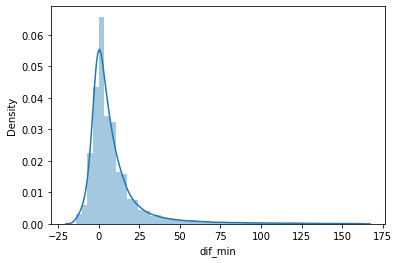

In [57]:
#histograma del atraso
sns.distplot(df['dif_min']);
#skewness and kurtosis
print("Skewness: %f" % df['dif_min'].skew())
print("Kurtosis: %f" % df['dif_min'].kurt())

Referencia:
Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.(close to 0 for a normal distribution)

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. (close to 3 for a normal distribution)

Al analizar el [histograma de la variable dif_min](#Histograma_de_dif_min) se puede ver que el atraso no es simétrico (Skewness=3.5 en lugar de cercano a cero) y que tiene una rango de datos muy amplio, extendiendose hacia valores positivos grandes comparado con la distribución normal (Kurtosis=16.8 en lugar de ser cercana a 3), esto puede traer problemas con algunos algoritmos si se pretendiese predecir esta variable. 

In [58]:
df_n[['Cambio_destino','Fecha', 'Hora','tavg', 'tmin', 'wspd', 'tmax', 'pres', 'prcp', 'wdir', 'snow', 'wpgt', 'tsun']].to_csv('new_features.csv')

### Pairplot new variables

In [59]:
# #Se deja comentado y la imagen abajo porque tarda mucho en correr
# datag = df_n
# sns.pairplot(data=datag, hue='atraso_15')
# plt.show()

Se guardó la imagen de salida porque tarda mucho en correr:
![title](img/graf2.png)